**TFM**

**Armando Acuña**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import scipy.stats as stats
import joblib

from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score, StratifiedKFold, ShuffleSplit, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, make_scorer, precision_score
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
#Buscar el dataset en el drive y extraer los archivos
ruta_drive = '/content/drive/MyDrive/Colab Notebooks/MSc_Data_Science/TFM/data_TFM_2.zip'
ruta_colab = '/content/data_TFM_2.zip'
shutil.copyfile(ruta_drive, ruta_colab)

path = '/content/'
shutil.unpack_archive(ruta_colab, path)

In [ ]:
#Selección de Paciente
sujeto = "S01"   #Seleccionar paciente de "S01" a "S28"

#Metodo de tratamiento de Valores Outliers
metodo_out = 'mean'   #mean
                      #median

#Tipo de Normalización
normal = '-1_1' #'0_1' Para Normalizar entre 0 y 1.
               #'-1_1' Para Normalizar entre -1 y 1


#Parámetros de la ventana móvil
tam_ven = 128  # seg * 128 (Ventana de 1 seg)
despla = 64       # seg * 128 * (1 - 50%)

# Preprocesado

##Cargar Datos

In [ ]:
def leer_archivos_eeg(sujeto):
    archivos = [
        f"/content/data_TFM_2/({sujeto})/Preprocessed EEG Data/.csv format/{sujeto}G1AllChannels.csv",
        f"/content/data_TFM_2/({sujeto})/Preprocessed EEG Data/.csv format/{sujeto}G2AllChannels.csv",
        f"/content/data_TFM_2/({sujeto})/Preprocessed EEG Data/.csv format/{sujeto}G3AllChannels.csv",
        f"/content/data_TFM_2/({sujeto})/Preprocessed EEG Data/.csv format/{sujeto}G4AllChannels.csv"
    ]

    dfs = [pd.read_csv(archivo) for archivo in archivos] #Leer archivos CSV y guardarlos en una lista de DataFrames

    #Asignar nombre
    nombres_dfs = [f"df_{i+1}" for i in range(len(dfs))]
    dfs_con_nombres = dict(zip(nombres_dfs, dfs))
    return dfs_con_nombres

In [ ]:
EEG = leer_archivos_eeg(sujeto)

In [ ]:
EEG['df_1']

AF3        AF4       F3       F4       F7        F8      FC5  \
0     -33.02050 -15.184600 -42.1795   1.6872  42.1793  -1.68720  -5.5436   
1     -28.62910 -20.058300 -42.5410 -10.4653  35.3100 -15.68600 -19.3110   
2     -21.84970 -10.900600 -32.0346  -2.3656  39.6993  -0.64483  -4.0523   
3     -25.11850 -10.970200 -32.7641  -3.4287  32.7378   4.69650  -8.6299   
4     -19.03160  -9.588600 -29.1108  -3.9459  35.3533   0.79929 -12.6914   
...         ...        ...      ...      ...      ...       ...      ...   
38247  -3.44540   5.143000 -13.7038  -5.1667  -7.5078  -4.30370   2.5577   
38248  -0.58772  14.234500  -2.5176   9.2433  -2.4780  10.05450  16.5042   
38249  -7.30110  10.488200  -1.8844  21.8247  -6.6676  23.55120   9.3676   
38250   0.84994  11.304900  -1.2892   6.4152   7.8324  30.33300  20.8569   
38251   3.69100   0.021307  -5.0684  -8.0697  10.6162  14.41300   5.5054   

           FC6       O1        O2        P7        P8       T7       T8  \
0      -3.6154  25.7899  -9.88190   5.54360   7.47180  11.8101  17.1128   
1      -2.4344  17.4933   3.24420  18.70810   5.09510  17.3683   3.0708   
2      -1.0830  26.8081  -3.45840   8.18610   8.40480  15.1209   9.3940   
3      -1.7412  16.7637  -9.75860   1.18680   0.91086   4.3315   8.1073   
4       1.0144  13.1068  -0.73692   8.10540  -1.31300   8.1694   8.3442   
...        ...      ...       ...       ...       ...      ...      ...   
38247  21.9423   5.8066  28.30880   5.71820  -1.37380 -11.0612 -13.8254   
38248   6.5258  19.5582  12.51030  -8.72480  12.80860 -12.5673   1.1041   
38249  -7.9658   4.2847  -2.34030 -22.30140   3.96570  -8.9205   3.0867   
38250  -1.7034  17.4045  -4.61020  -9.39420  -6.87730  -4.5291  -4.3294   
38251  12.4988  23.1089   5.30730   0.32846  -6.46490 -12.9340  -1.6595   

       Unnamed: 14  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
38247          NaN  
38248          NaN  
38249          NaN  
38250          NaN  
38251          NaN  

[38252 rows x 15 columns]

##Etiquetar Datos

In [ ]:
def EEG_label(EEG):
    for nombre_df, df in EEG.items():
        if 'Unnamed: 14' in df.columns: #Eliminar columna 'Unnamed: 14'
            df.drop(columns=['Unnamed: 14'], inplace=True)
        #Crear columna 'Terror' con los valores especificados
        if nombre_df == 'df_3':
            df['Terror'] = 1
        else:
            df['Terror'] = 0
    return EEG

In [ ]:
EEG = EEG_label(EEG)

In [ ]:
EEG['df_1'].head()

AF3      AF4       F3       F4       F7        F8      FC5     FC6  \
0 -33.0205 -15.1846 -42.1795   1.6872  42.1793  -1.68720  -5.5436 -3.6154   
1 -28.6291 -20.0583 -42.5410 -10.4653  35.3100 -15.68600 -19.3110 -2.4344   
2 -21.8497 -10.9006 -32.0346  -2.3656  39.6993  -0.64483  -4.0523 -1.0830   
3 -25.1185 -10.9702 -32.7641  -3.4287  32.7378   4.69650  -8.6299 -1.7412   
4 -19.0316  -9.5886 -29.1108  -3.9459  35.3533   0.79929 -12.6914  1.0144   

        O1       O2       P7       P8       T7       T8  Terror  
0  25.7899 -9.88190   5.5436  7.47180  11.8101  17.1128       0  
1  17.4933  3.24420  18.7081  5.09510  17.3683   3.0708       0  
2  26.8081 -3.45840   8.1861  8.40480  15.1209   9.3940       0  
3  16.7637 -9.75860   1.1868  0.91086   4.3315   8.1073       0  
4  13.1068 -0.73692   8.1054 -1.31300   8.1694   8.3442       0

In [ ]:
EEG['df_3'].head()

AF3      AF4       F3        F4       F7       F8     FC5      FC6  \
0  52.5434 -33.7436  91.1077 -19.28220 -57.8463  48.2051  1.9284 -11.0870   
1  48.9088 -29.3086  82.2668 -12.82260 -62.0883  37.1181  2.7766 -10.4218   
2  43.0825 -24.6576  79.2592  -4.82220 -55.4704  29.1066 -0.2823  -9.3145   
3  43.3896 -21.7323  79.8063  -0.19451 -39.6090  35.5549  1.6628  -8.7559   
4  46.5708 -23.8029  75.4999  -5.48570 -37.2327  28.1190 -2.2933  -4.8561   

        O1       O2       P7       P8       T7      T8  Terror  
0  42.4205 -1.92840  74.2359  -6.2667  22.1742 -4.8205       1  
1  30.2343 -6.15100  65.4434  -8.7828   8.3107 -2.6031       1  
2  34.6870  0.48477  62.9629 -11.6303   5.8837 -5.3392       1  
3  42.7287 -1.47250  57.7388 -14.7891  11.7972 -4.5369       1  
4  31.4878  2.47220  60.5410  -9.5632   7.7149 -3.3003       1

##Valores Nulos

In [ ]:
def check(data):
    l=[]
    columns=data.columns
    for col in columns:
        dtypes=data[col].dtypes
        nunique=data[col].nunique()
        sum_null=data[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df=pd.DataFrame(l)
    df.columns=['column','dtypes','nunique','sum_null']
    return df

In [ ]:
check(EEG['df_1'])

column   dtypes  nunique  sum_null
0      AF3  float64    36459         0
1      AF4  float64    36497         0
2       F3  float64    36795         0
3       F4  float64    36804         0
4       F7  float64    36857         0
5       F8  float64    36968         0
6      FC5  float64    36987         0
7      FC6  float64    36994         0
8       O1  float64    37098         0
9       O2  float64    37186         0
10      P7  float64    37293         0
11      P8  float64    36598         0
12      T7  float64    36864         0
13      T8  float64    36756         0
14  Terror    int64        1         0

In [ ]:
check(EEG['df_2'])

column   dtypes  nunique  sum_null
0      AF3  float64    36224         0
1      AF4  float64    36120         0
2       F3  float64    36423         0
3       F4  float64    36626         0
4       F7  float64    36590         0
5       F8  float64    36775         0
6      FC5  float64    37071         0
7      FC6  float64    36774         0
8       O1  float64    37237         0
9       O2  float64    37148         0
10      P7  float64    37287         0
11      P8  float64    36654         0
12      T7  float64    36883         0
13      T8  float64    36313         0
14  Terror    int64        1         0

In [ ]:
check(EEG['df_3'])

column   dtypes  nunique  sum_null
0      AF3  float64    36102         0
1      AF4  float64    36090         0
2       F3  float64    36115         0
3       F4  float64    36473         0
4       F7  float64    36756         0
5       F8  float64    36796         0
6      FC5  float64    36769         0
7      FC6  float64    36663         0
8       O1  float64    37169         0
9       O2  float64    37007         0
10      P7  float64    37042         0
11      P8  float64    36640         0
12      T7  float64    36473         0
13      T8  float64    35996         0
14  Terror    int64        1         0

In [ ]:
check(EEG['df_4'])

column   dtypes  nunique  sum_null
0      AF3  float64    36241         0
1      AF4  float64    36138         0
2       F3  float64    36182         0
3       F4  float64    36575         0
4       F7  float64    36723         0
5       F8  float64    36681         0
6      FC5  float64    36900         0
7      FC6  float64    36783         0
8       O1  float64    37100         0
9       O2  float64    37078         0
10      P7  float64    37157         0
11      P8  float64    36726         0
12      T7  float64    36514         0
13      T8  float64    36434         0
14  Terror    int64        1         0

##Outliers

In [ ]:
EEG_T = {}

In [ ]:
#Visualización Histograma
def hist(data, name):
  for columna in data.columns:
    plt.figure(figsize=(6,4))
    plt.hist(data[columna], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Histograma para {columna} en {name}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

#Visualización Diagrama de Violin
def viol(data, name):
    for columna in data.columns:
        plt.figure(figsize=(8, 6))  # Crear una nueva figura para cada columna
        sns.violinplot(data=data[columna], color='skyblue')
        plt.title(f'Gráfico de Violín para {columna} en {name}')
        plt.xlabel(f'Columna {columna}')
        plt.ylabel('Valor')
        plt.grid(True)
        plt.show()


#Visualización BoxPlot Grupal
def boxpot_g(data, name):
  plt.figure(figsize=(12, 8))
  sns.boxplot(data=data, orient='v', palette='Set3')
  plt.title(f'Boxplot para {name}')
  plt.ylabel('Valor')
  plt.xlabel('Columna')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.savefig(f'Box{name}', dpi=300)
  plt.show()

#Visualización BoxPlot Individual
def boxpot_i(data, name):
  for columna in data.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[columna], color='skyblue')
    plt.title(f'Boxplot para {columna} en {name}')
    plt.xlabel('Valor')
    plt.grid(True)
    plt.show()

In [ ]:
#Calculo Outliers, Método del Rango Intercuartílico (IQR)
def detec_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    outliers = ((df < lim_inf) | (df > lim_sup))
    return outliers

#Tratamiento de Valores Outliers
def trat_outliers(df, out_series, metodo):
  if metodo == 'mean':
    EEG_T = df.apply(lambda x: np.where(out_series[x.name], x.mean(), x))
  elif metodo == 'median':
    EEG_T = df.apply(lambda x: np.where(out_series[x.name], x.median(), x))
  return EEG_T

### Aburrido (EEG['df_1'])

In [ ]:
EEG['df_1'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.013611      0.006082      0.004386     -0.006251     -0.005188   
std       10.152945     11.071779     14.352935     13.747399     25.978797   
min      -46.013900    -71.382200   -104.268500    -94.795000   -234.664500   
25%       -6.483925     -6.416525     -7.940150     -8.376975     -8.812925   
50%       -0.218545     -0.227875     -0.302535      0.060477     -0.011204   
75%        6.445850      6.542250      8.084525      8.463400      8.705750   
max       52.488800     46.643200    208.565200     77.857900    234.889100   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.021498     -0.016589      0.015937     -0.029628      0.005387   
std       13.743485     16.210359     14.471805     18.637859     17.867029   
min      -86.228000    -83.861800    -75.213300   -104.469600    -87.812700   
25%       -9.363550    -10.079800     -9.604250    -10.621125    -11.378100   
50%       -0.045357      0.090598     -0.143080     -0.109125     -0.035530   
75%        9.219000     10.104950      9.721700     10.361400     11.516325   
max       69.991000    159.357800     96.310000    114.401500     87.487600   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.000706      0.001598      0.032812     -0.006881      0.0  
std       21.587647     11.499994     14.924300     12.084201      0.0  
min     -143.605700    -66.375800    -70.475300    -57.277100      0.0  
25%      -13.007825     -7.178325     -9.210325     -7.917775      0.0  
50%       -0.043945     -0.200560     -0.055330      0.235105      0.0  
75%       12.806325      7.072225      9.186625      8.148350      0.0  
max      185.011600     55.629000    114.101300     56.314400      0.0

In [ ]:
EEG['df_1'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4          F3         F4          F7         F8  \
mean   0.013611   0.006082    0.004386  -0.006251   -0.005188  -0.021498   
std   10.152945  11.071779   14.352935  13.747399   25.978797  13.743485   
min  -46.013900 -71.382200 -104.268500 -94.795000 -234.664500 -86.228000   
max   52.488800  46.643200  208.565200  77.857900  234.889100  69.991000   

             FC5        FC6          O1         O2          P7         P8  \
mean   -0.016589   0.015937   -0.029628   0.005387    0.000706   0.001598   
std    16.210359  14.471805   18.637859  17.867029   21.587647  11.499994   
min   -83.861800 -75.213300 -104.469600 -87.812700 -143.605700 -66.375800   
max   159.357800  96.310000  114.401500  87.487600  185.011600  55.629000   

              T7         T8  Terror  
mean    0.032812  -0.006881     0.0  
std    14.924300  12.084201     0.0  
min   -70.475300 -57.277100     0.0  
max   114.101300  56.314400     0.0

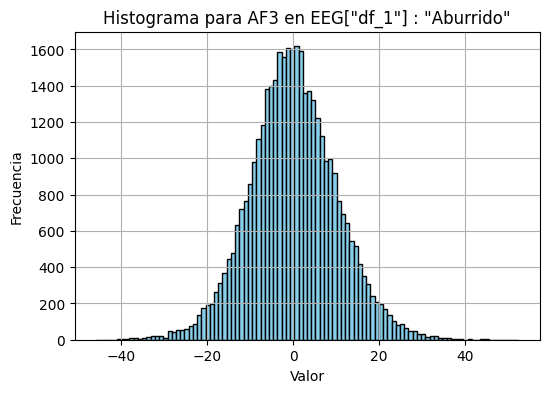

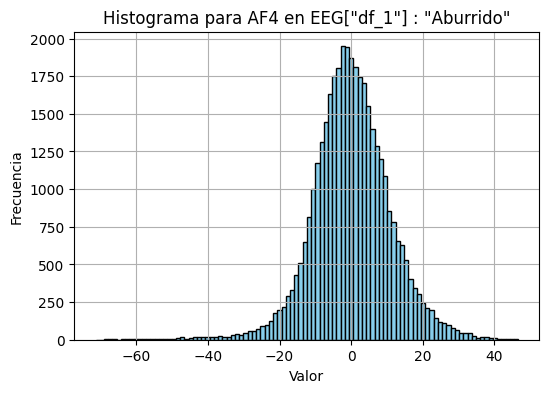

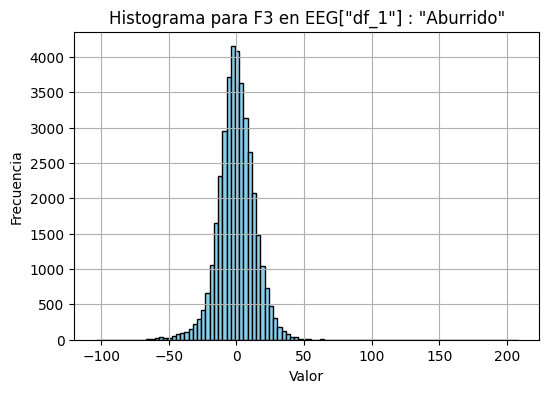

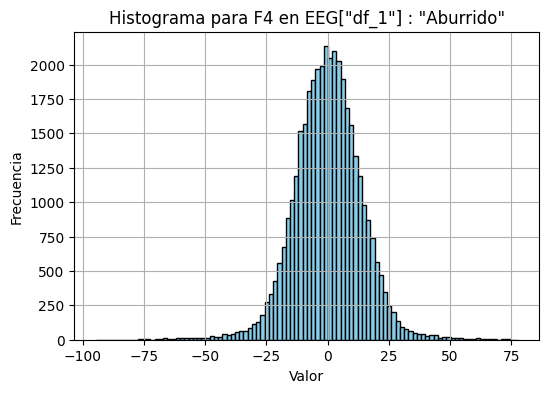

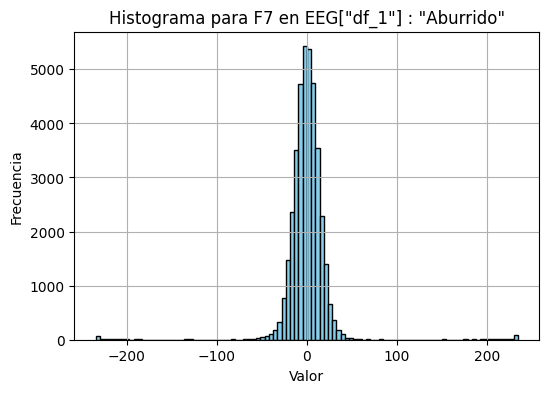

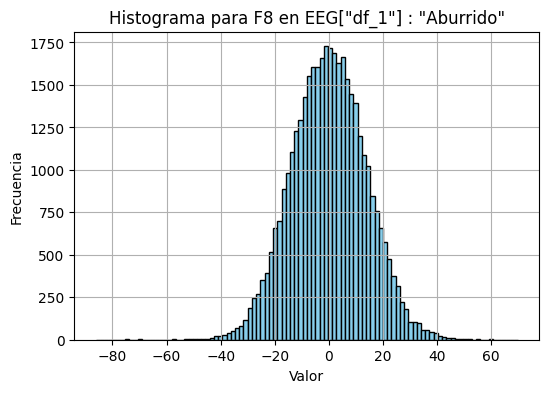

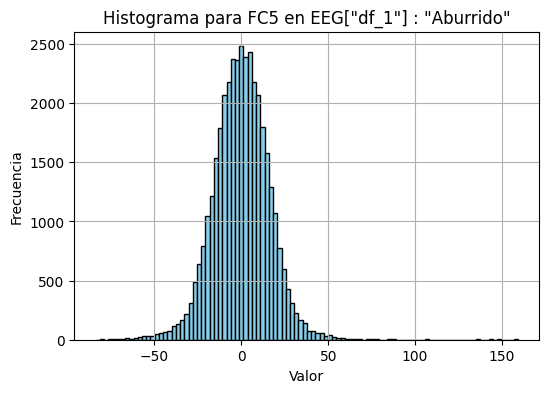

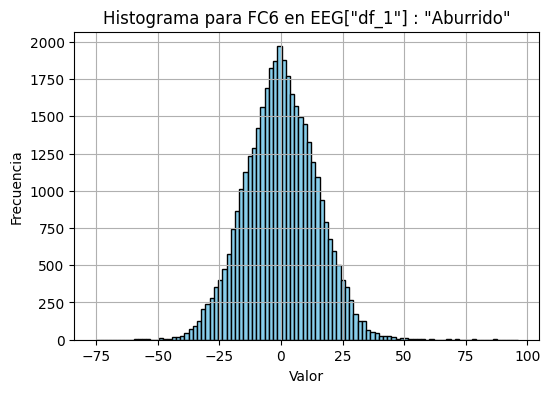

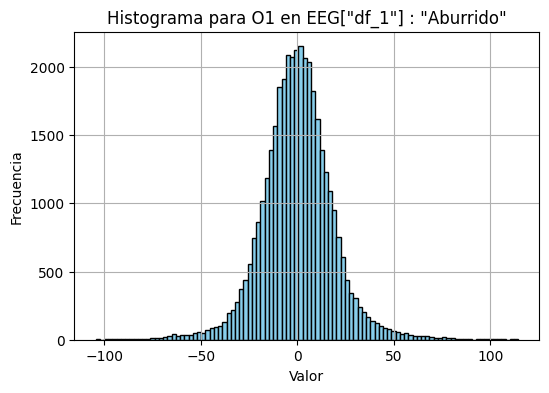

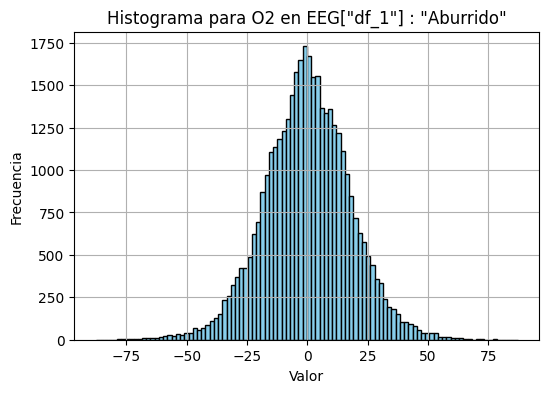

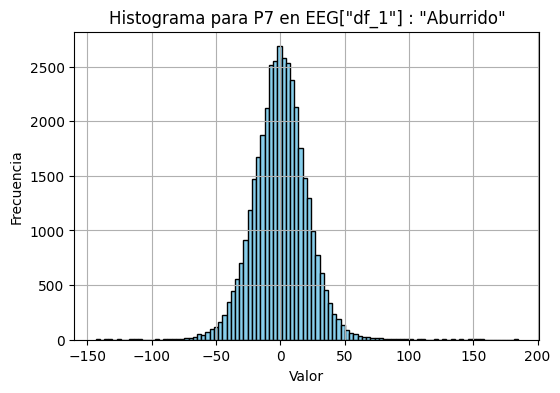

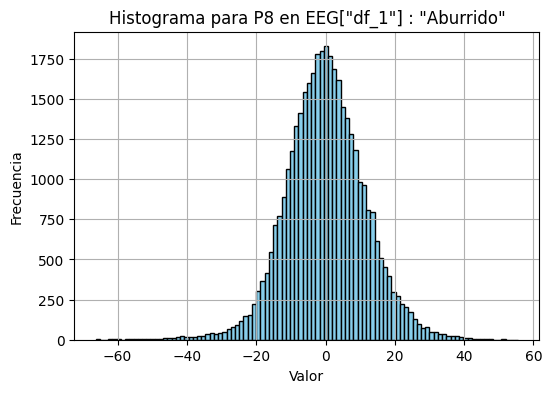

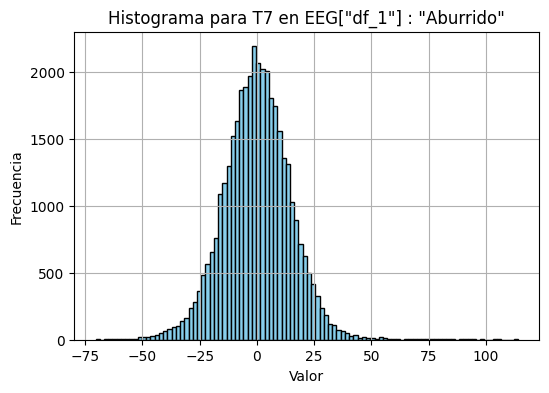

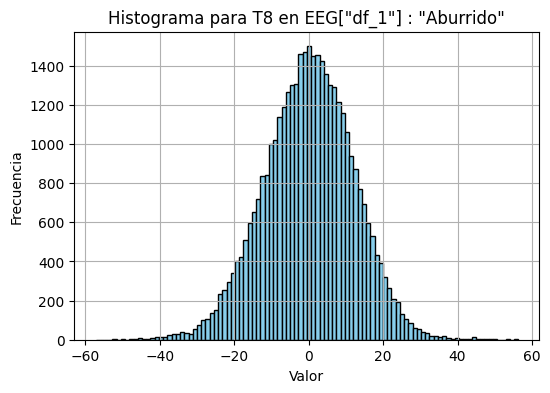

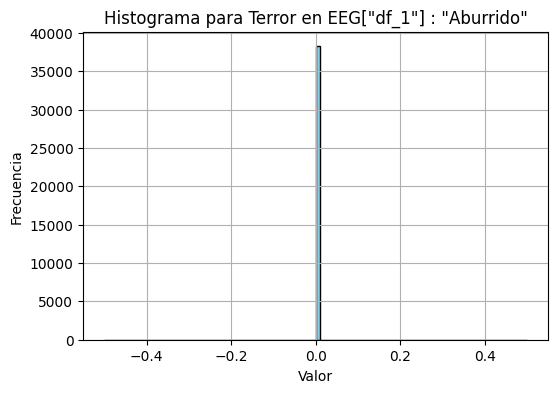

In [ ]:
hist(EEG['df_1'],'EEG["df_1"] : "Aburrido"')

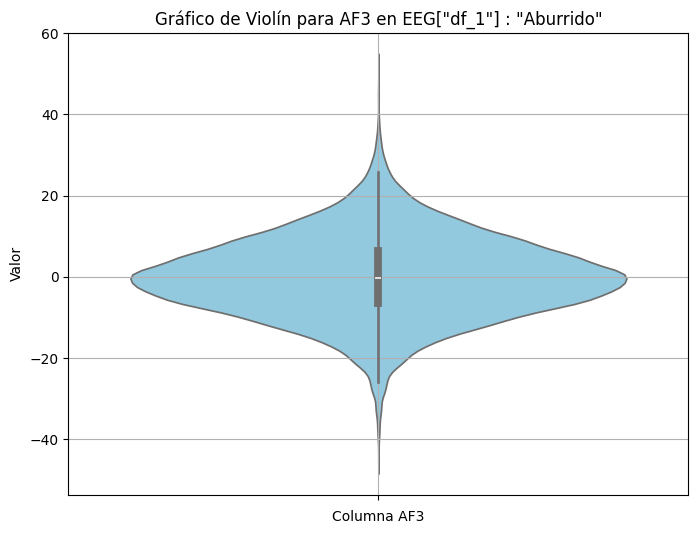

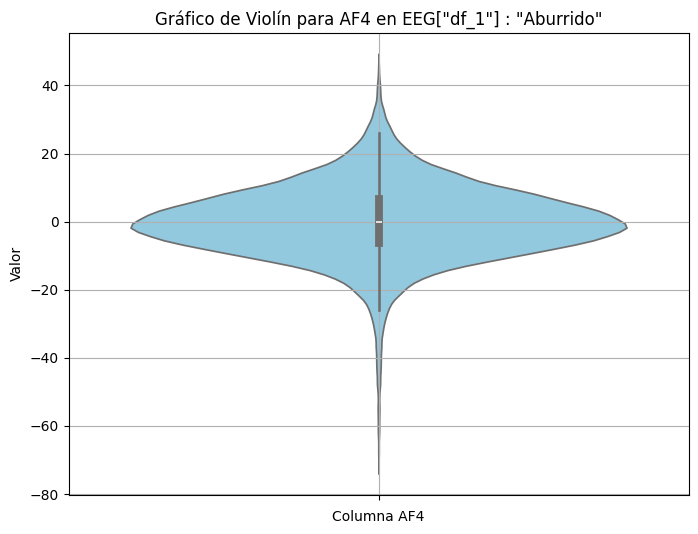

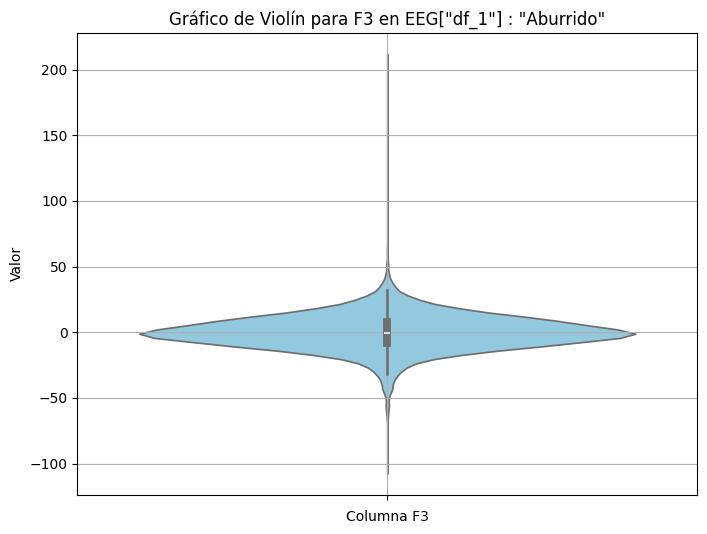

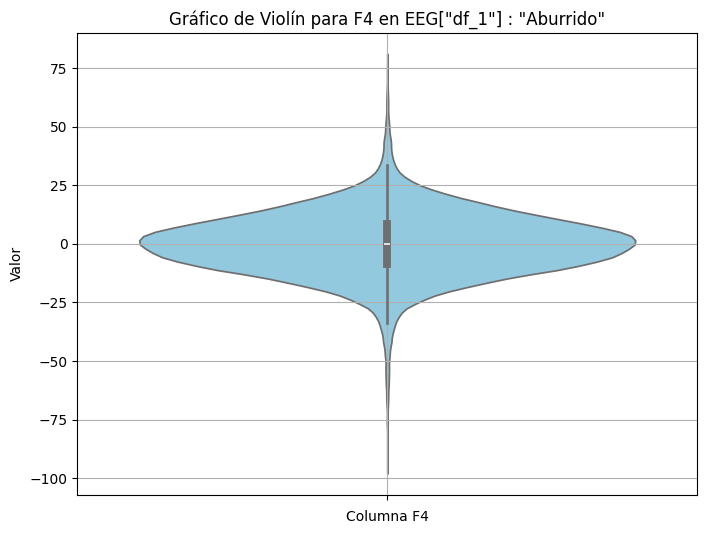

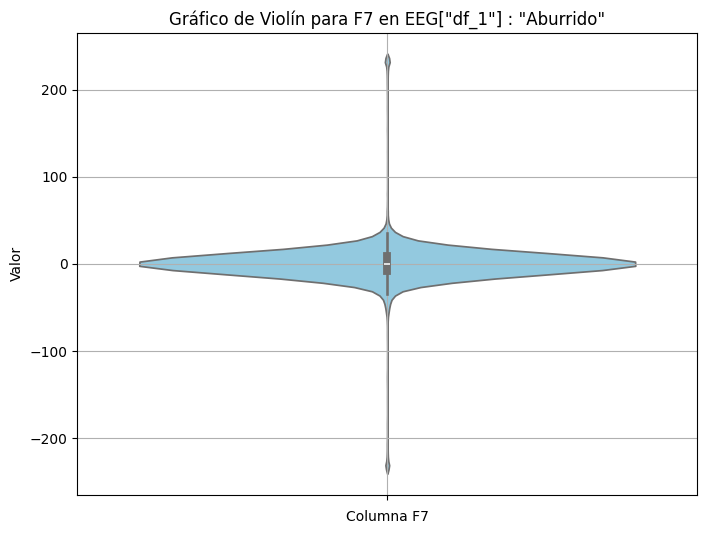

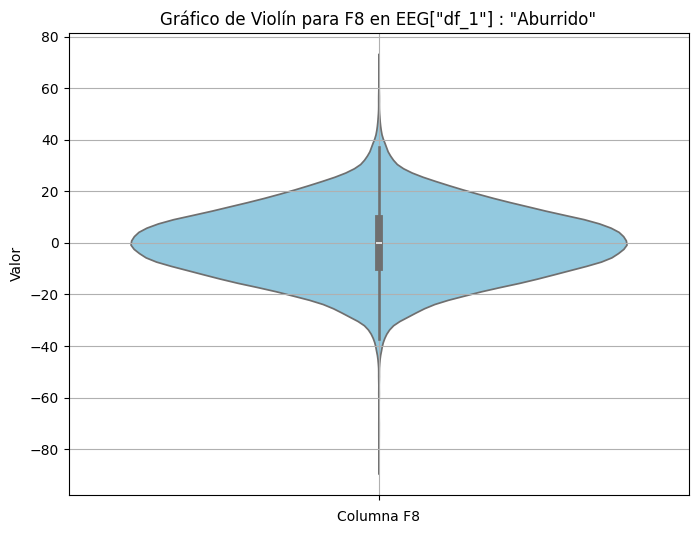

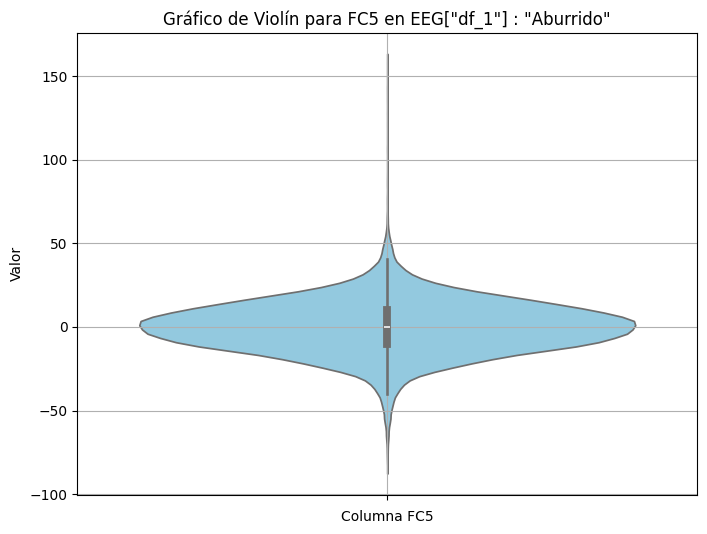

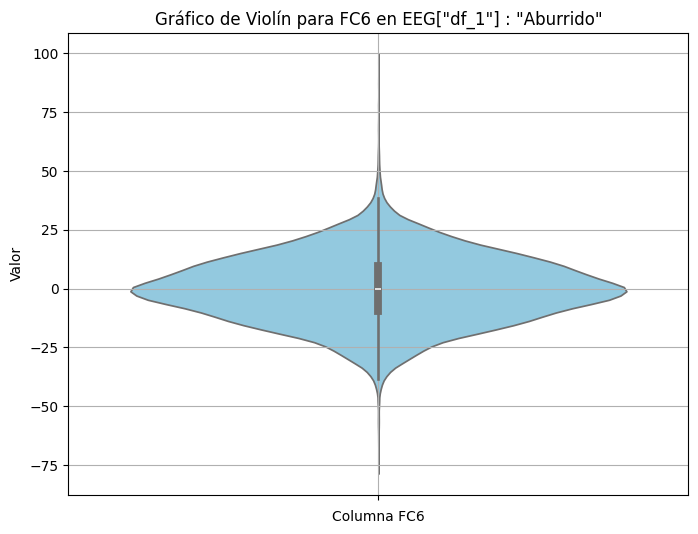

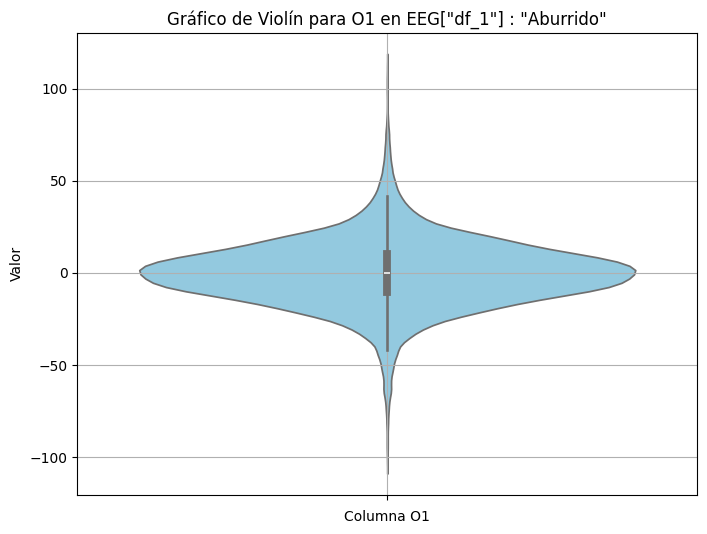

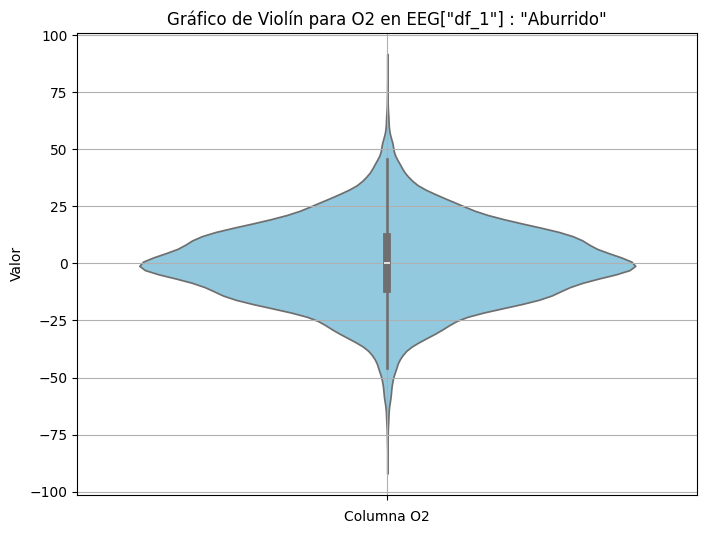

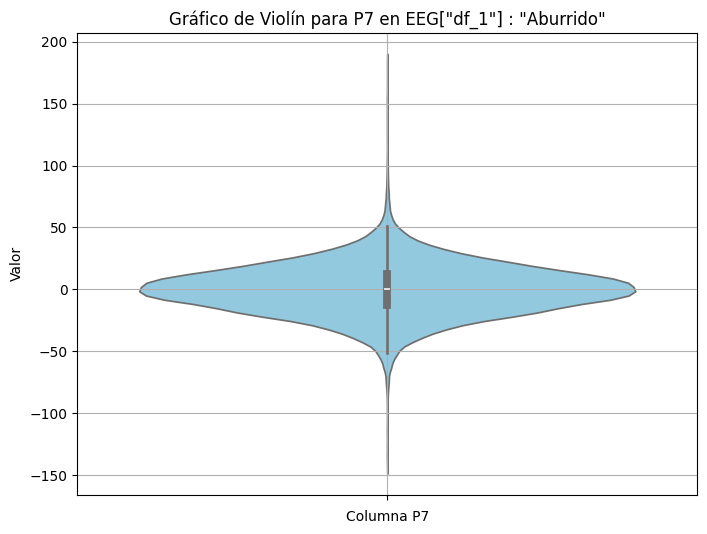

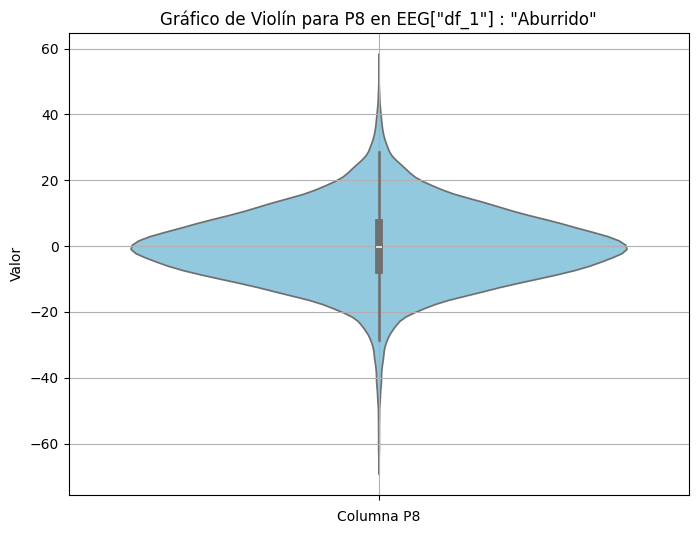

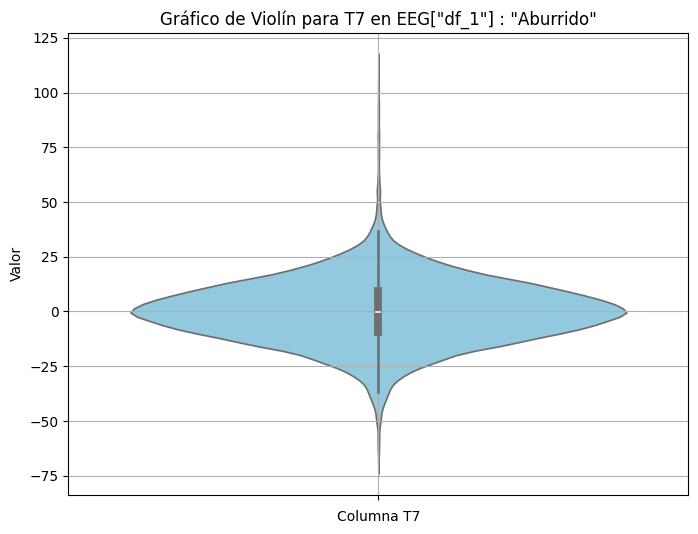

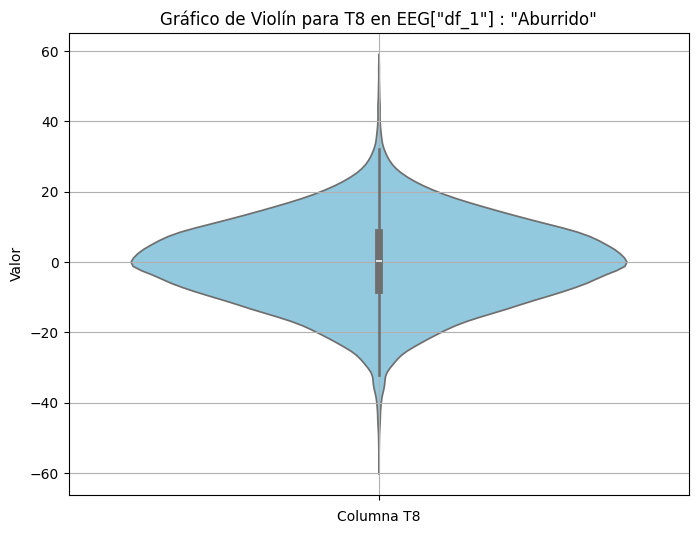

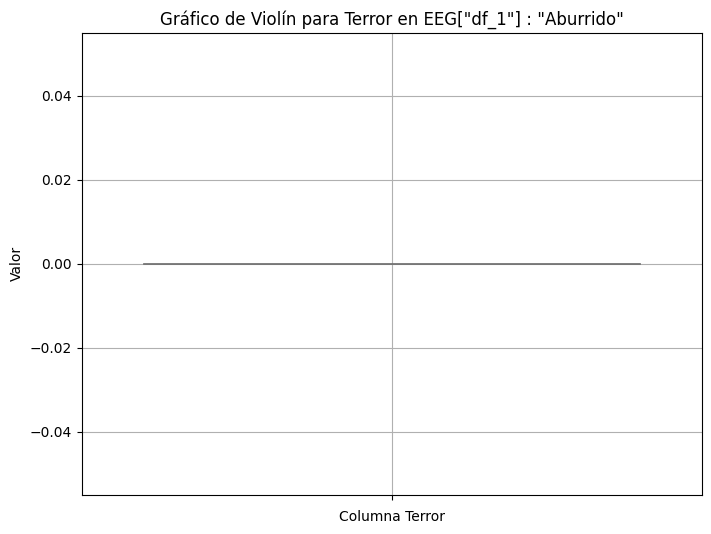

In [ ]:
viol(EEG['df_1'],'EEG["df_1"] : "Aburrido"')

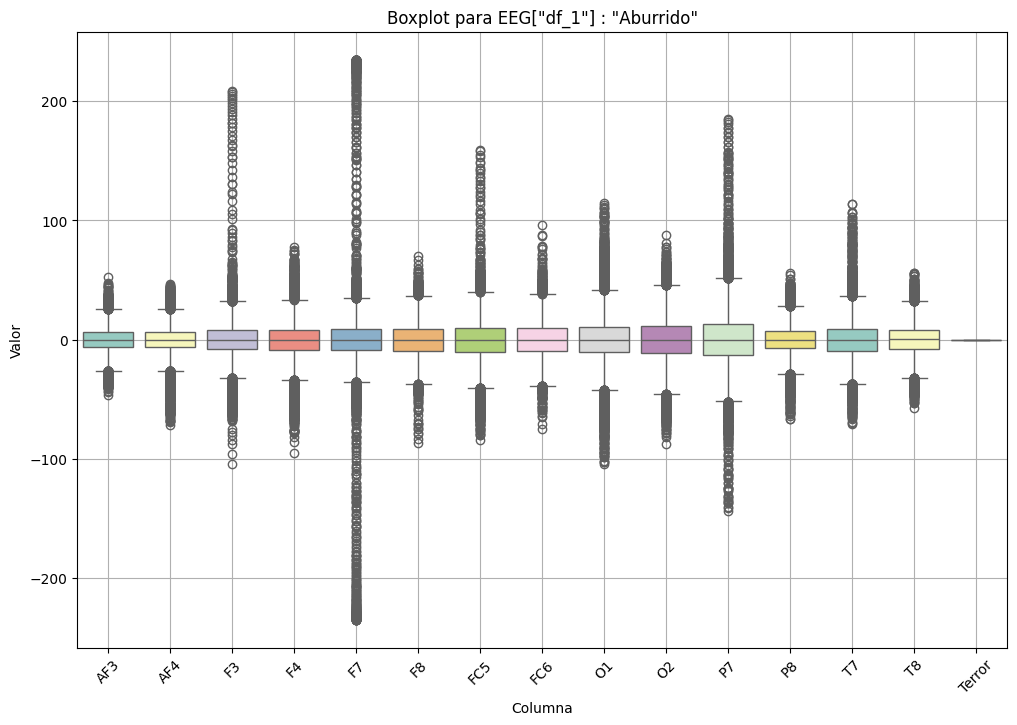

In [ ]:
boxpot_g(EEG['df_1'],'EEG["df_1"] : "Aburrido"')

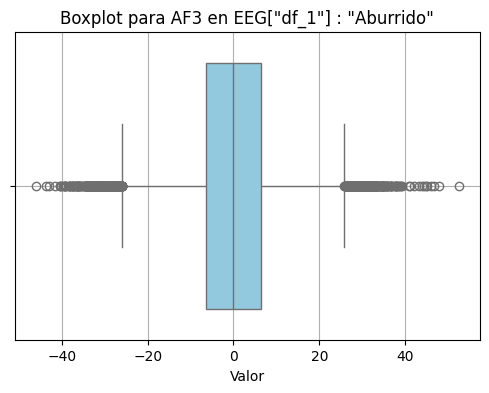

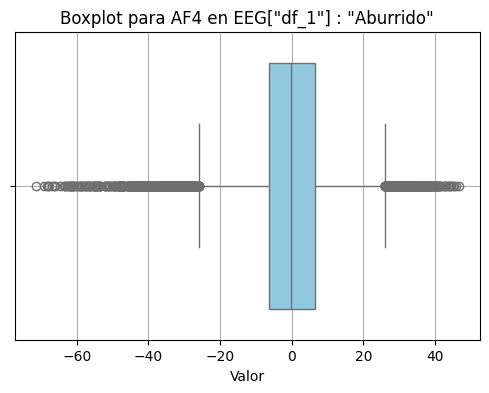

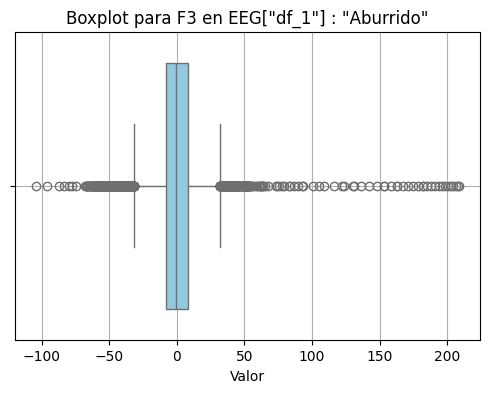

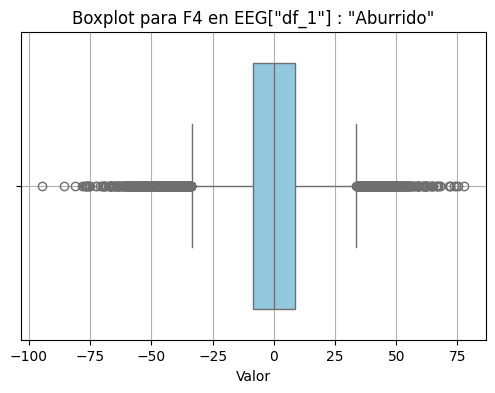

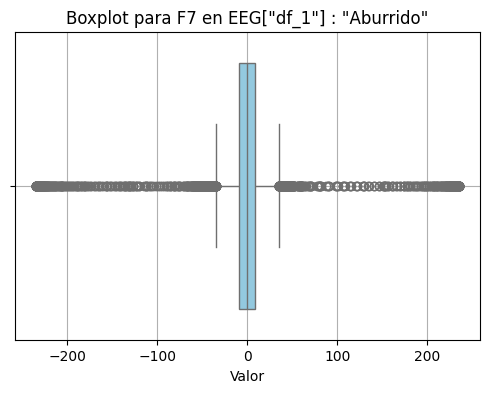

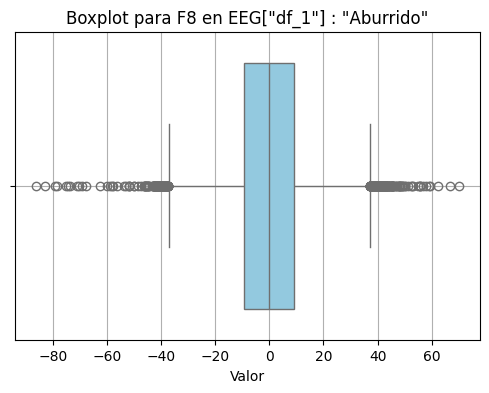

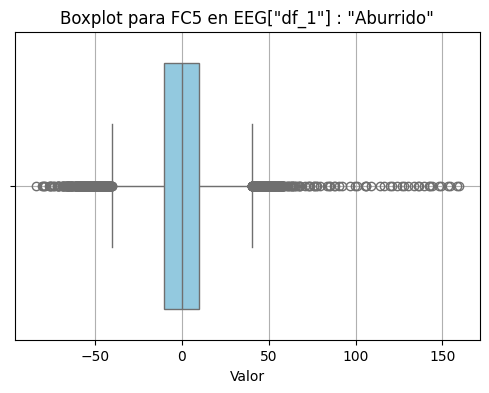

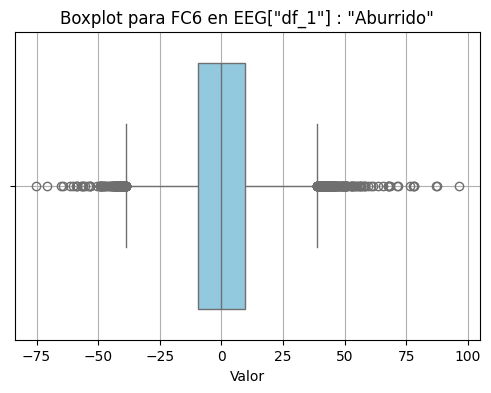

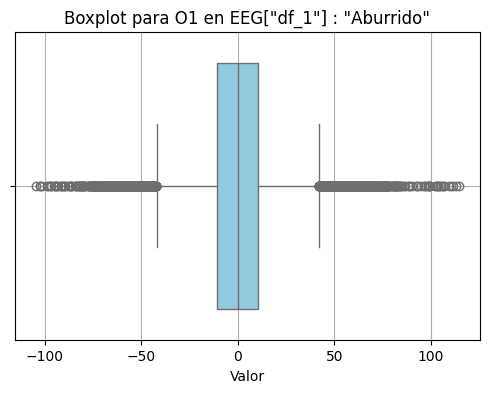

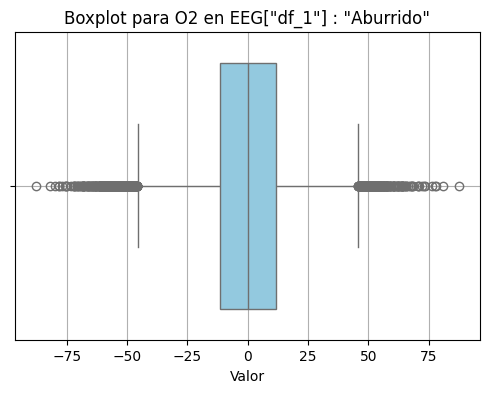

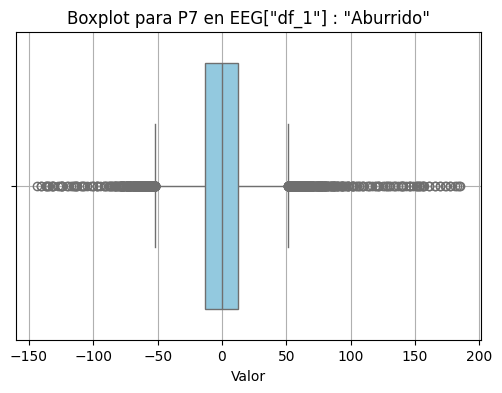

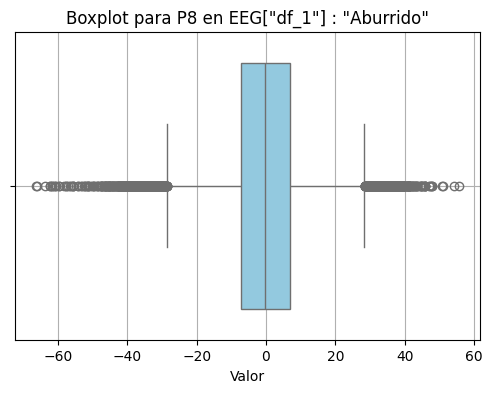

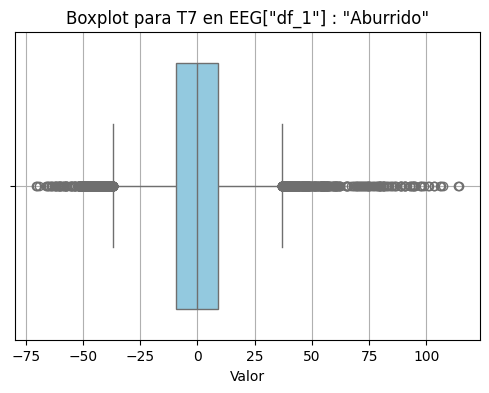

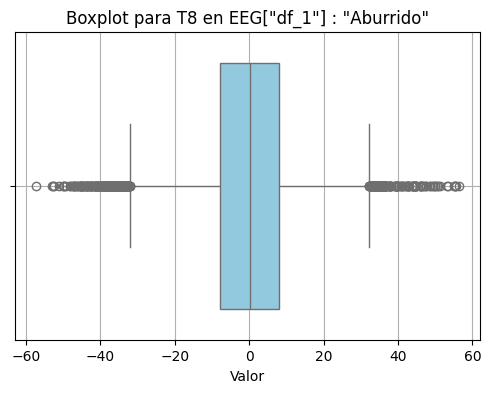

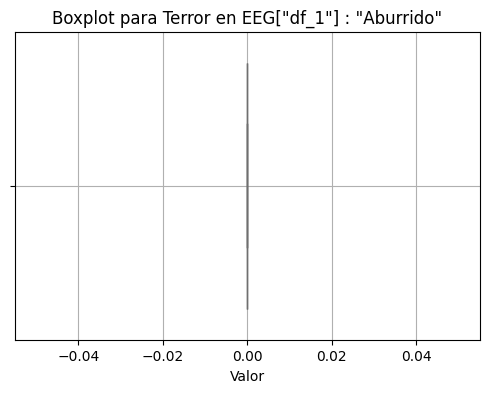

In [ ]:
boxpot_i(EEG['df_1'],'EEG["df_1"] : "Aburrido"')

In [ ]:
Outliers_EEG_1 = detec_outliers_iqr(EEG['df_1'])
Outliers_EEG_1.sum()

AF3        642
AF4       1141
F3        1092
F4         880
F7        1095
F8         308
FC5        763
FC6        293
O1        1418
O2         653
P7         796
P8         815
T7         749
T8         402
Terror       0
dtype: int64

In [ ]:
EEG_T['df_1'] = trat_outliers(EEG['df_1'], Outliers_EEG_1, metodo_out)
EEG_T['df_1'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.016240      0.144695      0.139090      0.114452     -0.019863   
std        9.346771      9.264886     11.437037     11.810109     12.325039   
min      -25.866000    -25.852200    -31.971400    -33.628100    -35.046200   
25%       -6.262350     -5.980325     -7.308175     -7.909850     -8.196900   
50%       -0.033268      0.006082      0.004386     -0.006251     -0.005188   
75%        6.126325      6.072250      7.611000      8.032375      8.199775   
max       25.840000     25.968000     32.109100     33.670100     34.955500   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.072399      0.024159     -0.062012     -0.138630      0.114840   
std       13.154485     14.146753     13.862363     14.891996     16.378975   
min      -37.123500    -40.347200    -38.569800    -42.052600    -45.667400   
25%       -9.235175     -9.623250     -9.465425     -9.775500    -10.873025   
50%       -0.021498     -0.016589     -0.007672     -0.029628      0.005387   
75%        9.019325      9.684200      9.534225      9.397125     11.119450   
max       37.077900     40.369700     38.663500     41.833500     45.854700   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean      -0.098527      0.042830     -0.020349      0.087639      0.0  
std       18.537167     10.195782     13.135592     11.416442      0.0  
min      -51.687900    -28.529900    -36.748000    -32.014500      0.0  
25%      -12.316075     -6.847850     -8.784375     -7.668375      0.0  
50%        0.000706      0.001598      0.032812      0.137465      0.0  
75%       12.196625      6.710175      8.759325      8.023350      0.0  
max       51.475400     28.415300     36.763800     32.231100      0.0

In [ ]:
EEG_T['df_1'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4         F3         F4         F7         F8  \
mean  -0.016240   0.144695   0.139090   0.114452  -0.019863  -0.072399   
std    9.346771   9.264886  11.437037  11.810109  12.325039  13.154485   
min  -25.866000 -25.852200 -31.971400 -33.628100 -35.046200 -37.123500   
max   25.840000  25.968000  32.109100  33.670100  34.955500  37.077900   

            FC5        FC6         O1         O2         P7         P8  \
mean   0.024159  -0.062012  -0.138630   0.114840  -0.098527   0.042830   
std   14.146753  13.862363  14.891996  16.378975  18.537167  10.195782   
min  -40.347200 -38.569800 -42.052600 -45.667400 -51.687900 -28.529900   
max   40.369700  38.663500  41.833500  45.854700  51.475400  28.415300   

             T7         T8  Terror  
mean  -0.020349   0.087639     0.0  
std   13.135592  11.416442     0.0  
min  -36.748000 -32.014500     0.0  
max   36.763800  32.231100     0.0

### Tranquilo (EEG['df_2'])

In [ ]:
EEG['df_2'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.010348      0.003081      0.024055     -0.011135     -0.012513   
std        8.435665      8.710642     10.530741     11.277891     11.280667   
min      -34.000700    -54.162900   -104.615400    -50.661800    -78.227000   
25%       -5.693050     -5.032975     -5.945000     -7.362425     -7.584625   
50%       -0.089878     -0.231915     -0.057201     -0.041391     -0.089552   
75%        5.574650      5.011125      6.224425      7.299300      7.330325   
max       46.518000     48.431300    112.040400     49.692000     53.301600   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.047286     -0.032123      0.007634     -0.035383      0.023373   
std       12.792339     15.082659     12.877539     19.269182     17.016385   
min      -55.799200    -69.174300    -52.975900    -78.090400    -96.621000   
25%       -8.947425    -10.223775     -8.932700    -12.313525    -11.146475   
50%        0.099349      0.298160     -0.445765     -0.388115      0.038054   
75%        9.017525     10.447125      8.582300     11.824750     11.167125   
max       55.634300     67.110600     67.156400     80.092700     64.435700   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.000857      0.001252      0.005896     -0.006501      0.0  
std       21.410227     11.982397     17.391893      9.117402      0.0  
min     -124.313000    -53.204800   -136.875800    -47.028800      0.0  
25%      -12.998950     -8.163050     -8.344325     -5.985250      0.0  
50%       -0.421765     -0.366080      0.304755      0.089040      0.0  
75%       12.821850      7.880350      8.460425      6.037950      0.0  
max      202.074900     54.132800    226.865200     42.087000      0.0

In [ ]:
EEG['df_2'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4          F3         F4         F7         F8  \
mean   0.010348   0.003081    0.024055  -0.011135  -0.012513  -0.047286   
std    8.435665   8.710642   10.530741  11.277891  11.280667  12.792339   
min  -34.000700 -54.162900 -104.615400 -50.661800 -78.227000 -55.799200   
max   46.518000  48.431300  112.040400  49.692000  53.301600  55.634300   

            FC5        FC6         O1         O2          P7         P8  \
mean  -0.032123   0.007634  -0.035383   0.023373    0.000857   0.001252   
std   15.082659  12.877539  19.269182  17.016385   21.410227  11.982397   
min  -69.174300 -52.975900 -78.090400 -96.621000 -124.313000 -53.204800   
max   67.110600  67.156400  80.092700  64.435700  202.074900  54.132800   

              T7         T8  Terror  
mean    0.005896  -0.006501     0.0  
std    17.391893   9.117402     0.0  
min  -136.875800 -47.028800     0.0  
max   226.865200  42.087000     0.0

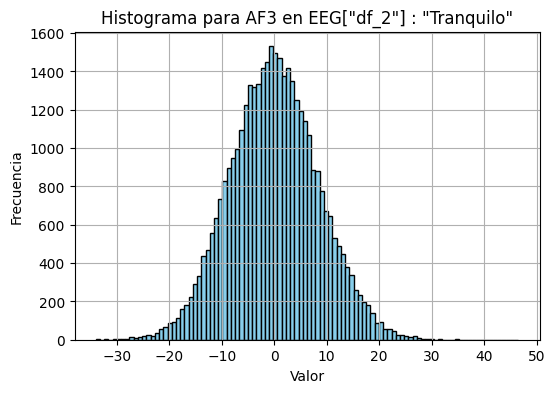

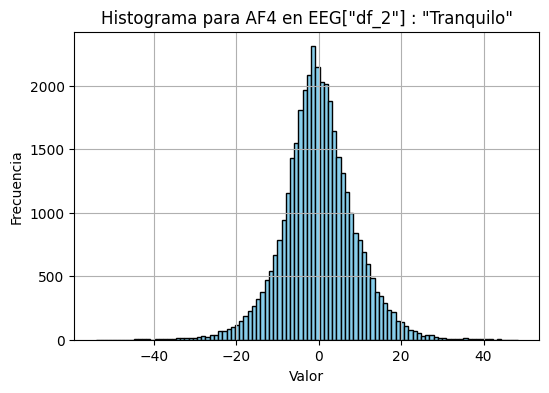

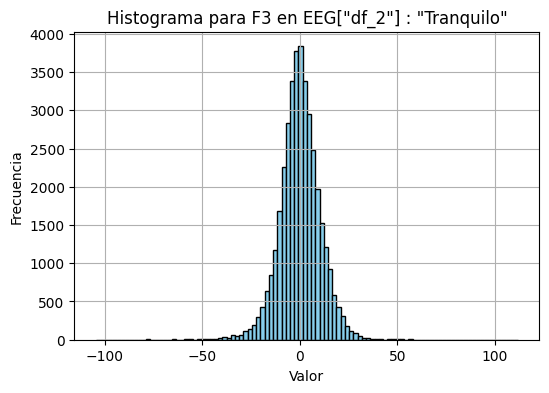

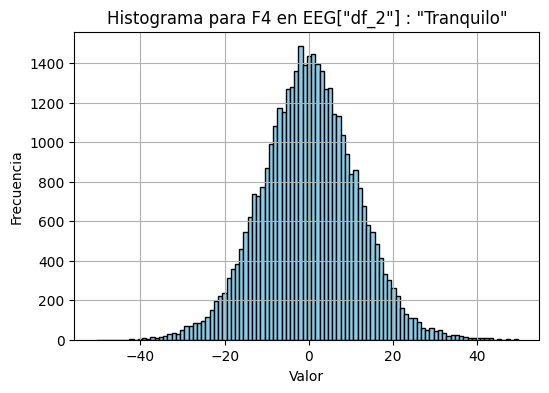

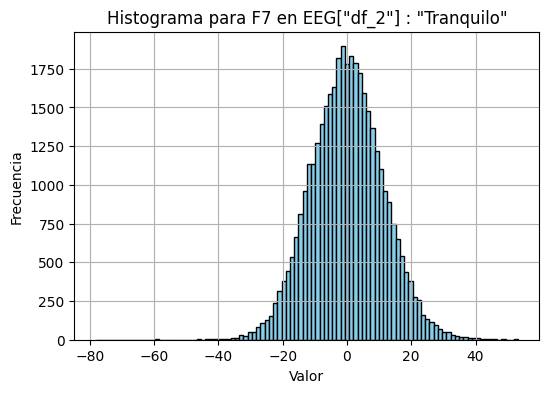

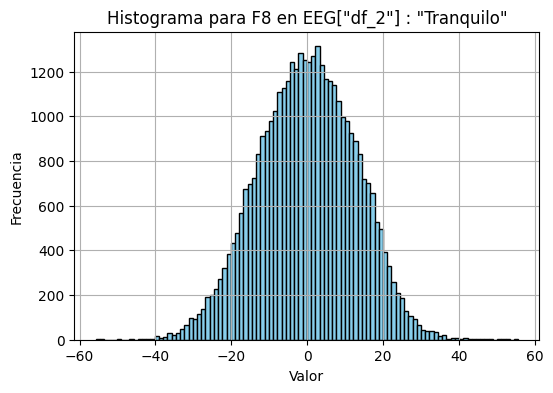

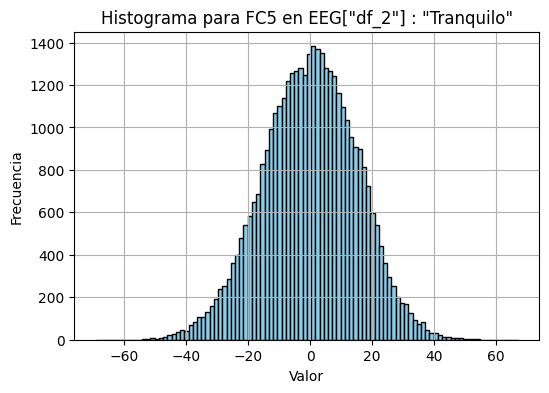

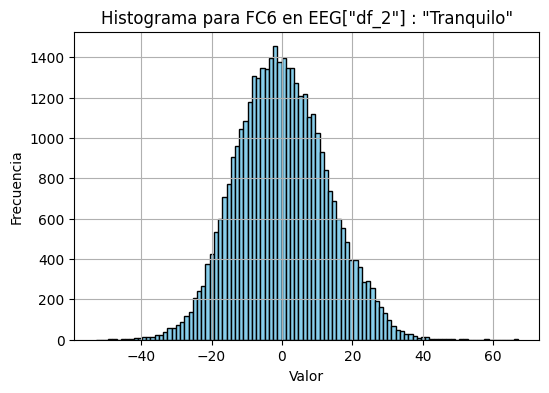

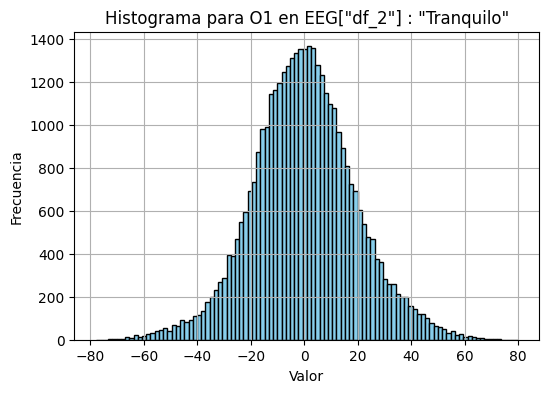

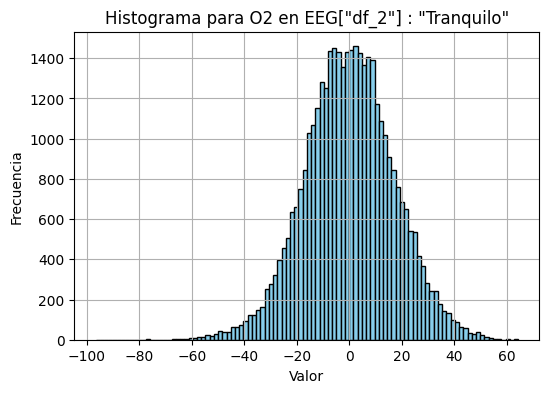

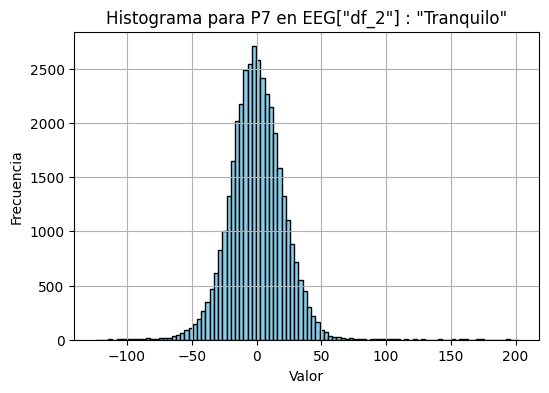

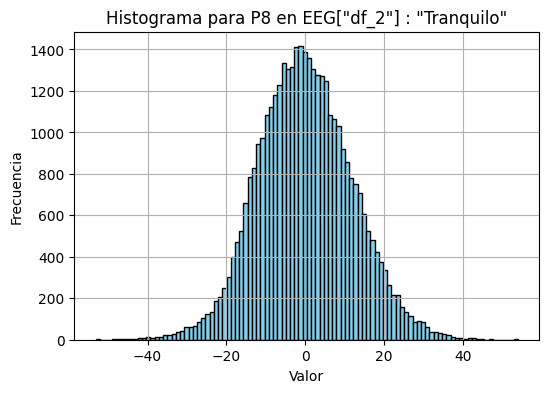

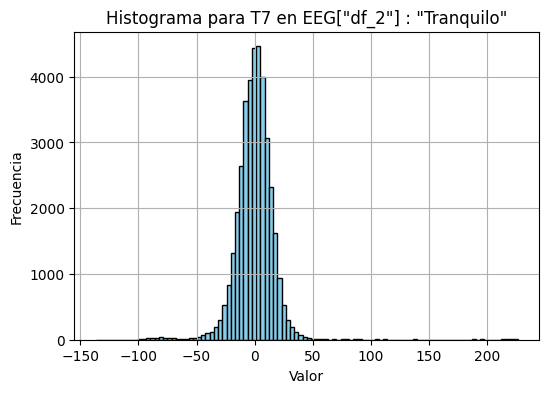

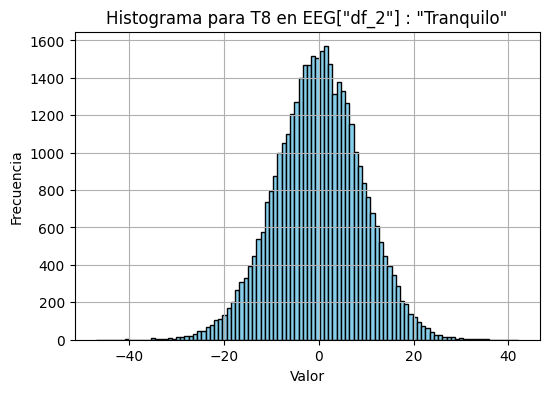

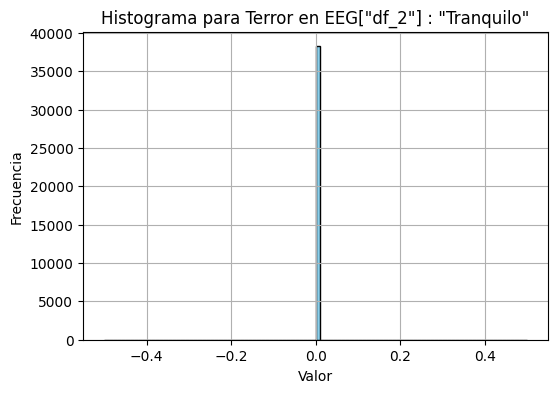

In [ ]:
hist(EEG['df_2'],'EEG["df_2"] : "Tranquilo"')

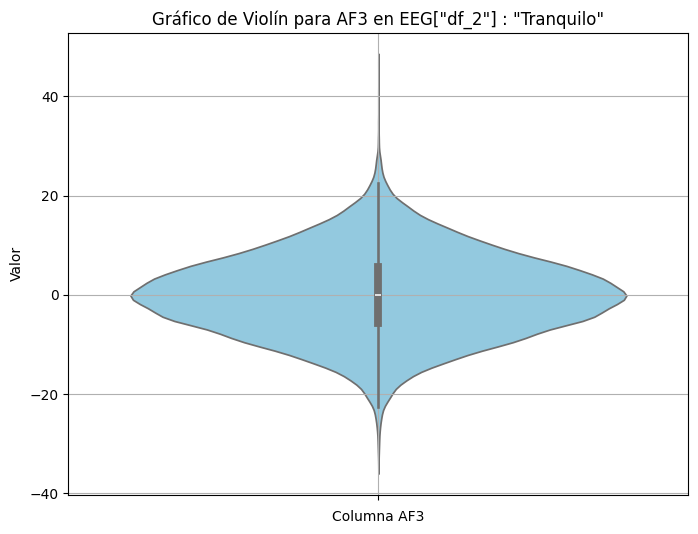

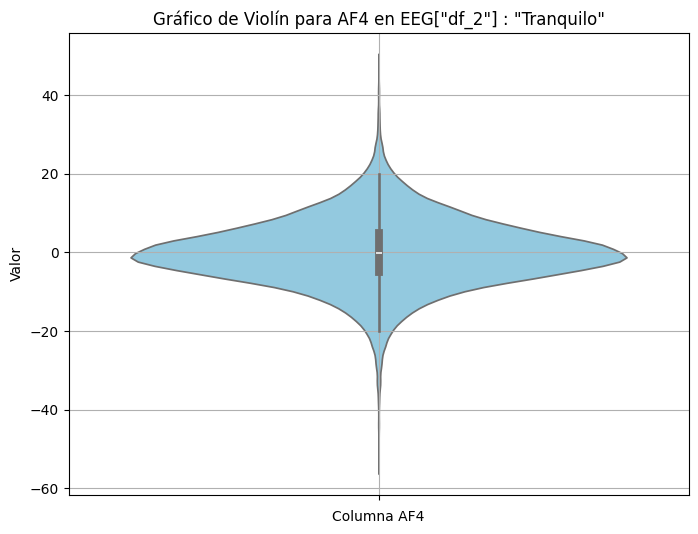

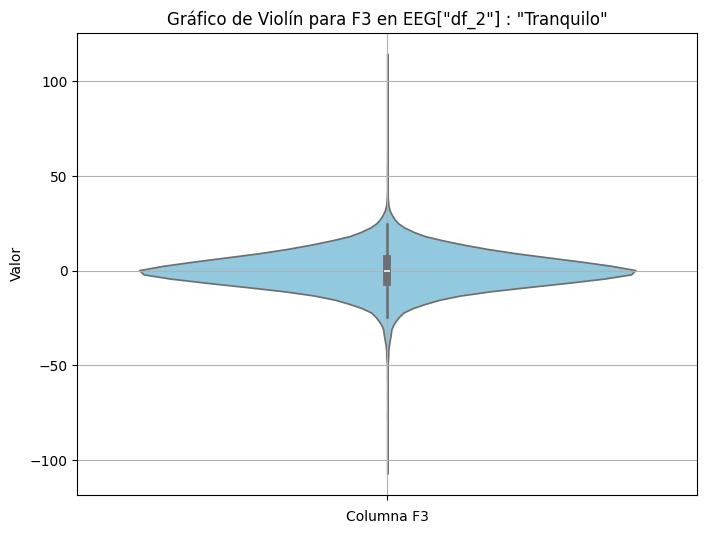

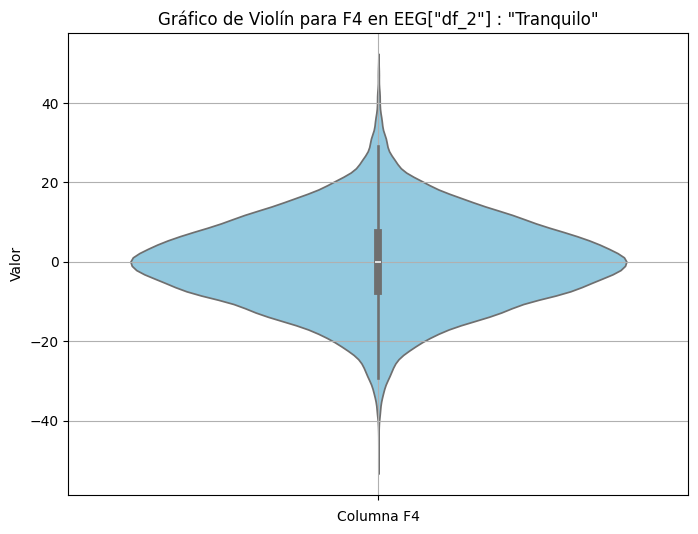

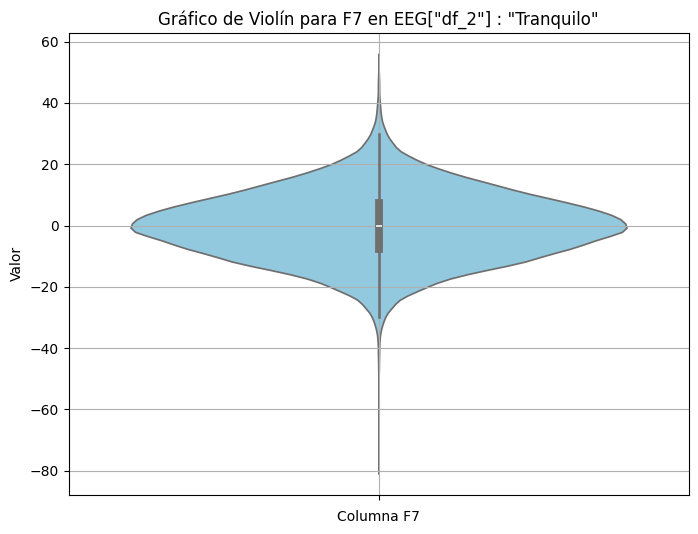

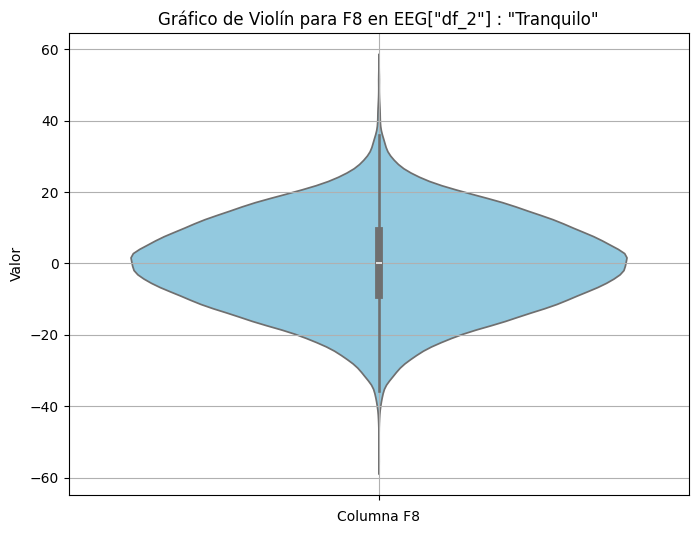

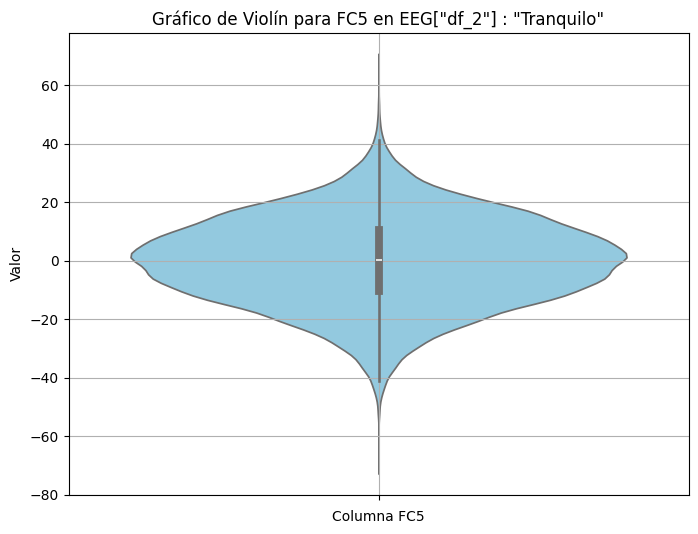

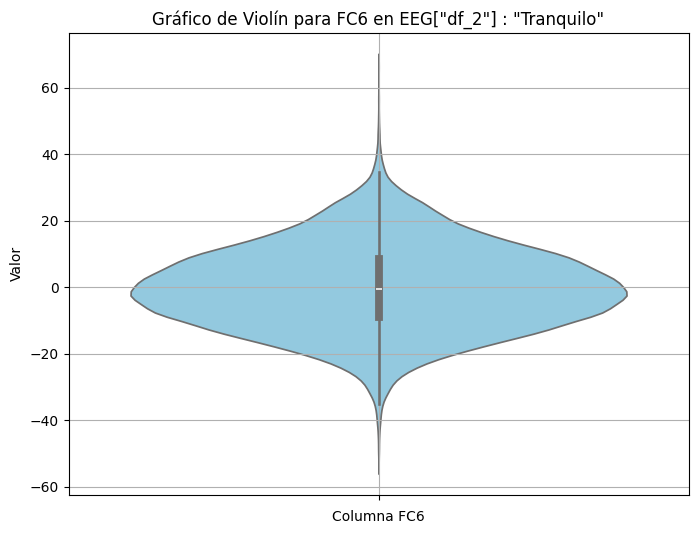

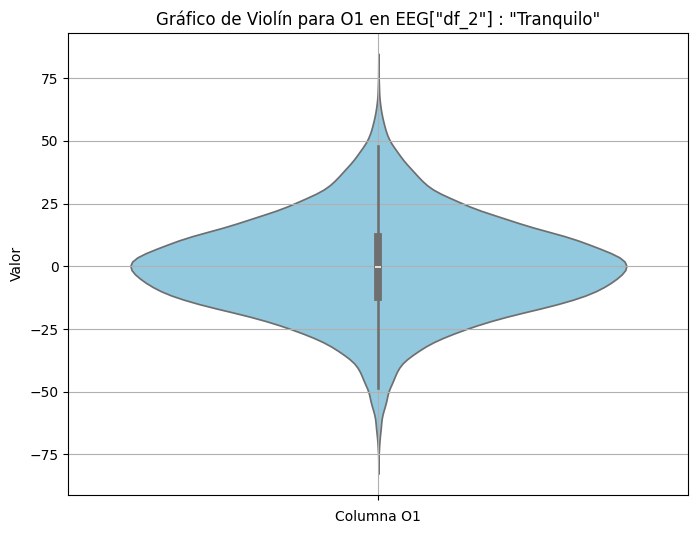

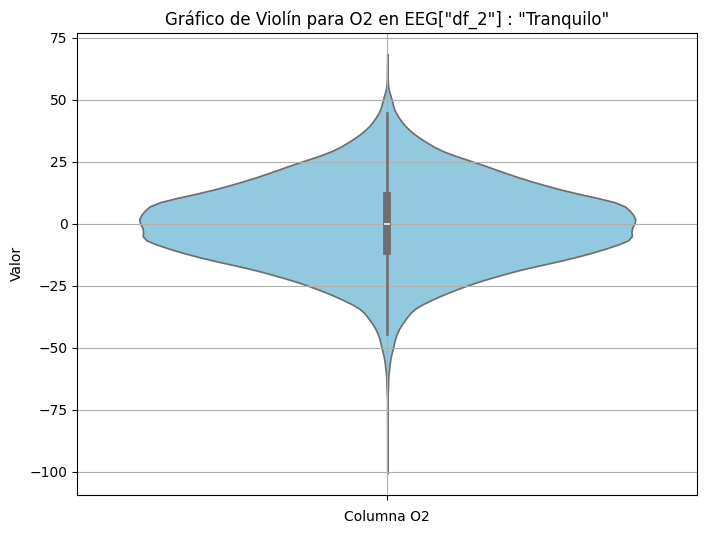

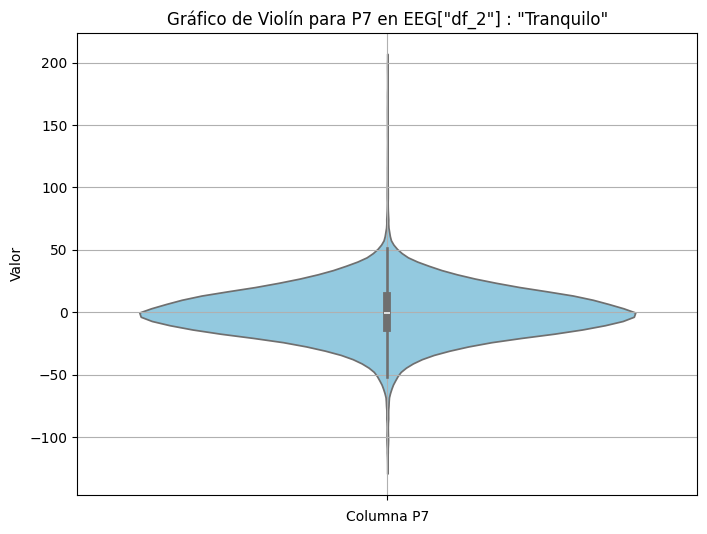

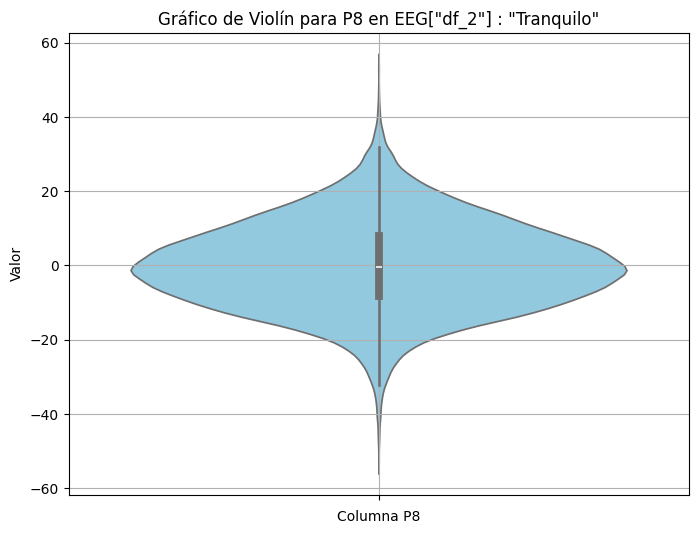

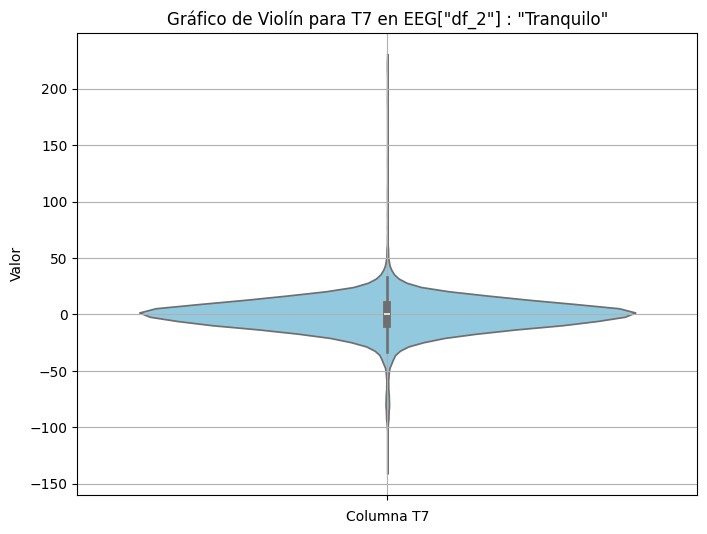

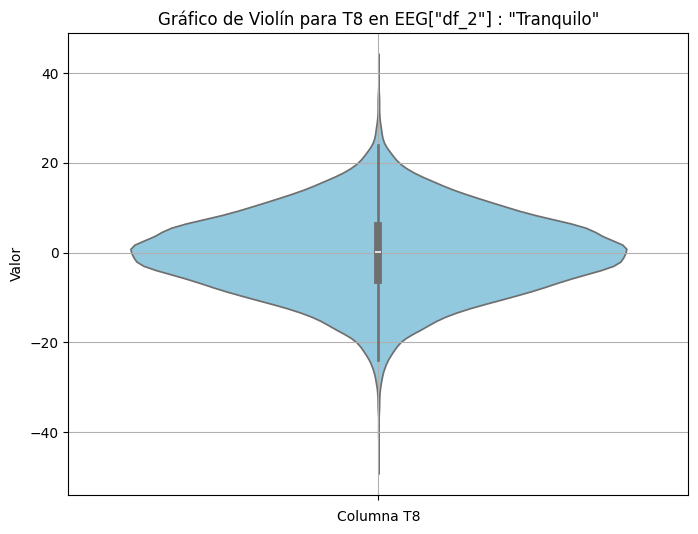

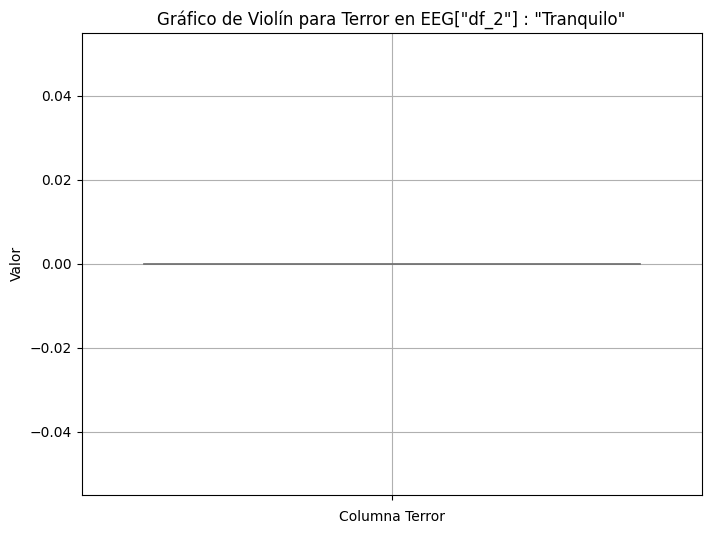

In [ ]:
viol(EEG['df_2'],'EEG["df_2"] : "Tranquilo"')

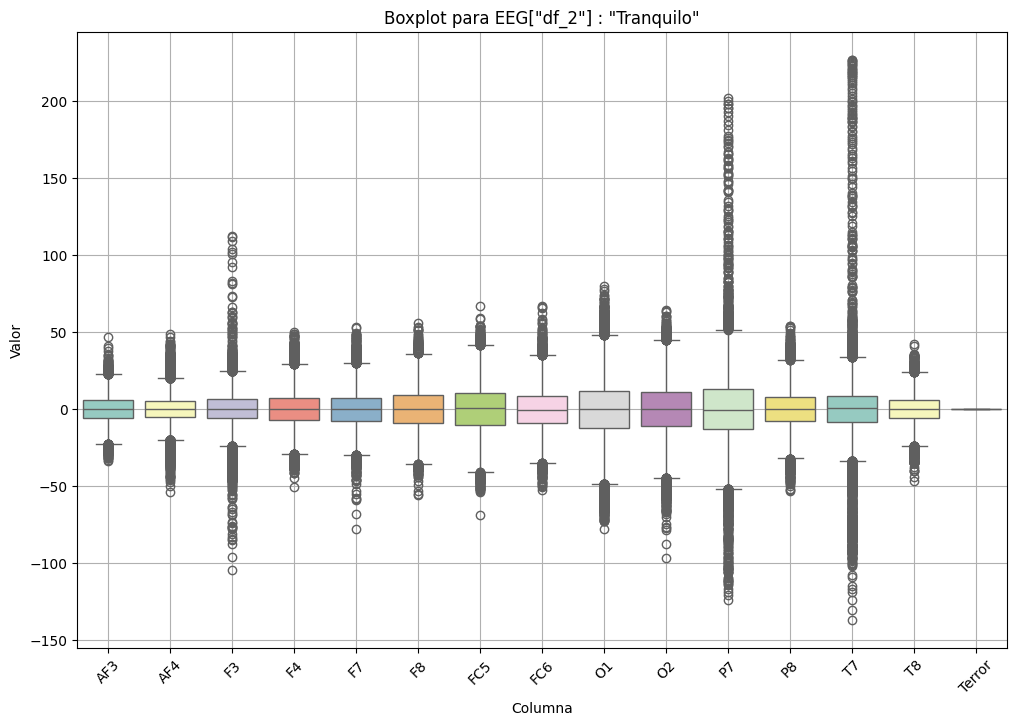

In [ ]:
boxpot_g(EEG['df_2'],'EEG["df_2"] : "Tranquilo"')

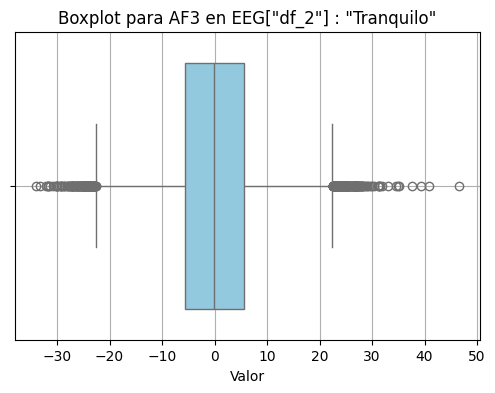

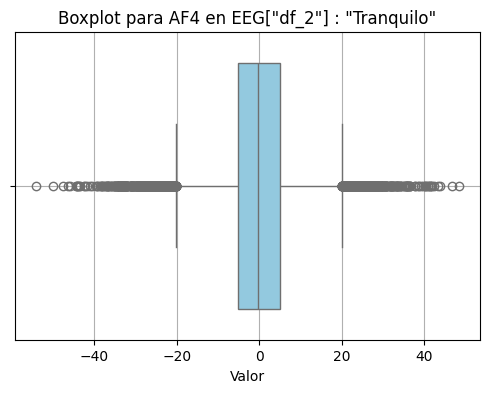

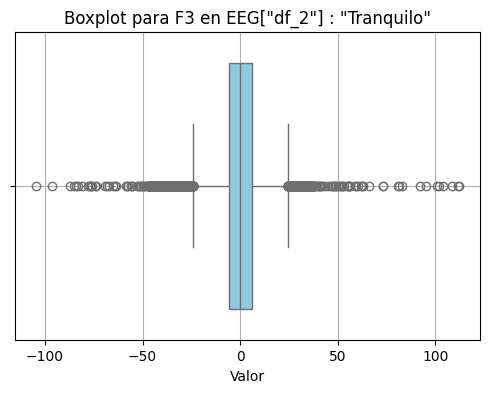

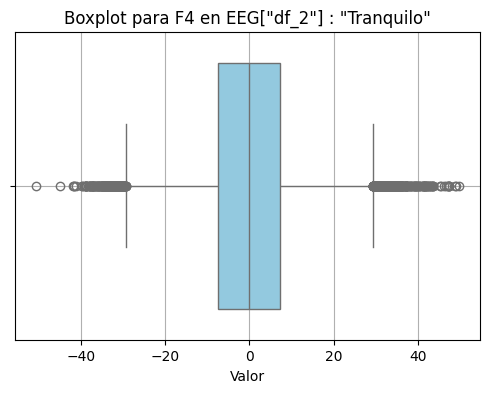

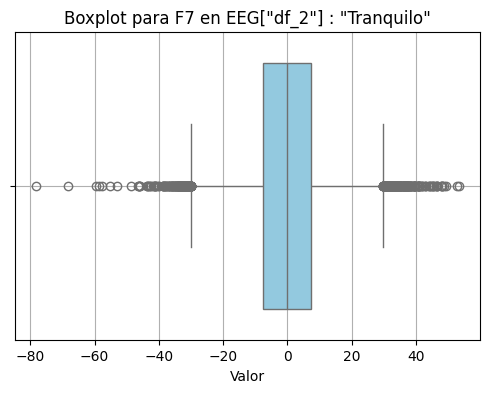

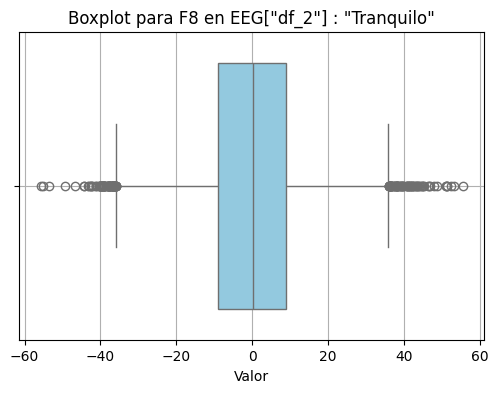

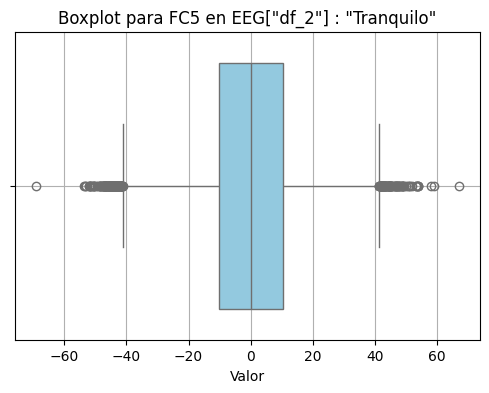

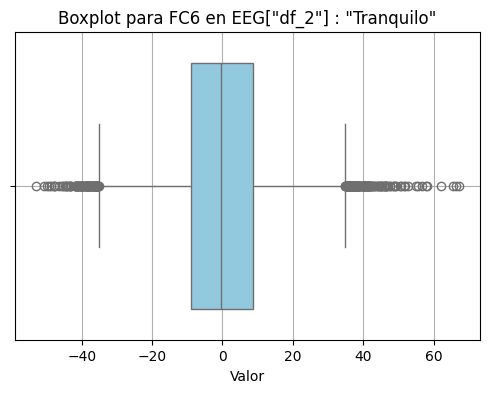

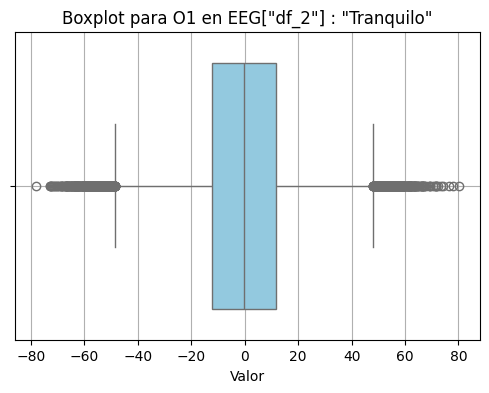

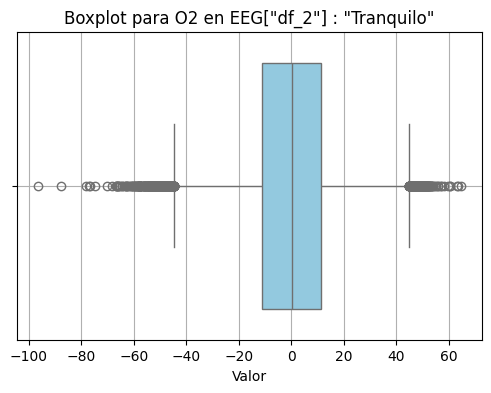

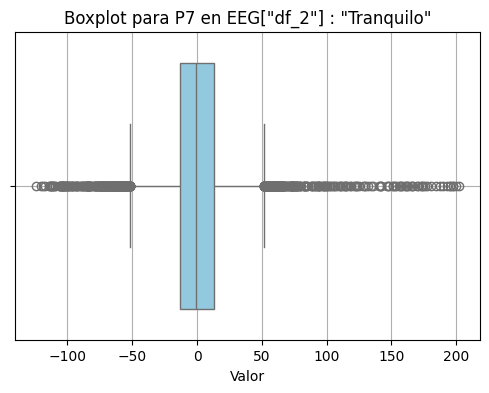

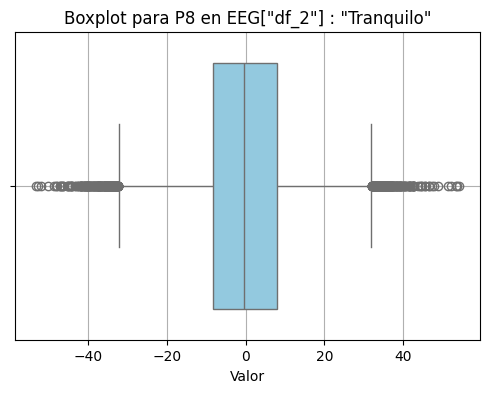

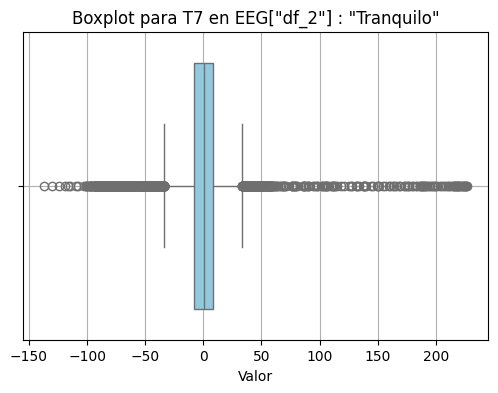

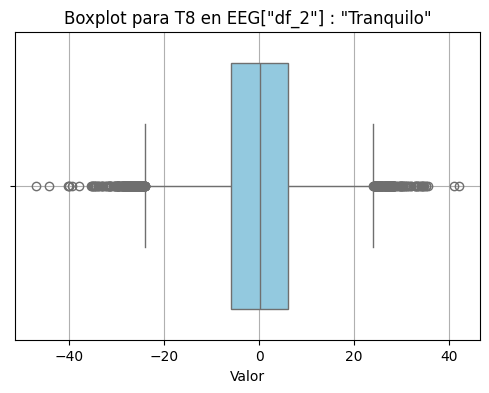

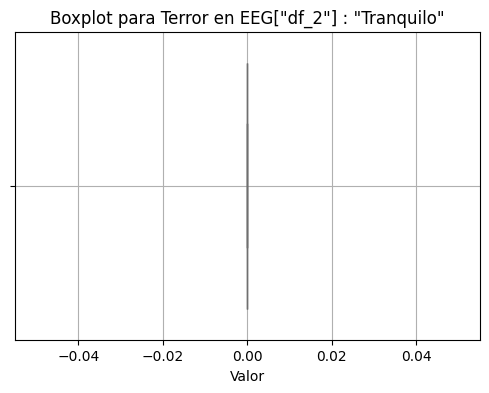

In [ ]:
boxpot_i(EEG['df_2'],'EEG["df_2"] : "Tranquilo"')

In [ ]:
Outliers_EEG_2 = detec_outliers_iqr(EEG['df_2'])
Outliers_EEG_2.sum()

AF3        302
AF4       1213
F3        1027
F4         532
F7         408
F8         150
FC5        234
FC6        257
O1         750
O2         447
P7         706
P8         385
T7        1149
T8         372
Terror       0
dtype: int64

In [ ]:
EEG_T['df_2'] = trat_outliers(EEG['df_2'], Outliers_EEG_2, metodo_out)
EEG_T['df_2'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.022137      0.019033      0.195162     -0.076395     -0.085764   
std        8.115830      7.405075      8.864025     10.539634     10.666188   
min      -22.541400    -20.090400    -24.195500    -29.354300    -29.946100   
25%       -5.598425     -4.666200     -5.497225     -7.162600     -7.442200   
50%       -0.017012      0.003081      0.024055     -0.011135     -0.012513   
75%        5.460550      4.614900      5.867100      7.033750      7.103125   
max       22.442000     20.066100     24.467400     29.288200     29.687900   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.043464      0.033257     -0.058417     -0.043119      0.187929   
std       12.537152     14.655811     12.435909     17.613770     16.083385   
min      -35.851600    -41.224700    -35.072500    -48.517200    -44.607000   
25%       -8.873475    -10.049725     -8.827800    -11.818750    -10.795225   
50%        0.032164      0.198205     -0.366425     -0.035383      0.023373   
75%        8.946350     10.358650      8.432675     11.264975     10.925925   
max       35.839000     41.410400     34.801900     47.988300     44.596300   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.014502     -0.018645      0.177553      0.049737      0.0  
std       18.502893     11.380349     11.843403      8.690218      0.0  
min      -51.728900    -32.212300    -33.537800    -23.988400      0.0  
25%      -12.389000     -7.986325     -7.629500     -5.807950      0.0  
50%        0.000857     -0.222205      0.005896      0.002094      0.0  
75%       12.335625      7.649650      8.006375      5.945125      0.0  
max       51.536500     31.929000     33.624300     24.061100      0.0

In [ ]:
EEG_T['df_2'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4         F3         F4         F7         F8  \
mean  -0.022137   0.019033   0.195162  -0.076395  -0.085764  -0.043464   
std    8.115830   7.405075   8.864025  10.539634  10.666188  12.537152   
min  -22.541400 -20.090400 -24.195500 -29.354300 -29.946100 -35.851600   
max   22.442000  20.066100  24.467400  29.288200  29.687900  35.839000   

            FC5        FC6         O1         O2         P7         P8  \
mean   0.033257  -0.058417  -0.043119   0.187929   0.014502  -0.018645   
std   14.655811  12.435909  17.613770  16.083385  18.502893  11.380349   
min  -41.224700 -35.072500 -48.517200 -44.607000 -51.728900 -32.212300   
max   41.410400  34.801900  47.988300  44.596300  51.536500  31.929000   

             T7         T8  Terror  
mean   0.177553   0.049737     0.0  
std   11.843403   8.690218     0.0  
min  -33.537800 -23.988400     0.0  
max   33.624300  24.061100     0.0

### Terror (EEG['df_3'])

In [ ]:
EEG['df_3'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.012238      0.002767      0.019254     -0.001795     -0.013598   
std        8.163568      7.785299     10.215578     10.793351     21.811078   
min      -51.624500    -42.290500   -199.866600    -85.737700   -232.493600   
25%       -5.242825     -4.967250     -5.153650     -6.616050     -8.081675   
50%       -0.235490     -0.292325     -0.163535     -0.047261     -0.069584   
75%        5.078025      4.891300      5.133575      6.579800      7.916000   
max       52.543400     46.295800    157.404800     62.179000    234.309400   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.056348     -0.023206      0.007840     -0.029163      0.010864   
std       13.342254     13.531302     11.266943     19.665981     15.349070   
min     -103.468500    -74.049200    -54.264900   -144.528500    -83.358600   
25%       -9.035550     -9.086725     -7.960525    -11.263025     -9.852900   
50%        0.093599     -0.023168     -0.261150     -0.142290     -0.146275   
75%        8.888050      8.971500      7.442725     11.087550      9.813875   
max       95.311600     79.831900     58.983800    124.113300     74.199100   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean      -0.002429      0.002302      0.006091     -0.005091      1.0  
std       18.590737     11.565934     11.185907      7.905062      0.0  
min     -132.520700    -71.560600   -125.802000    -39.073000      1.0  
25%      -10.651200     -7.866950     -6.100025     -4.929500      1.0  
50%       -0.497750     -0.419260      0.282615      0.012872      1.0  
75%       10.362600      7.321700      6.493525      5.024150      1.0  
max      221.220400     83.173400     94.586700     43.127600      1.0

In [ ]:
EEG['df_3'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4          F3         F4          F7          F8  \
mean   0.012238   0.002767    0.019254  -0.001795   -0.013598   -0.056348   
std    8.163568   7.785299   10.215578  10.793351   21.811078   13.342254   
min  -51.624500 -42.290500 -199.866600 -85.737700 -232.493600 -103.468500   
max   52.543400  46.295800  157.404800  62.179000  234.309400   95.311600   

            FC5        FC6          O1         O2          P7         P8  \
mean  -0.023206   0.007840   -0.029163   0.010864   -0.002429   0.002302   
std   13.531302  11.266943   19.665981  15.349070   18.590737  11.565934   
min  -74.049200 -54.264900 -144.528500 -83.358600 -132.520700 -71.560600   
max   79.831900  58.983800  124.113300  74.199100  221.220400  83.173400   

              T7         T8  Terror  
mean    0.006091  -0.005091     1.0  
std    11.185907   7.905062     0.0  
min  -125.802000 -39.073000     1.0  
max    94.586700  43.127600     1.0

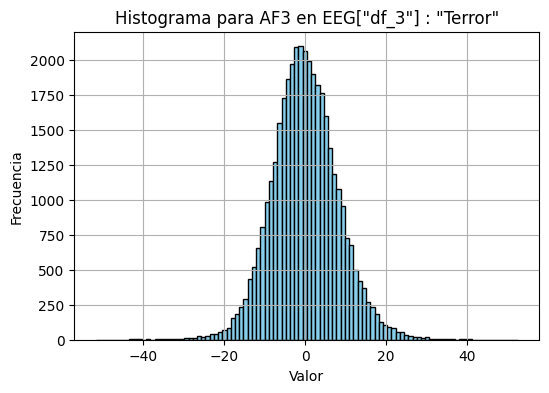

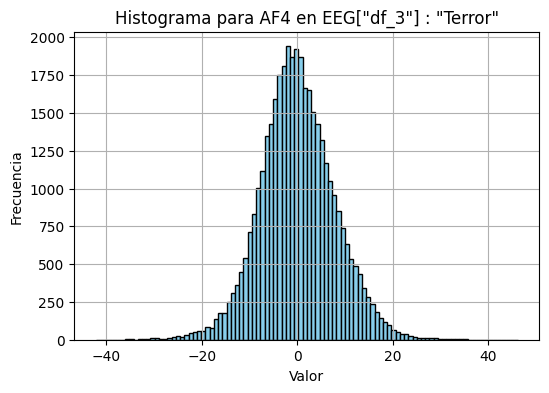

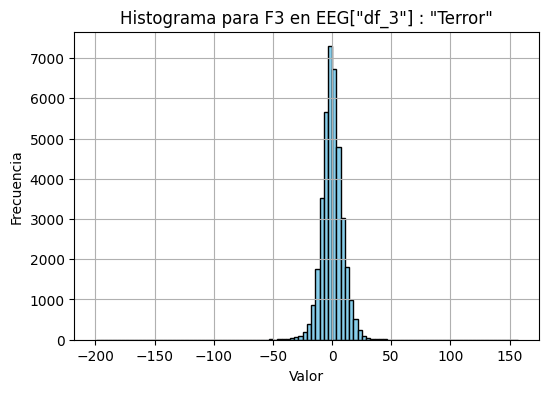

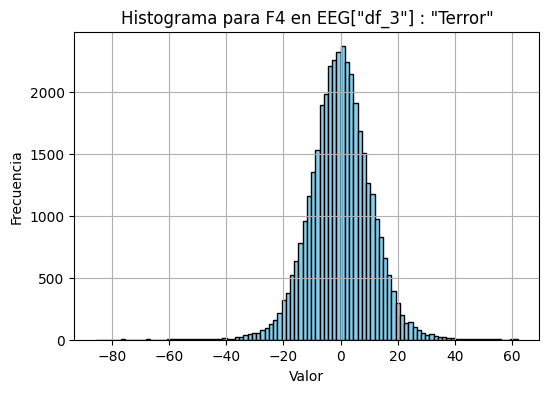

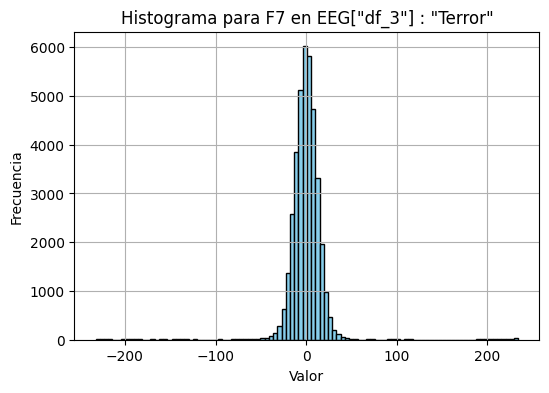

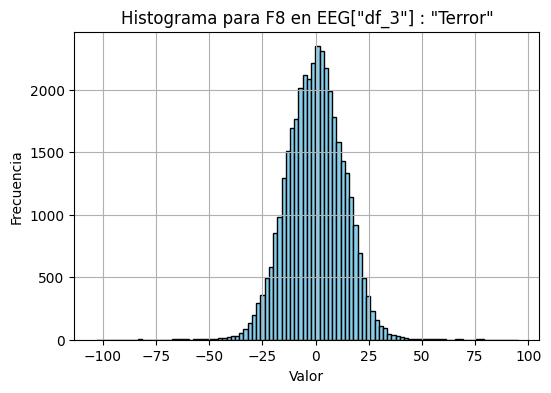

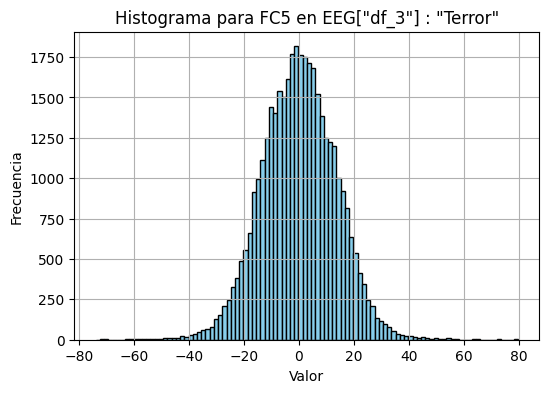

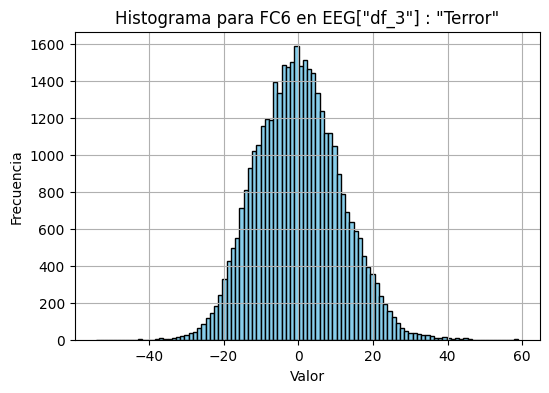

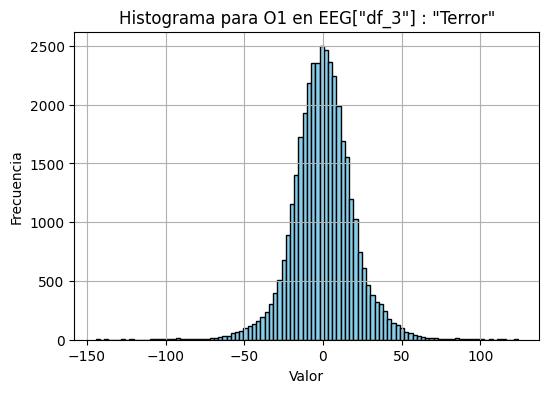

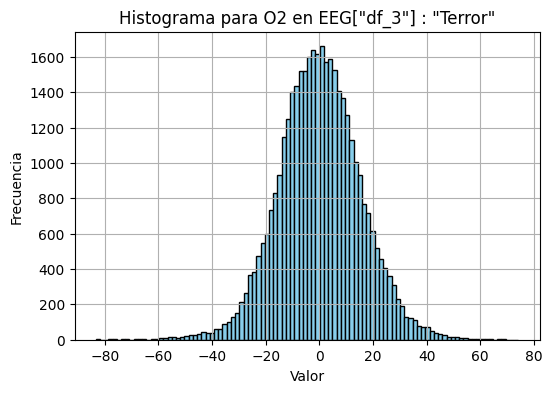

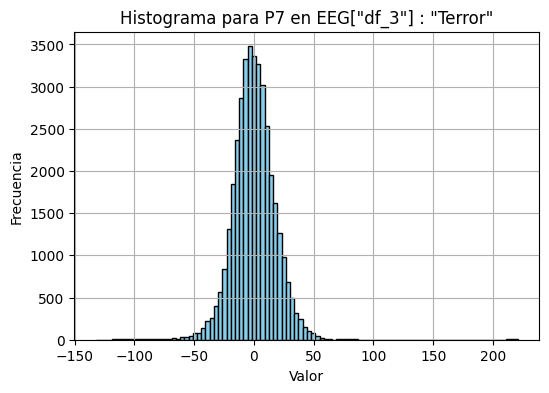

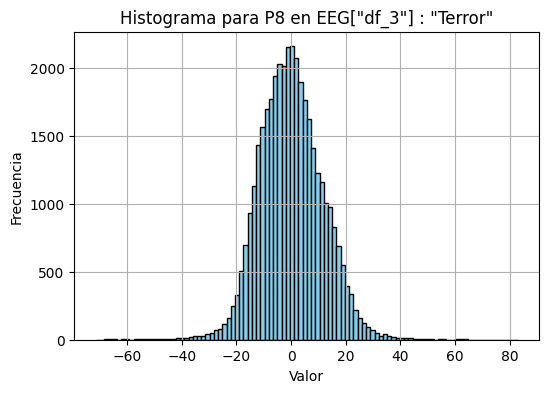

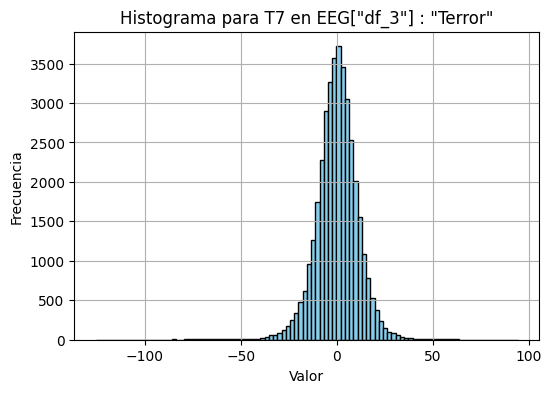

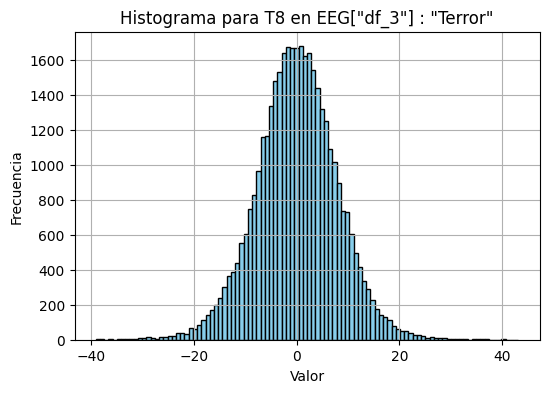

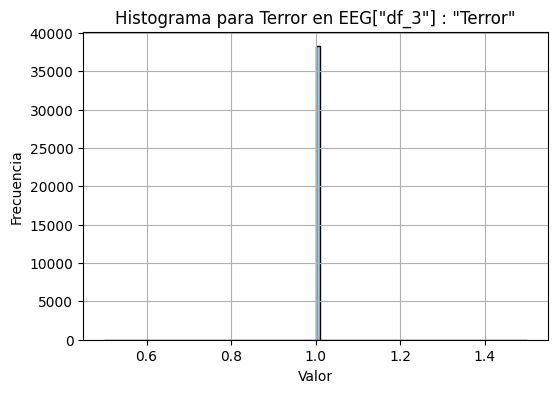

In [ ]:
hist(EEG['df_3'],'EEG["df_3"] : "Terror"')

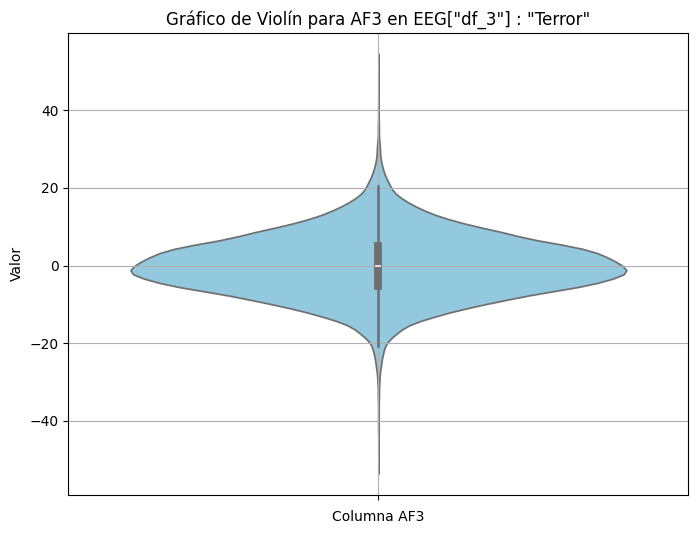

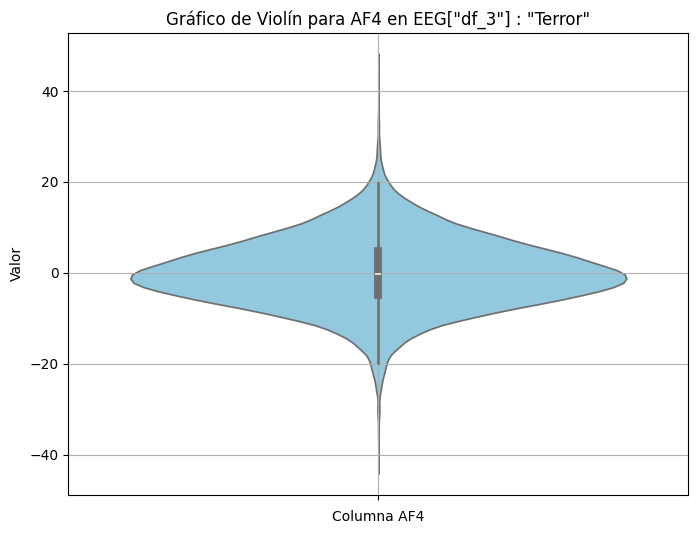

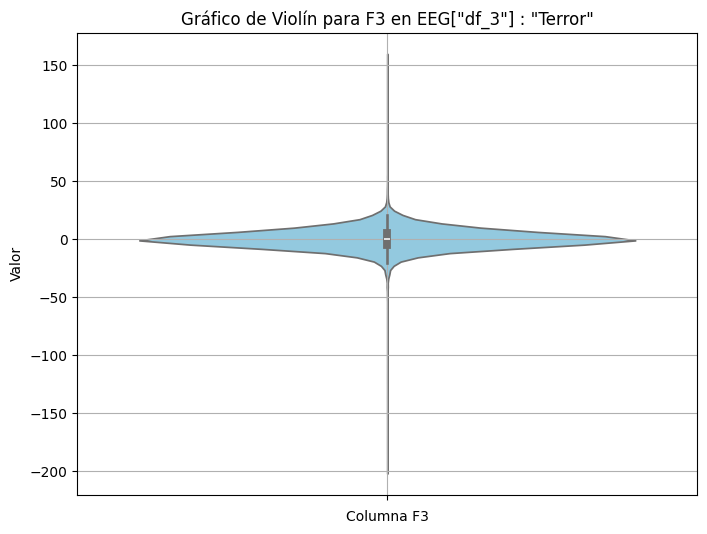

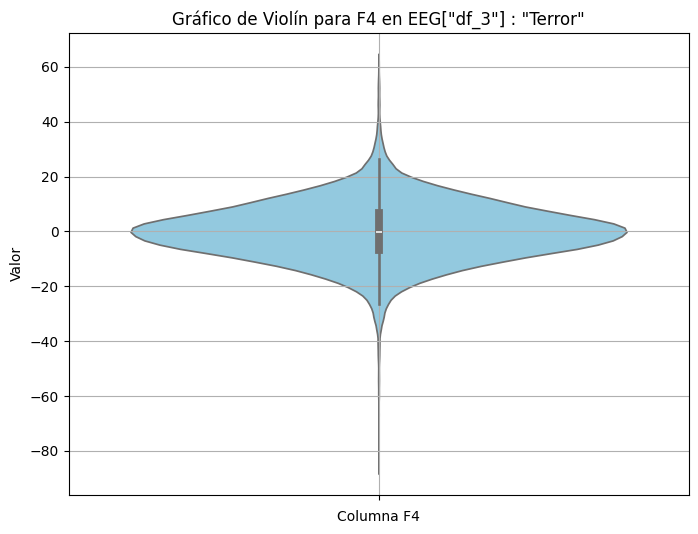

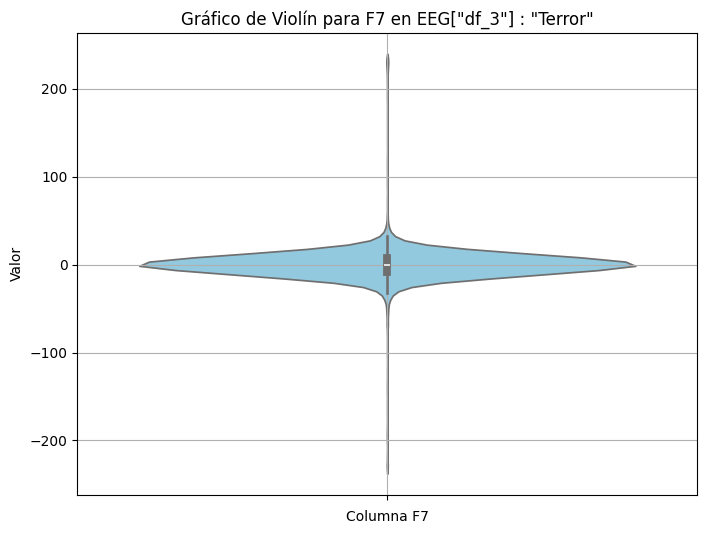

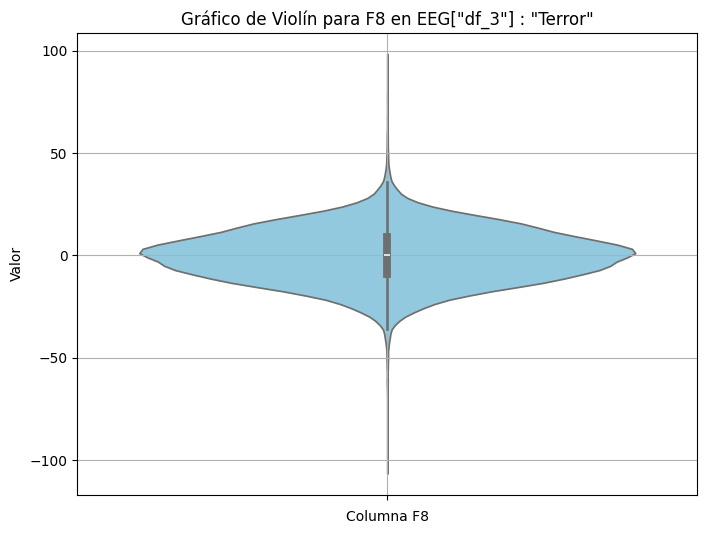

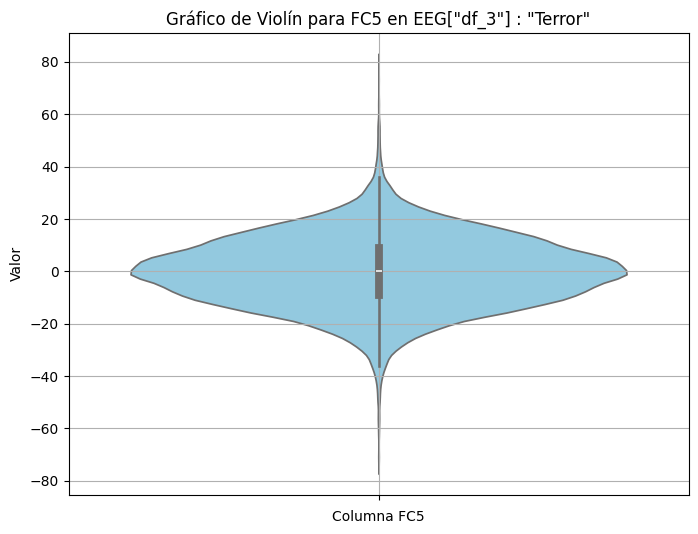

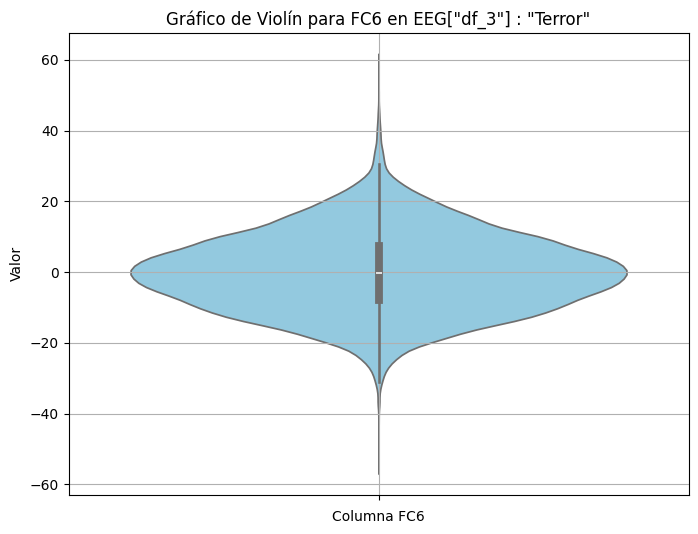

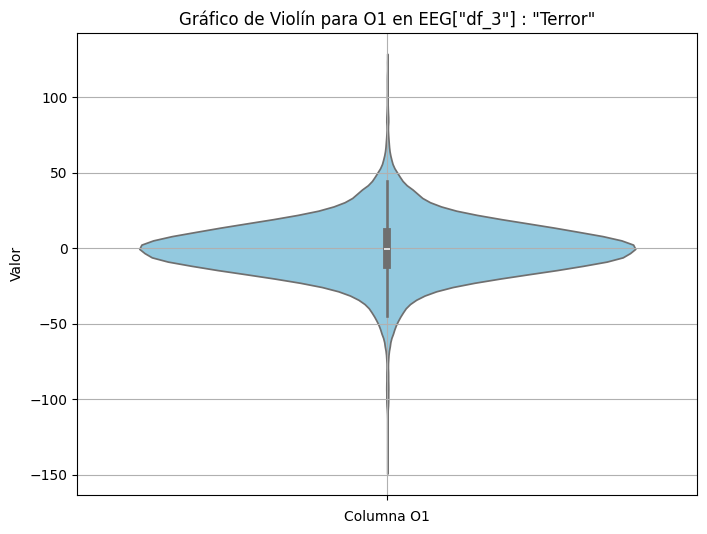

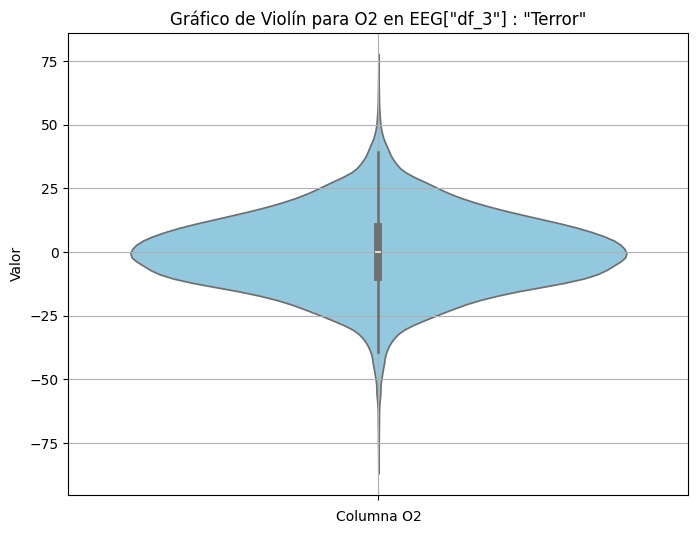

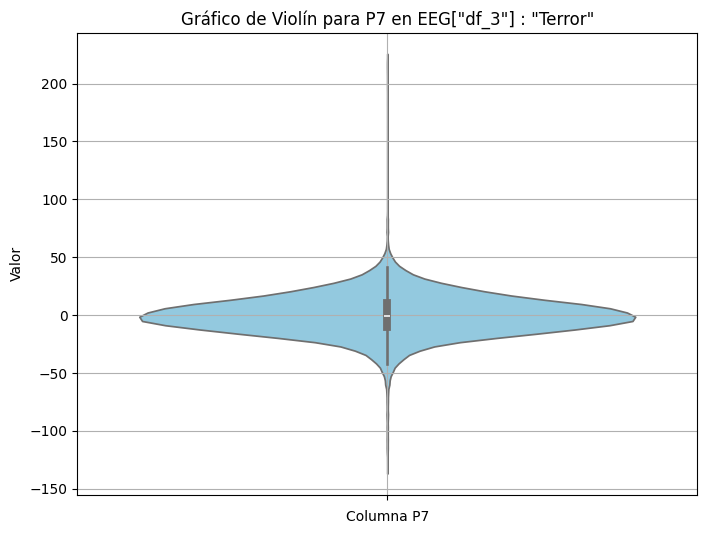

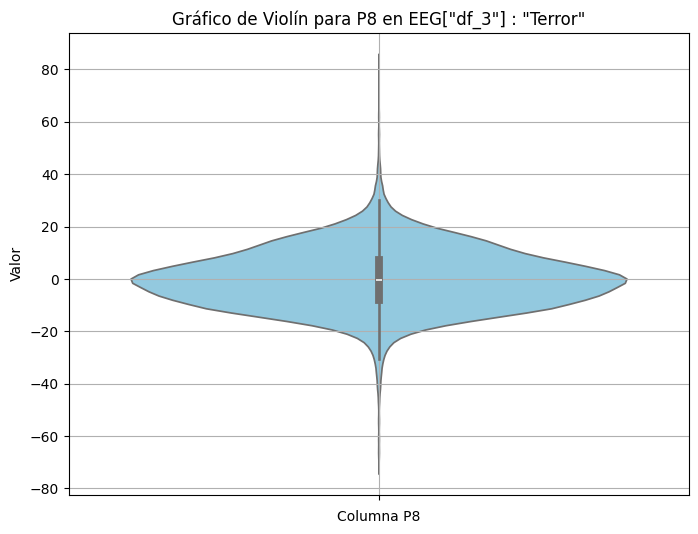

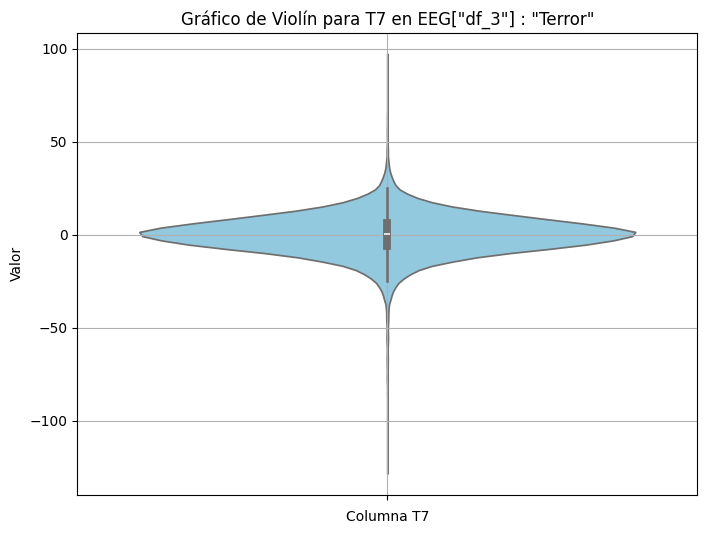

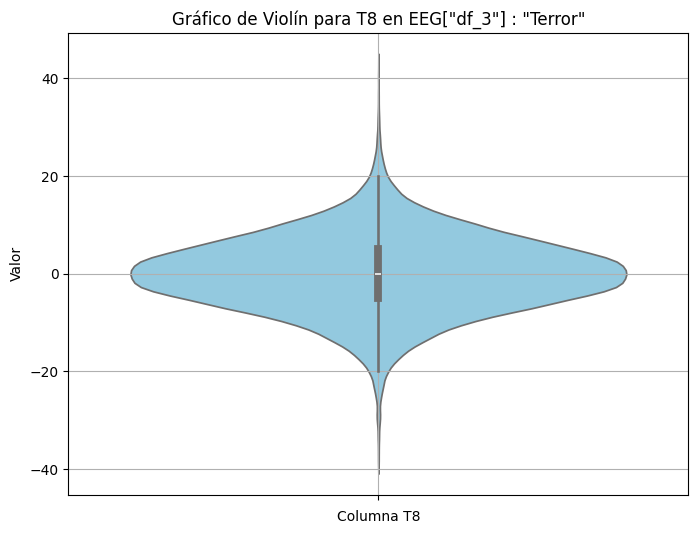

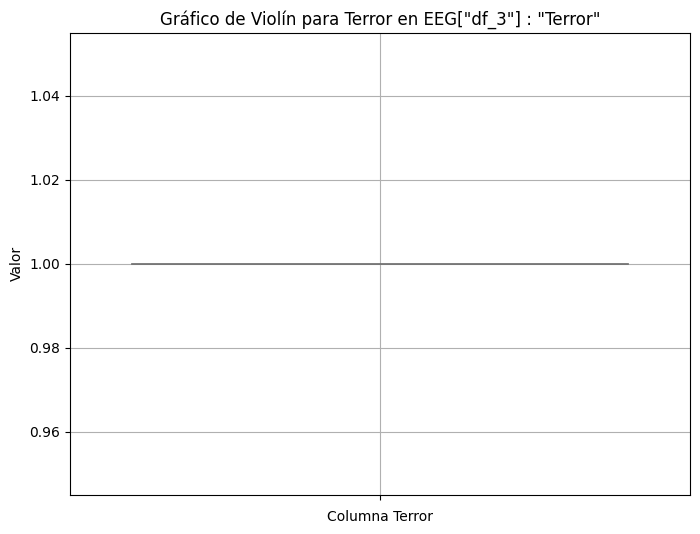

In [ ]:
viol(EEG['df_3'],'EEG["df_3"] : "Terror"')

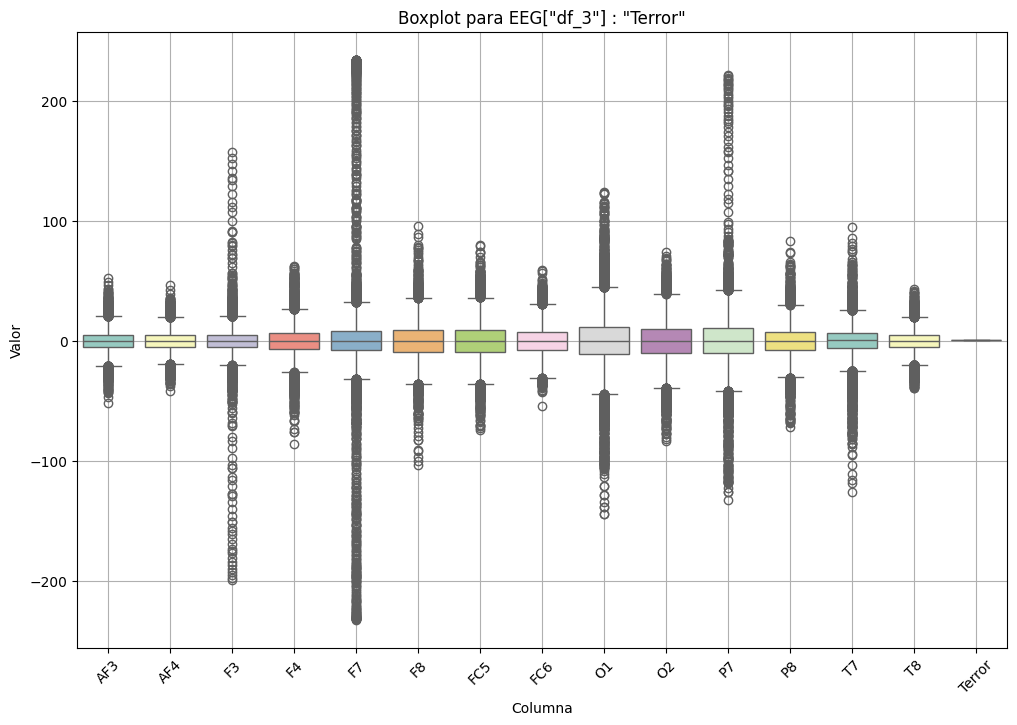

In [ ]:
boxpot_g(EEG['df_3'],'EEG["df_3"] : "Terror"')

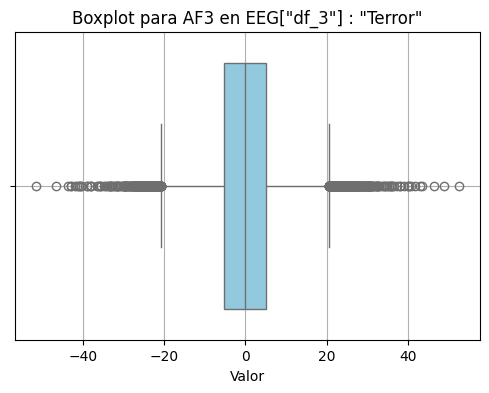

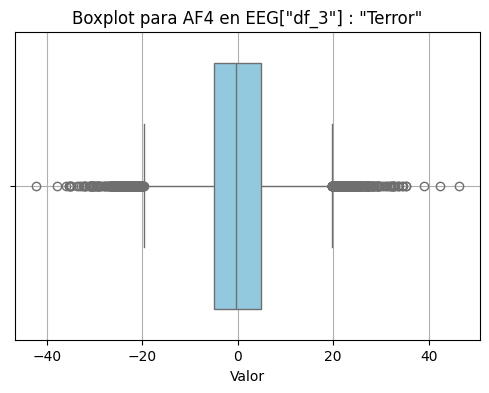

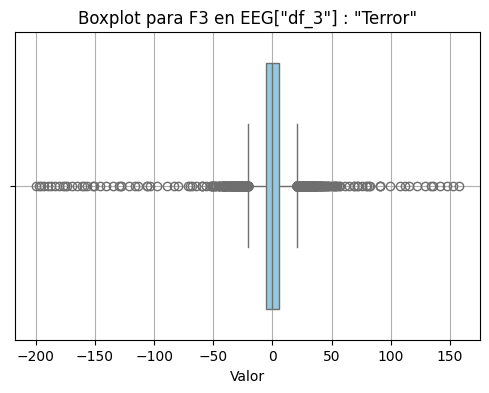

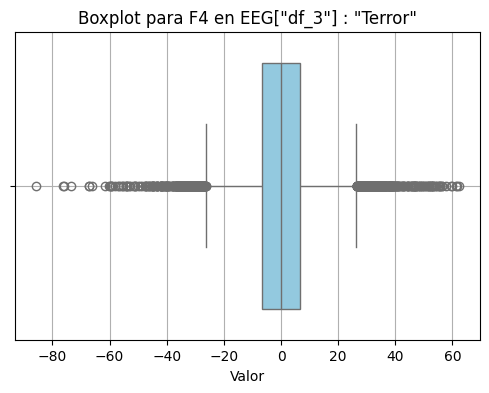

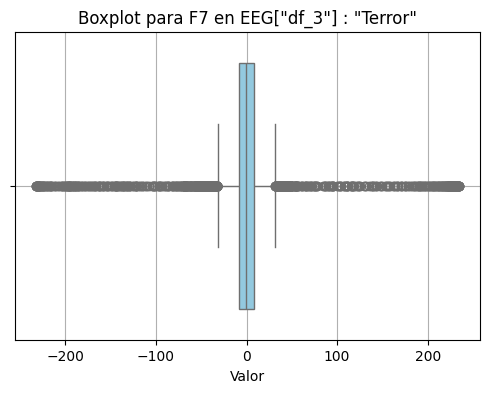

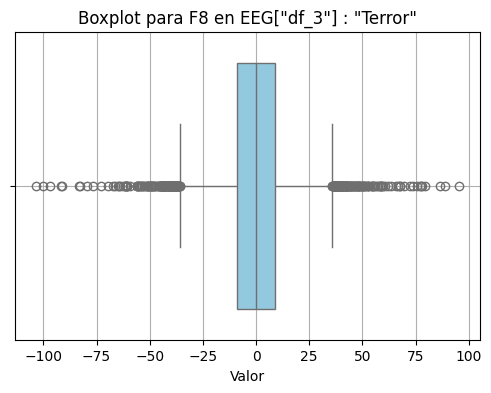

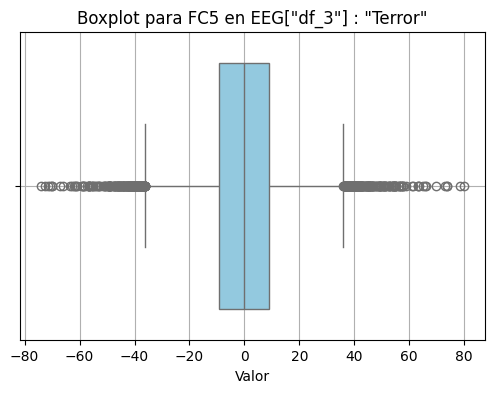

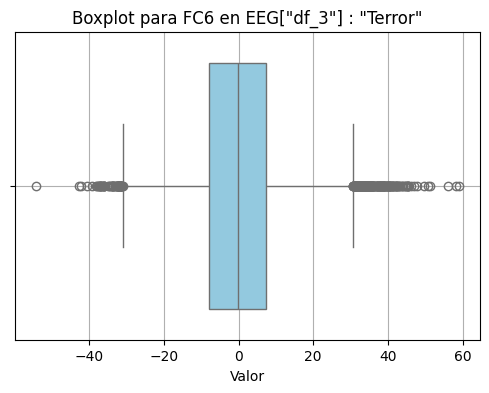

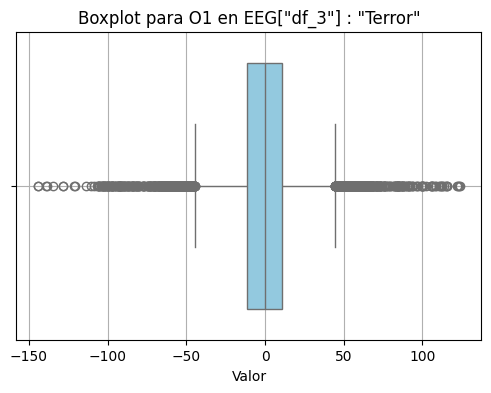

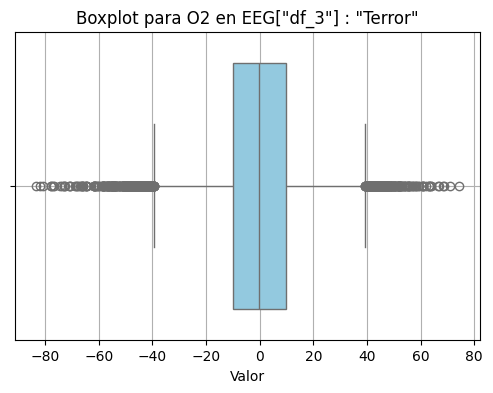

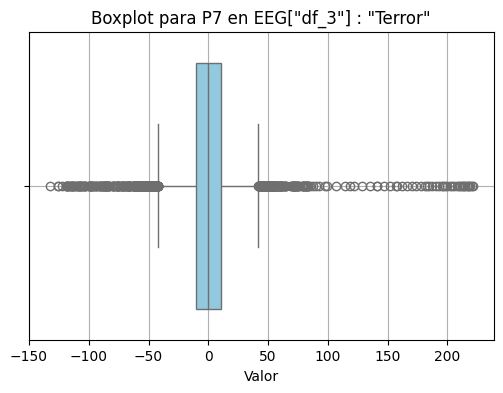

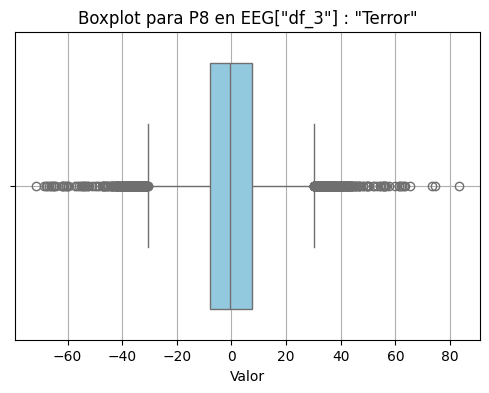

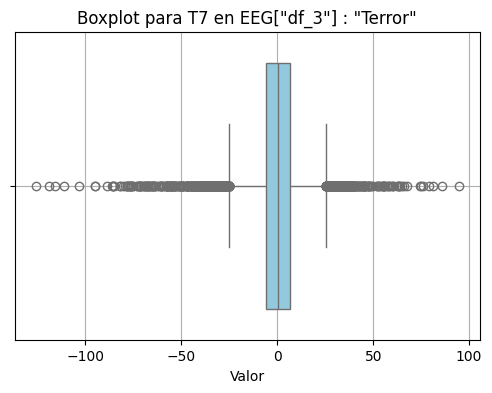

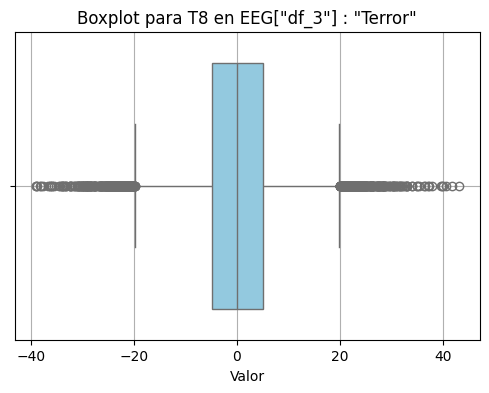

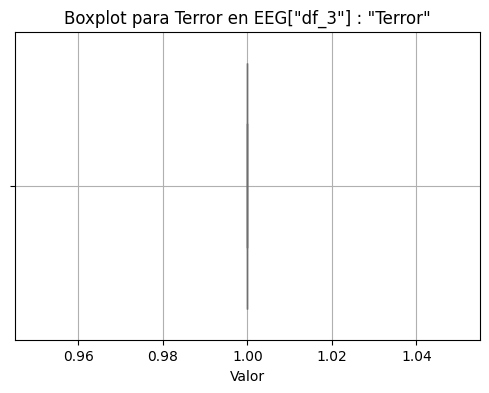

In [ ]:
boxpot_i(EEG['df_3'],'EEG["df_3"] : "Terror"')

In [ ]:
Outliers_EEG_3 = detec_outliers_iqr(EEG['df_3'])
Outliers_EEG_3.sum()

AF3        684
AF4        653
F3        1105
F4         818
F7        1023
F8         321
FC5        427
FC6        278
O1        1322
O2         636
P7         915
P8         510
T7        1138
T8         681
Terror       0
dtype: int64

In [ ]:
EEG_T['df_3'] = trat_outliers(EEG['df_3'], Outliers_EEG_3, metodo_out)
EEG_T['df_3'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.081540      0.006836      0.030766     -0.002857     -0.072600   
std        7.390349      7.125568      7.486495      9.483319     11.174598   
min      -20.699100    -19.748000    -20.578300    -26.386900    -32.025500   
25%       -5.087500     -4.783025     -4.837475     -6.275500     -7.521425   
50%       -0.106800     -0.143535      0.019254     -0.001795     -0.013598   
75%        4.799750      4.664225      4.706100      6.239150      7.467300   
max       20.509500     19.672700     20.564400     26.368500     31.878000   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.050273     -0.013872     -0.149829      0.030705      0.073747   
std       12.578365     12.648807     10.832586     15.985074     14.034268   
min      -35.912600    -36.164600    -31.042500    -44.772700    -39.351600   
25%       -8.856925     -8.844400     -7.904450    -10.406125     -9.505325   
50%       -0.038495     -0.023206     -0.208555     -0.029163      0.010864   
75%        8.720775      8.736400      7.206225     10.246475      9.416175   
max       35.753000     36.014400     30.527600     44.582500     39.310200   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.010053     -0.050054      0.260991      0.014681      1.0  
std       15.126827     10.611320      9.030534      7.176961      0.0  
min      -42.166300    -30.606000    -24.968200    -19.852400      1.0  
25%      -10.066900     -7.664850     -5.548325     -4.722875      1.0  
50%       -0.002429     -0.267835      0.006091     -0.005091      1.0  
75%        9.752850      7.033125      6.144225      4.815525      1.0  
max       41.875200     30.088700     25.348500     19.939500      1.0

In [ ]:
EEG_T['df_3'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4         F3         F4         F7         F8  \
mean  -0.081540   0.006836   0.030766  -0.002857  -0.072600  -0.050273   
std    7.390349   7.125568   7.486495   9.483319  11.174598  12.578365   
min  -20.699100 -19.748000 -20.578300 -26.386900 -32.025500 -35.912600   
max   20.509500  19.672700  20.564400  26.368500  31.878000  35.753000   

            FC5        FC6         O1         O2         P7         P8  \
mean  -0.013872  -0.149829   0.030705   0.073747   0.010053  -0.050054   
std   12.648807  10.832586  15.985074  14.034268  15.126827  10.611320   
min  -36.164600 -31.042500 -44.772700 -39.351600 -42.166300 -30.606000   
max   36.014400  30.527600  44.582500  39.310200  41.875200  30.088700   

             T7         T8  Terror  
mean   0.260991   0.014681     1.0  
std    9.030534   7.176961     0.0  
min  -24.968200 -19.852400     1.0  
max   25.348500  19.939500     1.0

### Divertido (EEG['df_4'])

In [ ]:
EEG['df_4'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.010590     -0.005652      0.000585     -0.014655     -0.023502   
std        8.969890      7.987110      8.356917     10.904547     11.997732   
min      -48.906700    -52.828000    -51.592000    -76.760900    -87.021200   
25%       -5.838275     -5.186625     -5.145350     -6.944725     -8.204175   
50%       -0.169835      0.077682     -0.041957      0.245885     -0.091214   
75%        5.629200      5.250200      5.100125      7.251950      8.116675   
max       48.197400     43.355300     37.090300     52.495800     65.273200   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.065649     -0.034073      0.035487     -0.052459      0.050812   
std       12.049878     13.663476     11.520099     19.989149     17.142832   
min      -64.168500    -59.569600    -61.875400   -133.513600   -116.279600   
25%       -8.101050     -8.841900     -8.088175    -11.914300    -11.094350   
50%        0.265295      0.328615     -0.252320     -0.495605     -0.029967   
75%        8.443425      9.078025      7.740525     11.231500     11.418650   
max       56.786700     76.466000     53.635900     96.405900     91.898200   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.056608      0.017930      0.005085     -0.001081      0.0  
std       18.385204     12.317132     10.368587     10.176966      0.0  
min     -110.451900    -72.640500    -52.243000    -53.422600      0.0  
25%      -11.188000     -8.426075     -6.301275     -6.439475      0.0  
50%       -0.360550     -0.473475      0.203875     -0.400130      0.0  
75%       11.263775      7.843900      6.568100      6.139825      0.0  
max       79.947200     50.947700     51.964800     51.072300      0.0

In [ ]:
EEG['df_4'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4         F3         F4         F7         F8  \
mean   0.01059  -0.005652   0.000585  -0.014655  -0.023502  -0.065649   
std    8.96989   7.987110   8.356917  10.904547  11.997732  12.049878   
min  -48.90670 -52.828000 -51.592000 -76.760900 -87.021200 -64.168500   
max   48.19740  43.355300  37.090300  52.495800  65.273200  56.786700   

            FC5        FC6          O1          O2          P7         P8  \
mean  -0.034073   0.035487   -0.052459    0.050812    0.056608   0.017930   
std   13.663476  11.520099   19.989149   17.142832   18.385204  12.317132   
min  -59.569600 -61.875400 -133.513600 -116.279600 -110.451900 -72.640500   
max   76.466000  53.635900   96.405900   91.898200   79.947200  50.947700   

             T7         T8  Terror  
mean   0.005085  -0.001081     0.0  
std   10.368587  10.176966     0.0  
min  -52.243000 -53.422600     0.0  
max   51.964800  51.072300     0.0

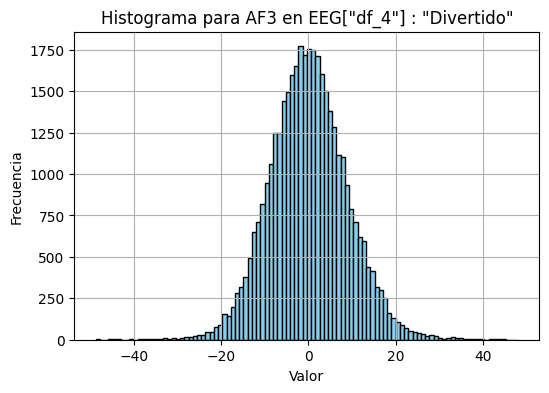

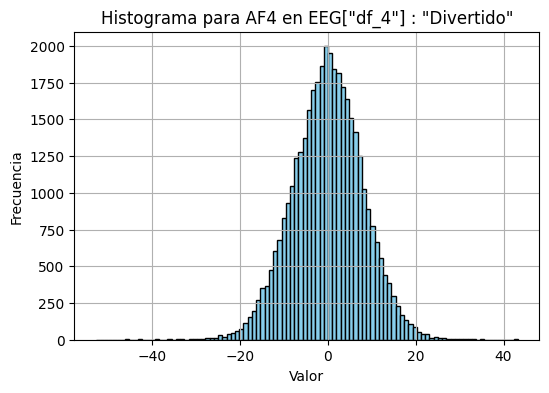

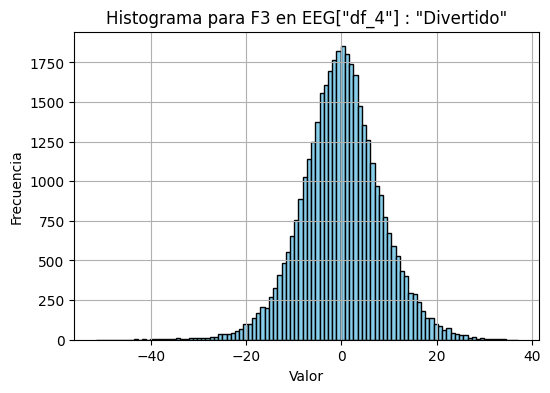

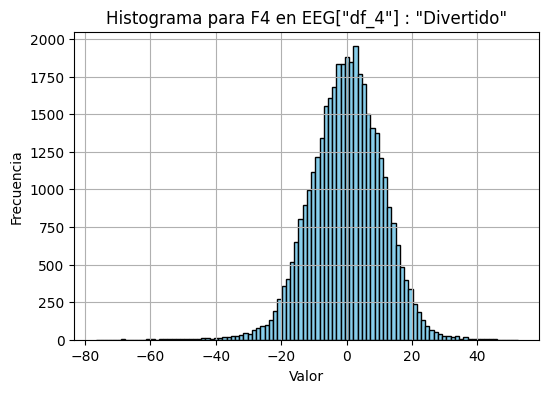

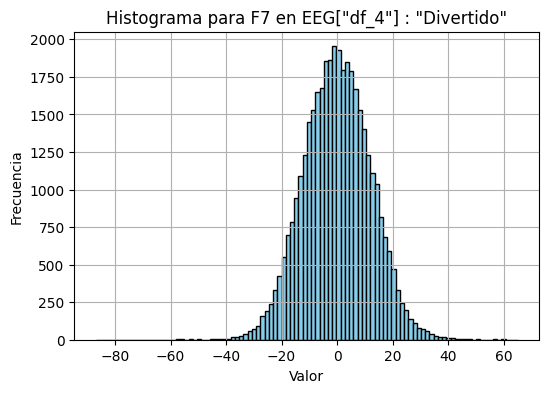

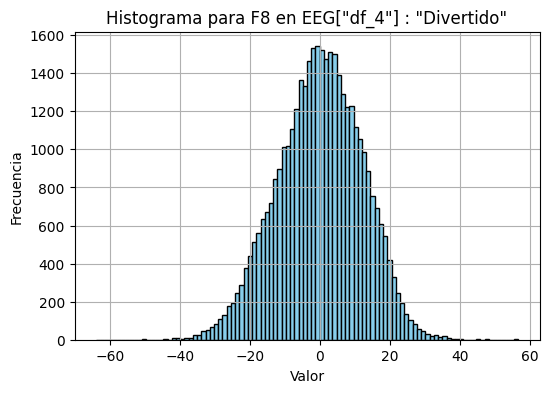

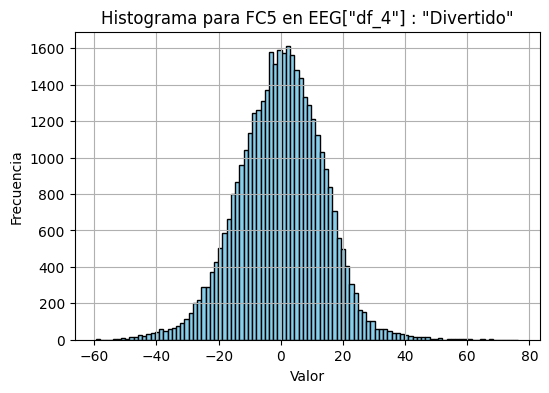

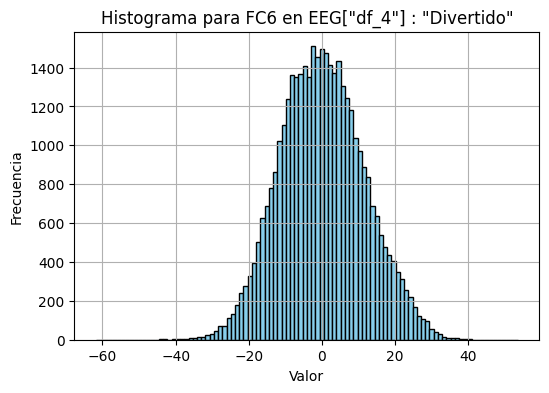

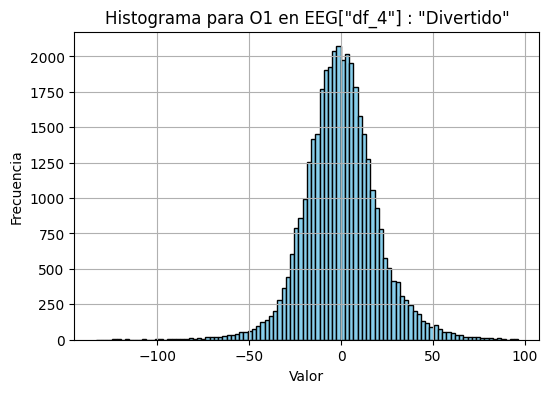

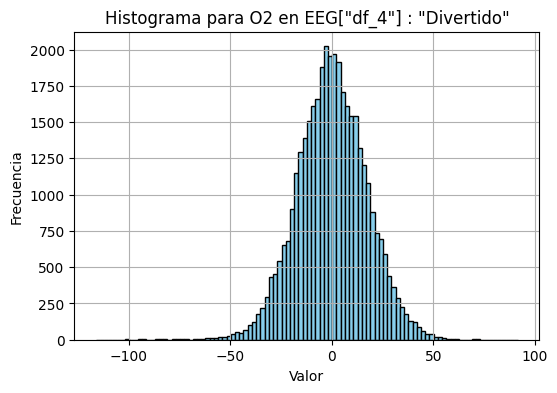

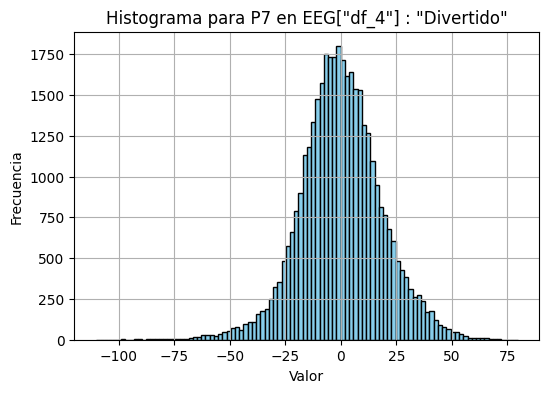

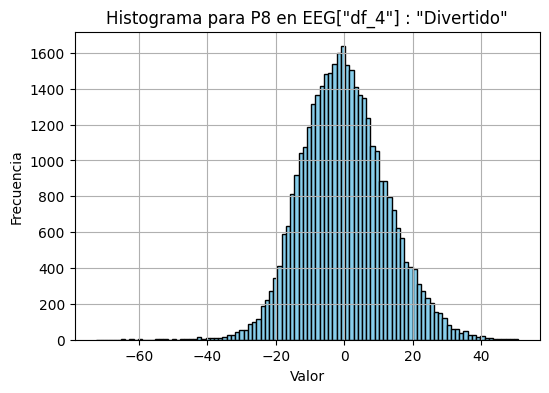

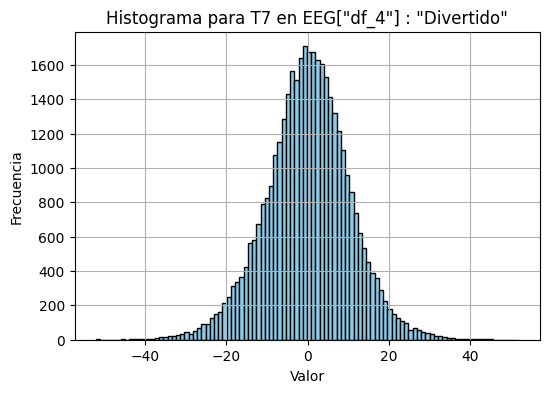

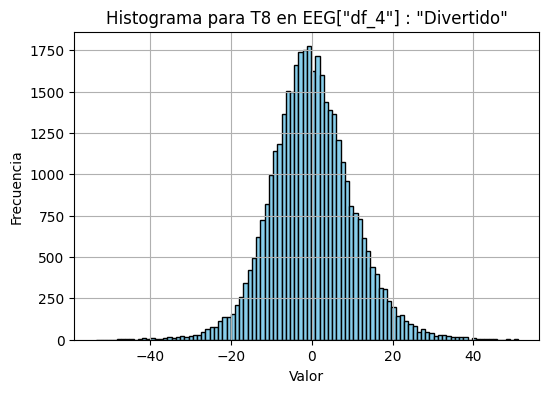

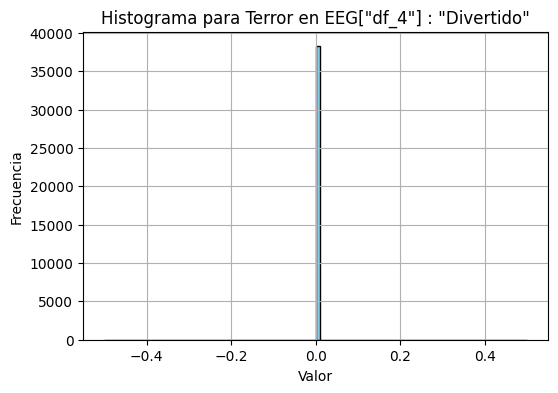

In [ ]:
hist(EEG['df_4'],'EEG["df_4"] : "Divertido"')

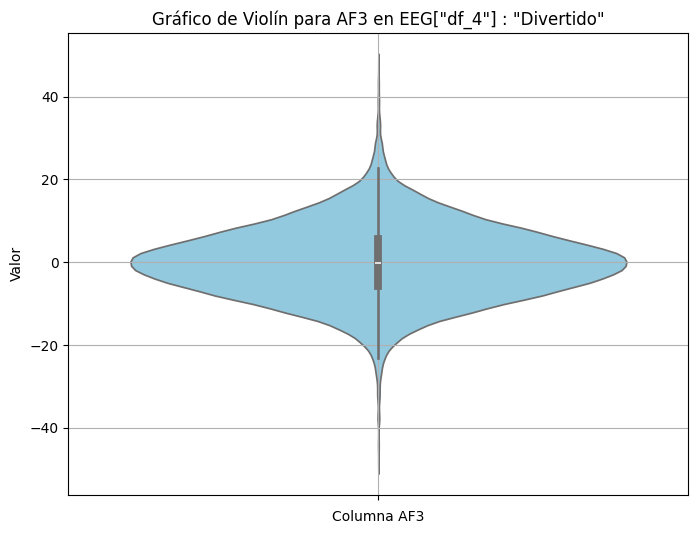

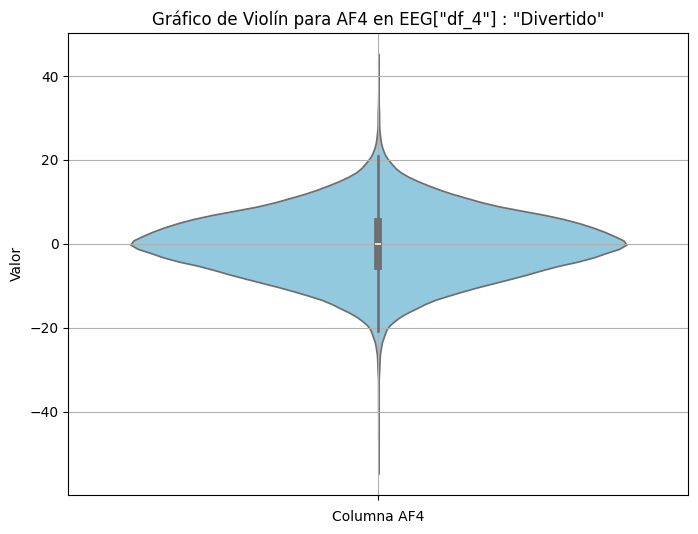

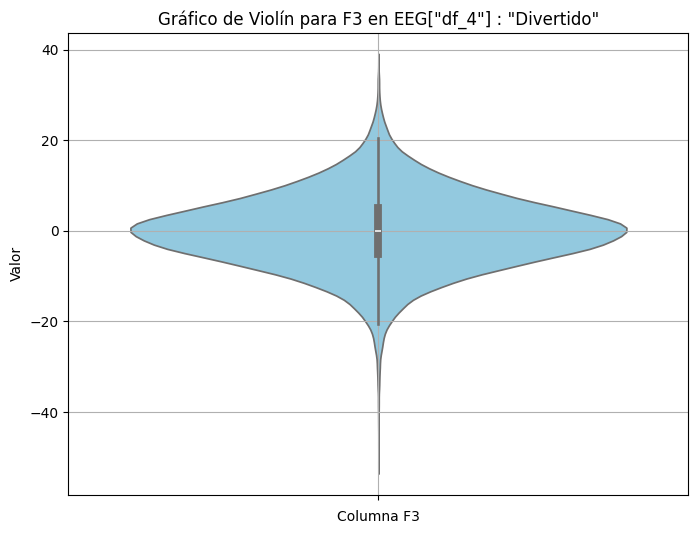

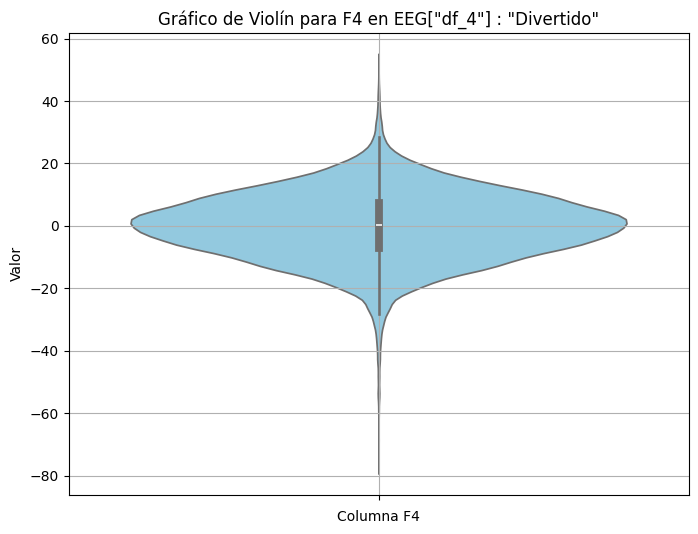

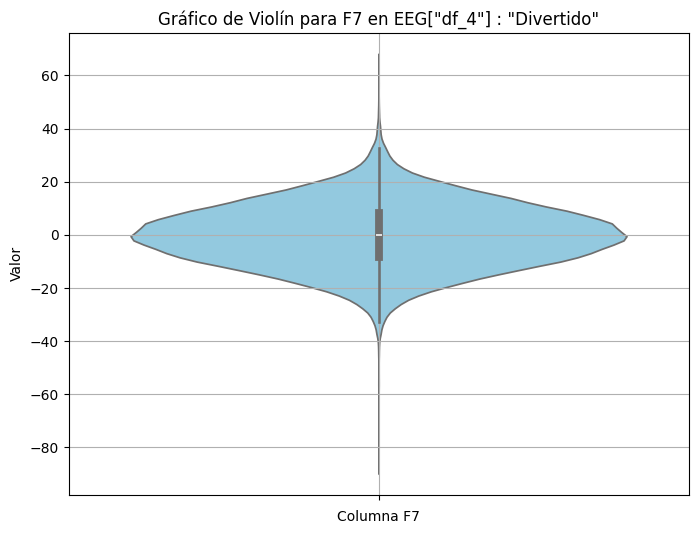

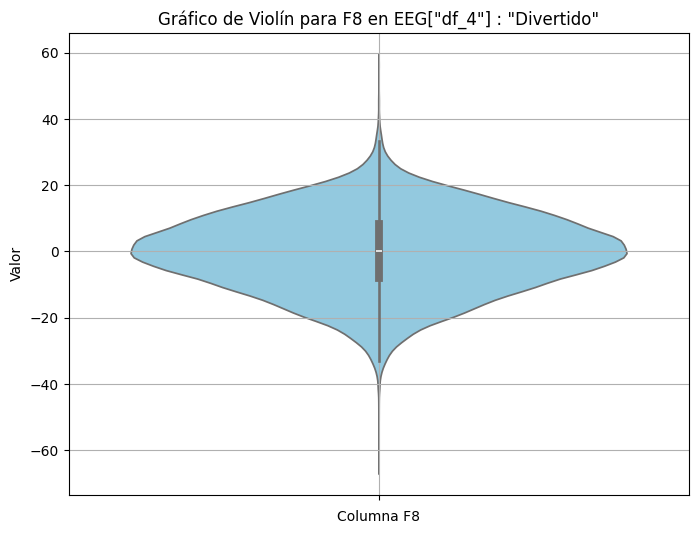

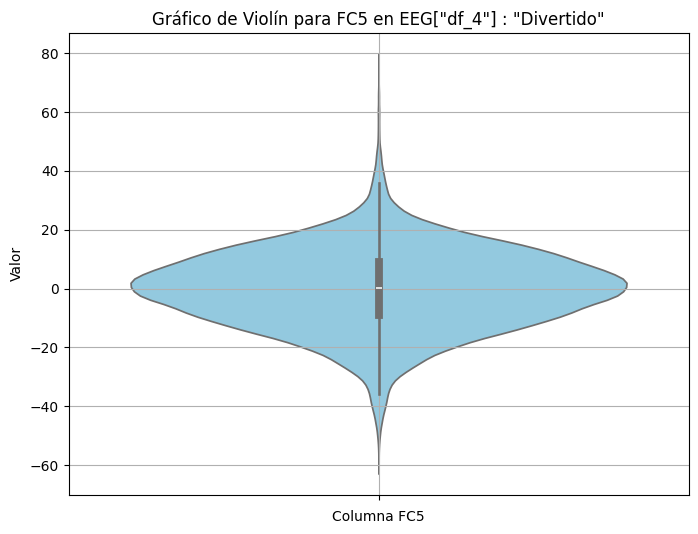

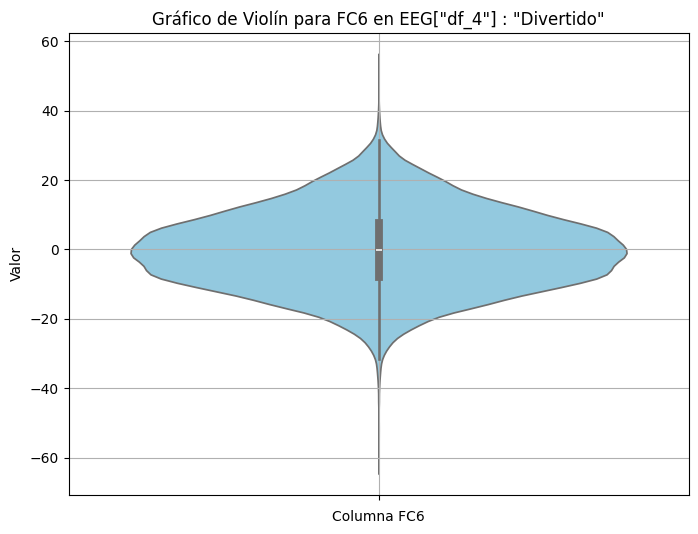

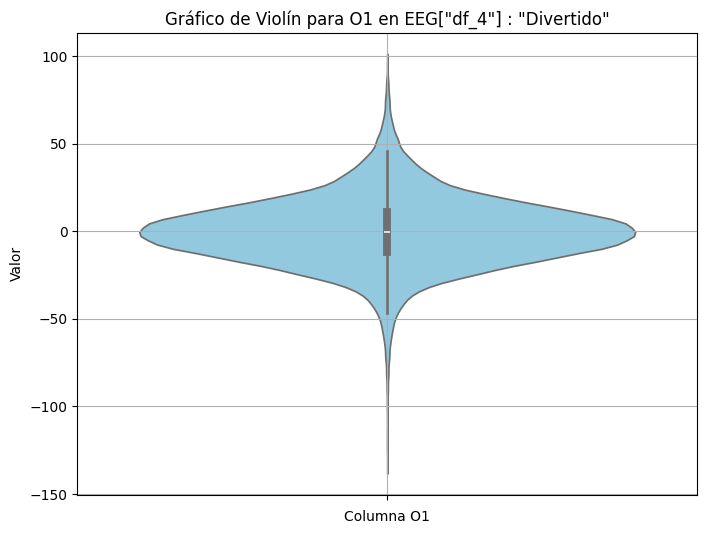

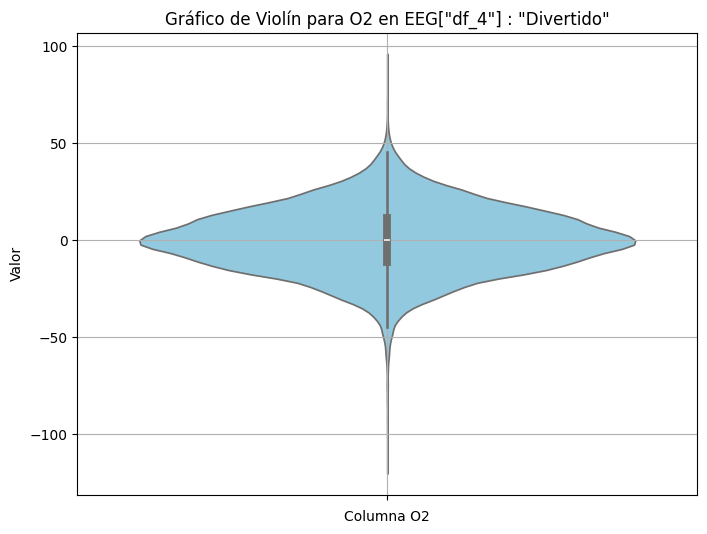

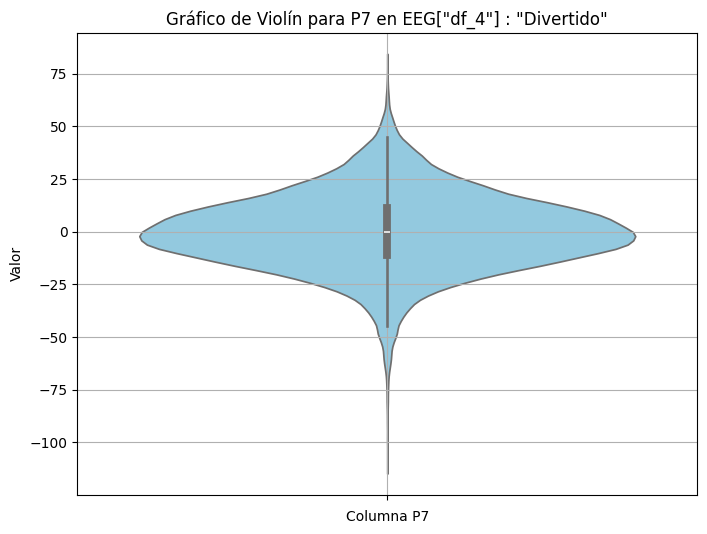

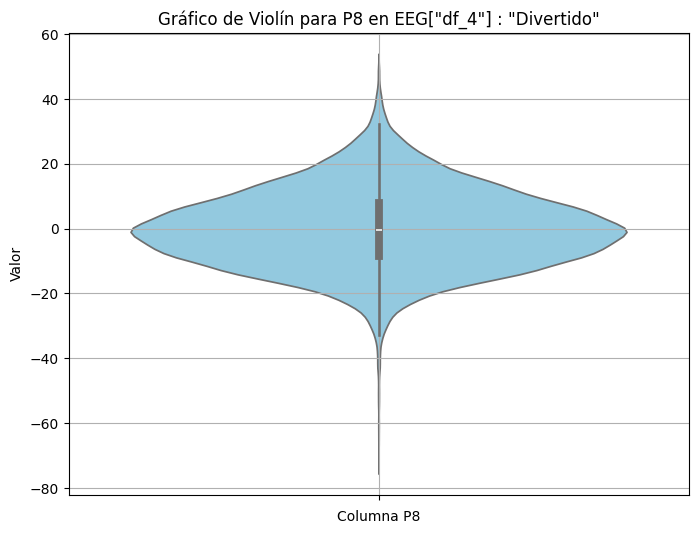

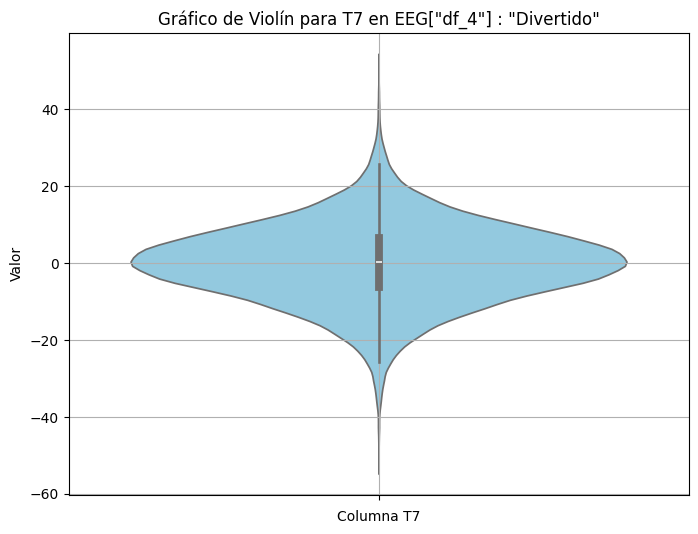

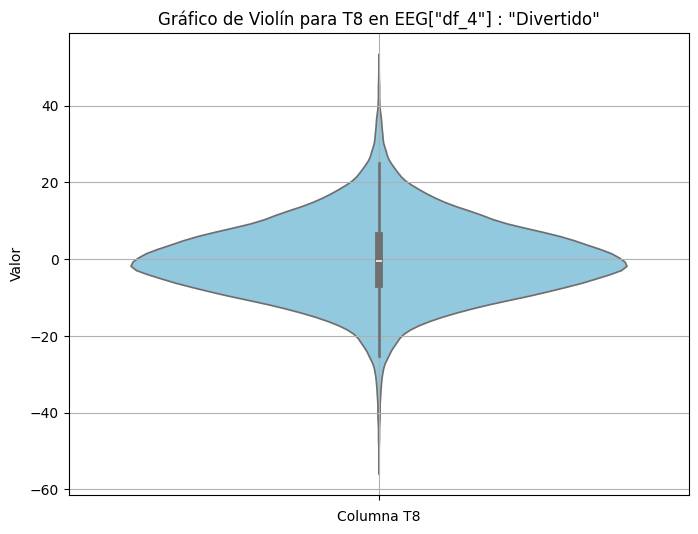

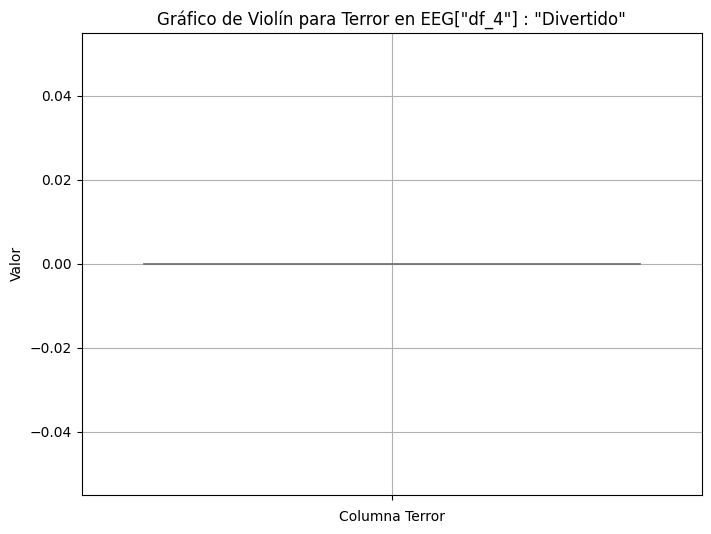

In [ ]:
viol(EEG['df_4'],'EEG["df_4"] : "Divertido"')

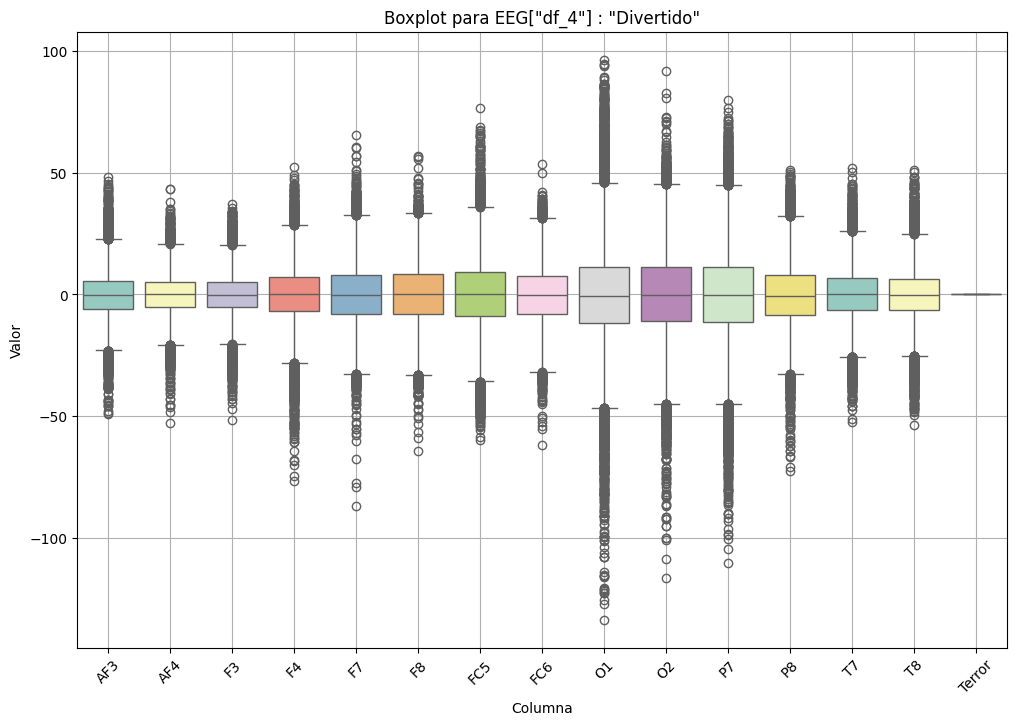

In [ ]:
boxpot_g(EEG['df_4'],'EEG["df_4"] : "Divertido"')

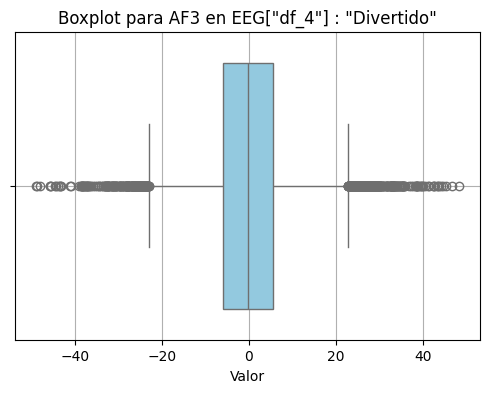

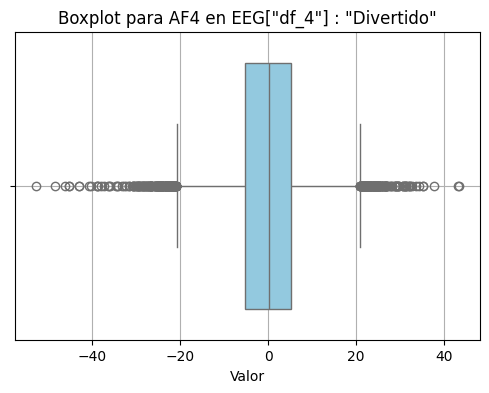

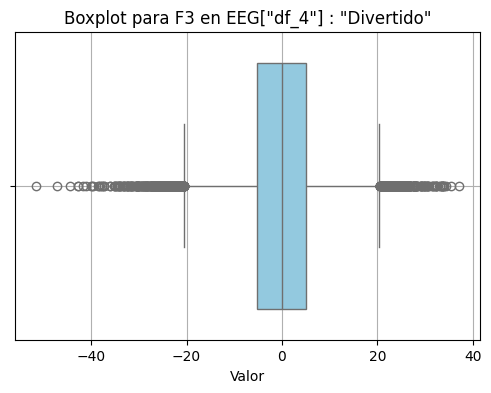

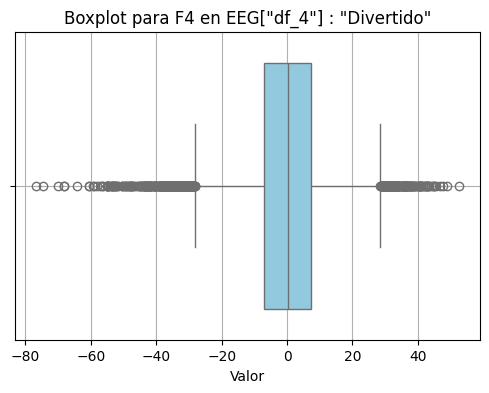

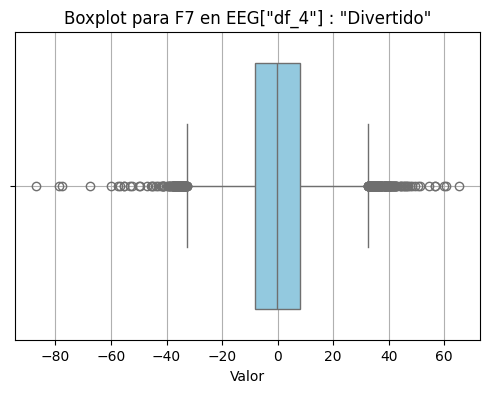

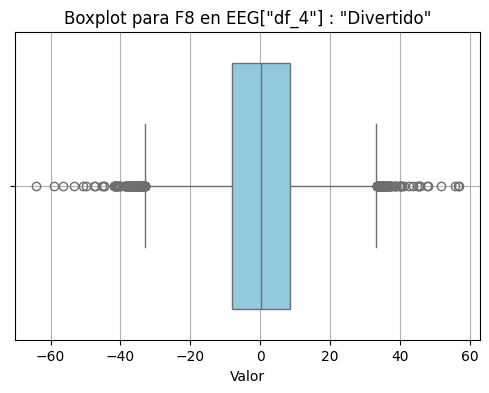

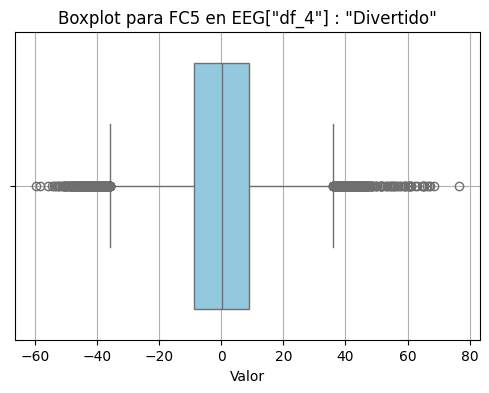

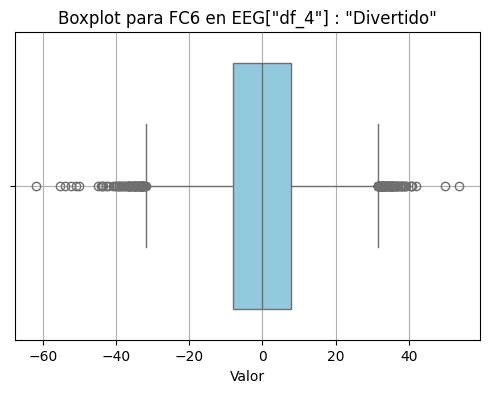

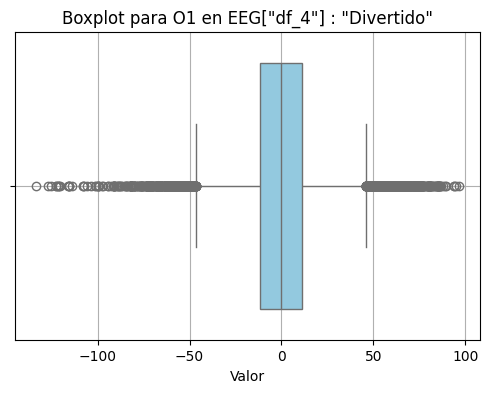

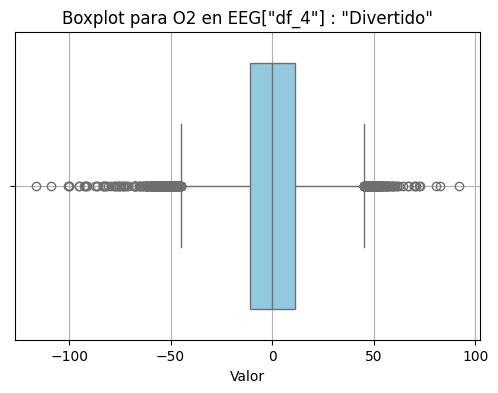

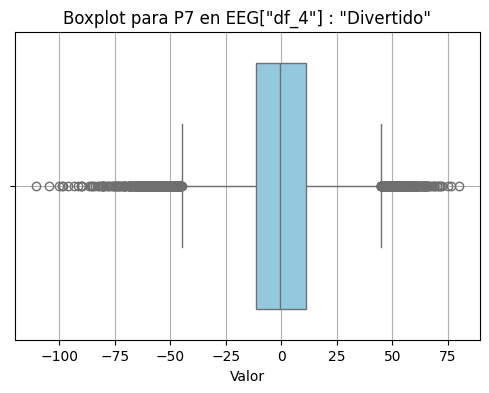

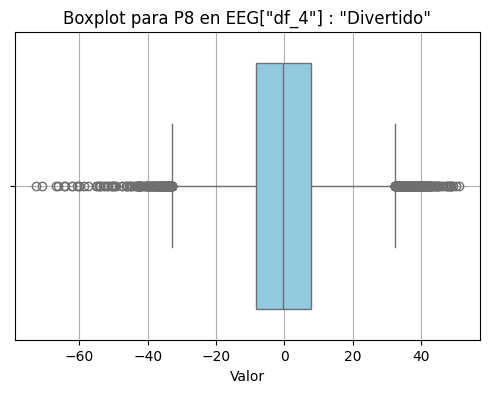

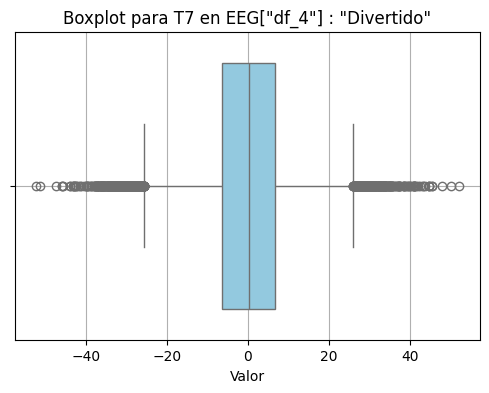

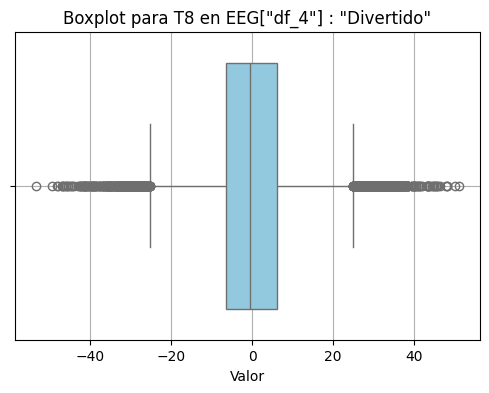

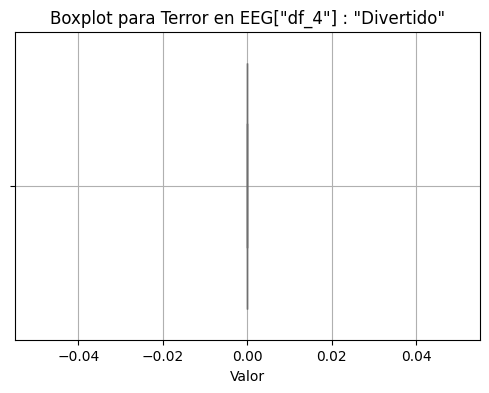

In [ ]:
boxpot_i(EEG['df_4'],'EEG["df_4"] : "Divertido"')

In [ ]:
Outliers_EEG_4 = detec_outliers_iqr(EEG['df_4'])
Outliers_EEG_4.sum()

AF3        591
AF4        419
F3         823
F4         522
F7         288
F8         206
FC5        606
FC6        162
O1        1266
O2         430
P7         911
P8         437
T7         792
T8         826
Terror       0
dtype: int64

In [ ]:
EEG_T['df_4'] = trat_outliers(EEG['df_4'], Outliers_EEG_4, metodo_out)
EEG_T['df_4'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.082131      0.027013      0.004805      0.149701     -0.064605   
std        8.214935      7.523438      7.500426     10.012224     11.509174   
min      -23.007600    -20.821000    -20.505400    -28.234600    -32.647000   
25%       -5.686200     -5.017125     -4.870625     -6.659600     -8.098300   
50%       -0.038079     -0.005652      0.000585      0.124795     -0.023502   
75%        5.350925      5.137625      4.827700      7.106500      7.934550   
max       22.823600     20.883700     20.466800     28.495900     32.522900   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.013524      0.035886      0.026283     -0.313354      0.209218   
std       11.726826     12.548252     11.275177     16.603787     16.087904   
min      -32.915700    -35.719900    -31.685600    -46.622000    -44.861900   
25%       -7.937975     -8.462350     -8.020100    -11.169675    -10.741975   
50%        0.211270      0.088292     -0.201380     -0.052459      0.050812   
75%        8.376950      8.811875      7.652150     10.148850     11.171975   
max       33.252900     35.917200     31.471500     45.928500     45.148500   

                 P7            P8            T7            T8   Terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.267229     -0.099341      0.070568     -0.113760      0.0  
std       16.295465     11.587813      9.362434      9.058293      0.0  
min      -44.863200    -32.827800    -25.598000    -25.303600      0.0  
25%      -10.511325     -8.295700     -5.932100     -6.201275      0.0  
50%        0.056608     -0.350490      0.005085     -0.186595      0.0  
75%       10.654675      7.547400      6.289050      5.759525      0.0  
max       44.940100     32.240500     25.868900     24.997200      0.0

In [ ]:
EEG_T['df_4'].describe().drop(['count', '25%', '50%', '75%'])

AF3        AF4         F3         F4         F7         F8  \
mean  -0.082131   0.027013   0.004805   0.149701  -0.064605  -0.013524   
std    8.214935   7.523438   7.500426  10.012224  11.509174  11.726826   
min  -23.007600 -20.821000 -20.505400 -28.234600 -32.647000 -32.915700   
max   22.823600  20.883700  20.466800  28.495900  32.522900  33.252900   

            FC5        FC6         O1         O2         P7         P8  \
mean   0.035886   0.026283  -0.313354   0.209218   0.267229  -0.099341   
std   12.548252  11.275177  16.603787  16.087904  16.295465  11.587813   
min  -35.719900 -31.685600 -46.622000 -44.861900 -44.863200 -32.827800   
max   35.917200  31.471500  45.928500  45.148500  44.940100  32.240500   

             T7         T8  Terror  
mean   0.070568  -0.113760     0.0  
std    9.362434   9.058293     0.0  
min  -25.598000 -25.303600     0.0  
max   25.868900  24.997200     0.0

## Normalizar

In [ ]:
EEG_N={}

def normali(data, tipo):
    terror = data['Terror']
    col_nor = data.columns.difference(['Terror'])

    if tipo == '0_1':
      scaler = MinMaxScaler(feature_range=(0, 1))
      data_nor = pd.DataFrame(scaler.fit_transform(data[col_nor]), columns=col_nor)

    elif tipo == '-1_1':
      scaler = MinMaxScaler(feature_range=(-1, 1))
      data_nor = pd.DataFrame(scaler.fit_transform(data[col_nor]), columns=col_nor)

    data_nor['terror'] = terror.values
    return data_nor

In [ ]:
EEG_N['df_1'] = normali(EEG_T['df_1'],normal)
EEG_N['df_2'] = normali(EEG_T['df_2'],normal)
EEG_N['df_3'] = normali(EEG_T['df_3'],normal)
EEG_N['df_4'] = normali(EEG_T['df_4'],normal)

In [ ]:
EEG_N['df_1'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.000125      0.003350      0.002192      0.002777      0.000728   
std        0.361535      0.357578      0.356958      0.350978      0.352135   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.241726     -0.233045     -0.230242     -0.235693     -0.232896   
50%       -0.000784     -0.002000     -0.002012     -0.000810      0.001147   
75%        0.237471      0.232124      0.235396      0.238086      0.235569   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean      -0.001337      0.000320     -0.002819     -0.000693      0.000463   
std        0.354562      0.350528      0.358974      0.355053      0.357924   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.248307     -0.238723     -0.246326     -0.230454     -0.239651   
50%        0.000035     -0.000690     -0.001412      0.001905     -0.001929   
75%        0.243718      0.239676      0.245681      0.226657      0.240943   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 P7            P8            T7            T8   terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.000150      0.003517     -0.000769     -0.000643      0.0  
std        0.359375      0.358091      0.357374      0.355400      0.0  
min       -1.000000     -1.000000     -1.000000     -1.000000      0.0  
25%       -0.236709     -0.238494     -0.239207     -0.242092      0.0  
50%        0.002074      0.002069      0.000678      0.000908      0.0  
75%        0.238513      0.237684      0.238096      0.246400      0.0  
max        1.000000      1.000000      1.000000      1.000000      0.0

In [ ]:
EEG_N['df_3'].describe()

AF3           AF4            F3            F4            F7  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.000644      0.002257      0.001833      0.000240      0.000036   
std        0.358680      0.361514      0.363928      0.359520      0.349734   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.242313     -0.240755     -0.234818     -0.237561     -0.233091   
50%       -0.000582     -0.005372      0.001274      0.000281      0.001883   
75%        0.237550      0.238549      0.229107      0.236880      0.236014   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 F8           FC5           FC6            O1            O2  \
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.000000   
mean       0.000824      0.001697      0.003496      0.002816      0.002401   
std        0.351029      0.350484      0.351878      0.357787      0.356825   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.244947     -0.242988     -0.248400     -0.230787     -0.241149   
50%        0.001153      0.001438      0.001588      0.001476      0.000803   
75%        0.245601      0.244157      0.242445      0.231471      0.239935   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 P7            P8            T7            T8   terror  
count  38252.000000  38252.000000  38252.000000  38252.000000  38252.0  
mean       0.003703      0.006874      0.002816     -0.001451      1.0  
std        0.359985      0.349662      0.358948      0.360725      0.0  
min       -1.000000     -1.000000     -1.000000     -1.000000      1.0  
25%       -0.236106     -0.244048     -0.228094     -0.239568      1.0  
50%        0.003406     -0.000303     -0.007316     -0.002445      1.0  
75%        0.235560      0.240277      0.236664      0.239847      1.0  
max        1.000000      1.000000      1.000000      1.000000      1.0

##Segmentación

In [ ]:
#Función de reducción para una columna
def reduccion(data, tam_ven, despla, aggregation_func):
    red = []
    for start in range(0, len(data) - tam_ven + 1, despla):
        window = data[start:start + tam_ven]
        red.append(aggregation_func(window))
    return red

#Función de reducción para todas las columnas excepto 'terror'
def reduccion_para_todas_columnas(df, tam_ven, despla, aggregation_funcs, exclude_column):
    reduced_data = {}
    for column in df.columns:
        if column != exclude_column:
            for func_name, func in aggregation_funcs.items():
                new_column_name = f"{column}_{func_name}"
                reduced_data[new_column_name] = reduccion(df[column].values, tam_ven, despla, func)
    return pd.DataFrame(reduced_data)

In [ ]:
EEG_V = {}

aggregation_funcs = {
    'mean': np.mean, #Media
    'median': np.median, #Mediana
    'sum': np.sum, #Suma
    'max': np.max, #Máximo
    'min': np.min, #Mínimo
    'std': np.std, #Desviación Estandar
    'var': np.var, # Varianza
    'per': lambda x: np.percentile(x, 90), #Percentil 90
    'iqr': lambda x: np.percentile(x, 75) - np.percentile(x, 25), #Intercuartil
    'idr': lambda x: np.percentile(x, 90) - np.percentile(x, 10), #Interdecil
    'sos': lambda x: np.sum(np.square(x)), #Suma de Cuadrados
    'srsq': lambda x: np.sqrt(np.sum(np.square(x))), #Raiz Cuadrada Suma de Cuadrados
    'rms' : lambda x: np.sqrt(np.mean(np.square(x))), #Raiz Cuadrada Media
    'avm' : lambda x: np.mean(np.abs(x)), # Magnitud Promedio
    'ms' : lambda x: np.sqrt(np.mean(np.square(x))) #Promedio Cuadrático
}

In [ ]:
EEG_V['df_1'] = reduccion_para_todas_columnas(EEG_N['df_1'].drop(columns=['terror']), tam_ven, despla, aggregation_funcs, 'terror')
EEG_V['df_2'] = reduccion_para_todas_columnas(EEG_N['df_2'].drop(columns=['terror']), tam_ven, despla, aggregation_funcs, 'terror')
EEG_V['df_3'] = reduccion_para_todas_columnas(EEG_N['df_3'].drop(columns=['terror']), tam_ven, despla, aggregation_funcs, 'terror')
EEG_V['df_4'] = reduccion_para_todas_columnas(EEG_N['df_4'].drop(columns=['terror']), tam_ven, despla, aggregation_funcs, 'terror')

EEG_V['df_1']['terror'] = EEG_N['df_1']['terror'][:len(EEG_V['df_1'])]  # Ajustar el tamaño de la columna 'terror'
EEG_V['df_2']['terror'] = EEG_N['df_2']['terror'][:len(EEG_V['df_2'])]  # Ajustar el tamaño de la columna 'terror'
EEG_V['df_3']['terror'] = EEG_N['df_3']['terror'][:len(EEG_V['df_3'])]  # Ajustar el tamaño de la columna 'terror'
EEG_V['df_4']['terror'] = EEG_N['df_4']['terror'][:len(EEG_V['df_4'])]  # Ajustar el tamaño de la columna 'terror'

In [ ]:
#Tamaño de df_mean ((total - ventana)/despla) + 1
EEG_V['df_1']

AF3_mean  AF3_median    AF3_sum   AF3_max   AF3_min   AF3_std   AF3_var  \
0    0.030981    0.028292   3.965506  0.915267 -0.971087  0.357921  0.128108   
1    0.005917   -0.045884   0.757334  0.915267 -0.510390  0.279778  0.078276   
2   -0.034935   -0.029964  -4.471728  0.433346 -0.510390  0.199766  0.039906   
3    0.066688    0.057827   8.536101  0.777519 -0.348996  0.225865  0.051015   
4    0.032279   -0.000688   4.131654  0.836220 -0.432306  0.259059  0.067112   
..        ...         ...        ...       ...       ...       ...       ...   
591  0.083866    0.111028  10.734816  0.956048 -0.656396  0.325118  0.105702   
592  0.044279    0.013788   5.667732  0.781155 -0.602089  0.296059  0.087651   
593  0.003525    0.002003   0.451190  0.625730 -0.532863  0.265057  0.070255   
594  0.060491    0.049507   7.742851  0.698035 -0.633431  0.275252  0.075764   
595  0.012084   -0.011082   1.546734  0.729122 -0.689023  0.299076  0.089446   

      AF3_per   AF3_iqr   AF3_idr  ...    T8_var    T8_per    T8_iqr  \
0    0.539012  0.392377  0.942121  ...  0.046860  0.474591  0.238312   
1    0.394864  0.275099  0.673909  ...  0.054616  0.394700  0.292275   
2    0.233513  0.270408  0.527781  ...  0.043970  0.304852  0.266633   
3    0.341382  0.257481  0.546490  ...  0.059111  0.453267  0.323603   
4    0.344546  0.274291  0.594845  ...  0.061131  0.523375  0.319208   
..        ...       ...       ...  ...       ...       ...       ...   
591  0.491178  0.475649  0.825557  ...  0.119307  0.407762  0.488885   
592  0.422433  0.444786  0.756812  ...  0.123387  0.412001  0.523972   
593  0.357100  0.367237  0.707998  ...  0.112922  0.468113  0.523489   
594  0.420378  0.414688  0.742708  ...  0.119245  0.384668  0.502688   
595  0.416650  0.427660  0.756082  ...  0.118095  0.380523  0.477633   

       T8_idr     T8_sos   T8_srsq    T8_rms    T8_avm     T8_ms  terror  
0    0.477755  12.374567  3.517750  0.310928  0.268034  0.310928     0.0  
1    0.598164   9.471529  3.077585  0.272023  0.227110  0.272023     0.0  
2    0.527236   5.944919  2.438220  0.215510  0.169360  0.215510     0.0  
3    0.637796   9.954425  3.155063  0.278871  0.219827  0.278871     0.0  
4    0.518826  16.893409  4.110159  0.363290  0.319764  0.363290     0.0  
..        ...        ...       ...       ...       ...       ...     ...  
591  0.888961  15.382668  3.922075  0.346666  0.285157  0.346666     0.0  
592  0.868816  15.793616  3.974118  0.351266  0.290212  0.351266     0.0  
593  0.903080  14.520344  3.810557  0.336809  0.275651  0.336809     0.0  
594  0.932926  15.903728  3.987948  0.352488  0.289363  0.352488     0.0  
595  0.938014  15.796678  3.974503  0.351300  0.289235  0.351300     0.0  

[596 rows x 211 columns]

In [ ]:
EEG_V['df_2']

AF3_mean  AF3_median    AF3_sum   AF3_max   AF3_min   AF3_std   AF3_var  \
0   -0.037932    0.002670  -4.855340  0.956735 -0.979730  0.429299  0.184297   
1   -0.052892    0.002670  -6.770166  0.824873 -0.960225  0.430708  0.185509   
2    0.007167    0.005324   0.917364  0.930988 -0.971261  0.427541  0.182792   
3    0.011833    0.004119   1.514667  0.930988 -0.971261  0.337980  0.114231   
4    0.045077    0.040282   5.769794  0.782809 -0.559931  0.263837  0.069610   
..        ...         ...        ...       ...       ...       ...       ...   
591  0.199491    0.169427  25.534881  0.997306 -0.835179  0.386370  0.149282   
592 -0.006967    0.002670  -0.891752  0.783293 -0.970558  0.388345  0.150812   
593 -0.078599   -0.093763 -10.060675  0.783293 -0.970558  0.386505  0.149386   
594 -0.068557   -0.085981  -8.775275  0.713445 -0.866311  0.363885  0.132413   
595 -0.041770   -0.067289  -5.346503  0.949590 -0.841617  0.362502  0.131408   

      AF3_per   AF3_iqr   AF3_idr  ...    T8_var    T8_per    T8_iqr  \
0    0.556576  0.612786  1.163454  ...  0.204617  0.524333  0.717970   
1    0.568880  0.635088  1.202499  ...  0.214486  0.728782  0.704537   
2    0.586527  0.588188  1.209292  ...  0.217265  0.727240  0.749446   
3    0.512366  0.422829  0.948754  ...  0.187047  0.562794  0.634348   
4    0.343056  0.409516  0.651335  ...  0.132218  0.424202  0.513726   
..        ...       ...       ...  ...       ...       ...       ...   
591  0.724369  0.551467  1.005913  ...  0.169826  0.733284  0.614462   
592  0.512569  0.531382  1.036144  ...  0.103550  0.361378  0.443481   
593  0.444087  0.597654  1.009254  ...  0.092361  0.362631  0.352964   
594  0.453713  0.518883  1.000305  ...  0.079447  0.312993  0.353536   
595  0.446230  0.480506  0.916968  ...  0.101996  0.401572  0.417241   

       T8_idr     T8_sos   T8_srsq    T8_rms    T8_avm     T8_ms  terror  
0    1.100204  26.230136  5.121536  0.452684  0.373938  0.452684     0.0  
1    1.195290  29.563618  5.437244  0.480589  0.404340  0.480589     0.0  
2    1.232388  29.409896  5.423089  0.479338  0.400179  0.479338     0.0  
3    1.125093  24.114185  4.910620  0.434042  0.357365  0.434042     0.0  
4    0.962750  17.813585  4.220614  0.373053  0.297779  0.373053     0.0  
..        ...        ...       ...       ...       ...       ...     ...  
591  1.045321  26.410654  5.139130  0.454239  0.366510  0.454239     0.0  
592  0.902506  13.416172  3.662809  0.323750  0.257745  0.323750     0.0  
593  0.793897  11.860931  3.443970  0.304407  0.237898  0.304407     0.0  
594  0.698084  10.222281  3.197230  0.282598  0.222095  0.282598     0.0  
595  0.913790  13.500987  3.674369  0.324771  0.260001  0.324771     0.0  

[596 rows x 211 columns]

In [ ]:
EEG_V['df_3']

AF3_mean  AF3_median    AF3_sum   AF3_max   AF3_min   AF3_std   AF3_var  \
0    0.040194    0.005195   5.144844  0.997952 -0.596070  0.262672  0.068996   
1   -0.096709   -0.130584 -12.378733  0.618822 -0.707731  0.285480  0.081499   
2   -0.190679   -0.254282 -24.406854  0.675374 -0.707731  0.290700  0.084506   
3   -0.188032   -0.210056 -24.068095  0.688415 -0.944419  0.307424  0.094510   
4    0.028494   -0.001705   3.647171  0.962901 -0.944419  0.410880  0.168822   
..        ...         ...        ...       ...       ...       ...       ...   
591 -0.003552   -0.010095  -0.454705  0.935188 -0.651005  0.321636  0.103450   
592 -0.015795    0.009692  -2.021741  0.935188 -0.820848  0.376808  0.141984   
593 -0.005539   -0.007826  -0.709052  0.733915 -0.820848  0.356191  0.126872   
594  0.083266    0.064804  10.658043  0.889178 -0.629883  0.302526  0.091522   
595  0.064269    0.044089   8.226388  0.889178 -0.663323  0.299629  0.089778   

      AF3_per   AF3_iqr   AF3_idr  ...    T8_var    T8_per    T8_iqr  \
0    0.367795  0.308434  0.682296  ...  0.051525  0.287285  0.287499   
1    0.280424  0.421778  0.723627  ...  0.070429  0.399983  0.328372   
2    0.186252  0.403868  0.699249  ...  0.104103  0.495404  0.435961   
3    0.175585  0.419705  0.740170  ...  0.133253  0.501250  0.428817   
4    0.644240  0.494417  1.133718  ...  0.193364  0.478633  0.530647   
..        ...       ...       ...  ...       ...       ...       ...   
591  0.427519  0.454291  0.834439  ...  0.113370  0.392135  0.480184   
592  0.453304  0.541837  0.990751  ...  0.097246  0.392135  0.465989   
593  0.429040  0.486486  0.897129  ...  0.083573  0.335087  0.345264   
594  0.447651  0.390898  0.732757  ...  0.097364  0.274149  0.354565   
595  0.474576  0.417094  0.742193  ...  0.139053  0.408783  0.549892   

       T8_idr     T8_sos   T8_srsq    T8_rms    T8_avm     T8_ms  terror  
0    0.603788   6.630400  2.574956  0.227596  0.181801  0.227596     1.0  
1    0.653530   9.894598  3.145568  0.278032  0.220548  0.278032     1.0  
2    0.850017  13.949778  3.734940  0.330125  0.261049  0.330125     1.0  
3    0.931873  17.212821  4.148834  0.366709  0.286929  0.366709     1.0  
4    1.265255  26.776245  5.174577  0.457372  0.357977  0.457372     1.0  
..        ...        ...       ...       ...       ...       ...     ...  
591  0.815889  14.536475  3.812673  0.336996  0.275913  0.336996     1.0  
592  0.783042  12.449252  3.528350  0.311865  0.253823  0.311865     1.0  
593  0.726831  10.719157  3.274012  0.289385  0.228341  0.289385     1.0  
594  0.759029  13.475291  3.670871  0.324462  0.252395  0.324462     1.0  
595  0.995650  18.422598  4.292155  0.379377  0.311472  0.379377     1.0  

[596 rows x 211 columns]

In [ ]:
EEG_V['df_4']

AF3_mean  AF3_median    AF3_sum   AF3_max   AF3_min   AF3_std   AF3_var  \
0   -0.055313   -0.067552  -7.080005  0.793743 -0.505263  0.241400  0.058274   
1    0.004050    0.007708   0.518413  0.793743 -0.505263  0.252126  0.063568   
2    0.069840    0.030607   8.939534  0.881164 -0.402202  0.223159  0.049800   
3    0.123613    0.112236  15.822464  0.881164 -0.271985  0.185236  0.034312   
4    0.138987    0.128936  17.790351  0.983003 -0.407085  0.200078  0.040031   
..        ...         ...        ...       ...       ...       ...       ...   
591 -0.096020   -0.082226 -12.290552  0.427879 -0.707147  0.220061  0.048427   
592 -0.099287   -0.086467 -12.708760  0.635685 -0.770824  0.251550  0.063277   
593 -0.050276   -0.030680  -6.435333  0.635685 -0.770824  0.303056  0.091843   
594 -0.008169    0.023019  -1.045667  0.620507 -0.590205  0.283993  0.080652   
595 -0.033921   -0.003535  -4.341928  0.606565 -0.730315  0.287647  0.082741   

      AF3_per   AF3_iqr   AF3_idr  ...    T8_var    T8_per    T8_iqr  \
0    0.134844  0.288604  0.468165  ...  0.067587  0.415701  0.265413   
1    0.244481  0.311433  0.568098  ...  0.076598  0.433095  0.311055   
2    0.365546  0.266355  0.540622  ...  0.086069  0.222372  0.418170   
3    0.354553  0.195336  0.444183  ...  0.119138  0.213928  0.431665   
4    0.356243  0.170160  0.445166  ...  0.098044  0.385048  0.375003   
..        ...       ...       ...  ...       ...       ...       ...   
591  0.187439  0.273486  0.574984  ...  0.182496  0.588140  0.617769   
592  0.221544  0.310194  0.627188  ...  0.174032  0.588140  0.588280   
593  0.300952  0.435330  0.779150  ...  0.162954  0.411414  0.582392   
594  0.338897  0.376178  0.762123  ...  0.178921  0.430001  0.589262   
595  0.353693  0.377467  0.791983  ...  0.167094  0.332964  0.584499   

       T8_idr     T8_sos   T8_srsq    T8_rms    T8_avm     T8_ms  terror  
0    0.628205   8.946380  2.991050  0.264374  0.184628  0.264374     0.0  
1    0.691456  10.036105  3.167981  0.280013  0.208368  0.280013     0.0  
2    0.806846  14.864845  3.855495  0.340781  0.273500  0.340781     0.0  
3    0.808821  20.692451  4.548896  0.402069  0.335236  0.402069     0.0  
4    0.777576  12.550131  3.542616  0.313126  0.244920  0.313126     0.0  
..        ...        ...       ...       ...       ...       ...     ...  
591  1.177140  23.432260  4.840688  0.427860  0.349946  0.427860     0.0  
592  1.178656  22.409692  4.733888  0.418421  0.336576  0.418421     0.0  
593  1.077635  21.882621  4.677886  0.413471  0.337188  0.413471     0.0  
594  1.123338  24.149567  4.914221  0.434360  0.356525  0.434360     0.0  
595  1.172358  28.421075  5.331142  0.471211  0.381664  0.471211     0.0  

[596 rows x 211 columns]

##Unir Datos

In [ ]:
EEG_F = pd.concat([EEG_V['df_1'], EEG_V['df_2'], EEG_V['df_3'], EEG_V['df_4']], ignore_index=True)
EEG_F

AF3_mean  AF3_median    AF3_sum   AF3_max   AF3_min   AF3_std   AF3_var  \
0     0.030981    0.028292   3.965506  0.915267 -0.971087  0.357921  0.128108   
1     0.005917   -0.045884   0.757334  0.915267 -0.510390  0.279778  0.078276   
2    -0.034935   -0.029964  -4.471728  0.433346 -0.510390  0.199766  0.039906   
3     0.066688    0.057827   8.536101  0.777519 -0.348996  0.225865  0.051015   
4     0.032279   -0.000688   4.131654  0.836220 -0.432306  0.259059  0.067112   
...        ...         ...        ...       ...       ...       ...       ...   
2379 -0.096020   -0.082226 -12.290552  0.427879 -0.707147  0.220061  0.048427   
2380 -0.099287   -0.086467 -12.708760  0.635685 -0.770824  0.251550  0.063277   
2381 -0.050276   -0.030680  -6.435333  0.635685 -0.770824  0.303056  0.091843   
2382 -0.008169    0.023019  -1.045667  0.620507 -0.590205  0.283993  0.080652   
2383 -0.033921   -0.003535  -4.341928  0.606565 -0.730315  0.287647  0.082741   

       AF3_per   AF3_iqr   AF3_idr  ...    T8_var    T8_per    T8_iqr  \
0     0.539012  0.392377  0.942121  ...  0.046860  0.474591  0.238312   
1     0.394864  0.275099  0.673909  ...  0.054616  0.394700  0.292275   
2     0.233513  0.270408  0.527781  ...  0.043970  0.304852  0.266633   
3     0.341382  0.257481  0.546490  ...  0.059111  0.453267  0.323603   
4     0.344546  0.274291  0.594845  ...  0.061131  0.523375  0.319208   
...        ...       ...       ...  ...       ...       ...       ...   
2379  0.187439  0.273486  0.574984  ...  0.182496  0.588140  0.617769   
2380  0.221544  0.310194  0.627188  ...  0.174032  0.588140  0.588280   
2381  0.300952  0.435330  0.779150  ...  0.162954  0.411414  0.582392   
2382  0.338897  0.376178  0.762123  ...  0.178921  0.430001  0.589262   
2383  0.353693  0.377467  0.791983  ...  0.167094  0.332964  0.584499   

        T8_idr     T8_sos   T8_srsq    T8_rms    T8_avm     T8_ms  terror  
0     0.477755  12.374567  3.517750  0.310928  0.268034  0.310928     0.0  
1     0.598164   9.471529  3.077585  0.272023  0.227110  0.272023     0.0  
2     0.527236   5.944919  2.438220  0.215510  0.169360  0.215510     0.0  
3     0.637796   9.954425  3.155063  0.278871  0.219827  0.278871     0.0  
4     0.518826  16.893409  4.110159  0.363290  0.319764  0.363290     0.0  
...        ...        ...       ...       ...       ...       ...     ...  
2379  1.177140  23.432260  4.840688  0.427860  0.349946  0.427860     0.0  
2380  1.178656  22.409692  4.733888  0.418421  0.336576  0.418421     0.0  
2381  1.077635  21.882621  4.677886  0.413471  0.337188  0.413471     0.0  
2382  1.123338  24.149567  4.914221  0.434360  0.356525  0.434360     0.0  
2383  1.172358  28.421075  5.331142  0.471211  0.381664  0.471211     0.0  

[2384 rows x 211 columns]

In [ ]:
EEG_F.describe()

AF3_mean   AF3_median      AF3_sum      AF3_max      AF3_min  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      0.000571    -0.005180     0.073033     0.824414    -0.781564   
std       0.101506     0.105511    12.992722     0.142423     0.151581   
min      -0.435263    -0.448928   -55.713682     0.156312    -1.000000   
25%      -0.055446    -0.061833    -7.097065     0.743957    -0.908310   
50%      -0.002490    -0.005966    -0.318714     0.852904    -0.796845   
75%       0.048712     0.042844     6.235134     0.937120    -0.678180   
max       0.521864     0.560664    66.798648     1.000000     0.005195   

           AF3_std      AF3_var      AF3_per      AF3_iqr      AF3_idr  ...  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000  ...   
mean      0.340907     0.119265     0.448077     0.472816     0.886770  ...   
std       0.055211     0.037264     0.132653     0.092424     0.162214  ...   
min       0.127168     0.016172    -0.164623     0.140849     0.338661  ...   
25%       0.307996     0.094861     0.369147     0.416025     0.787628  ...   
50%       0.341786     0.116818     0.442277     0.470461     0.885231  ...   
75%       0.375940     0.141331     0.521535     0.531853     0.990096  ...   
max       0.531973     0.282996     0.892147     0.864486     1.507215  ...   

            T8_var       T8_per       T8_iqr       T8_idr       T8_sos  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      0.118365     0.442313     0.472915     0.883068    16.544096   
std       0.036110     0.133567     0.095620     0.154035     5.603826   
min       0.024494    -0.037360     0.000000     0.364040     3.238506   
25%       0.095005     0.356362     0.410801     0.789023    12.868327   
50%       0.115613     0.435093     0.472135     0.882093    15.700732   
75%       0.137519     0.514375     0.528899     0.967788    19.315645   
max       0.311835     0.955619     0.962064     1.573000    51.294407   

           T8_srsq       T8_rms       T8_avm        T8_ms       terror  
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000  
mean      4.011859     0.354602     0.286203     0.354602     0.250000  
std       0.670275     0.059244     0.049776     0.059244     0.433104  
min       1.799585     0.159062     0.118204     0.159062     0.000000  
25%       3.587245     0.317071     0.253980     0.317071     0.000000  
50%       3.962415     0.350231     0.284111     0.350231     0.000000  
75%       4.394957     0.388463     0.314903     0.388463     0.250000  
max       7.162011     0.633038     0.501976     0.633038     1.000000  

[8 rows x 211 columns]

##Mezcla

In [ ]:
EEG_Final = EEG_F.sample(frac=1, random_state=42).reset_index(drop=True)
EEG_Final

EEG_Final.to_csv(f"EEG_Final_{sujeto}.csv", index=False)

In [ ]:
EEG_Final.describe()

AF3_mean   AF3_median      AF3_sum      AF3_max      AF3_min  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      0.000571    -0.005180     0.073033     0.824414    -0.781564   
std       0.101506     0.105511    12.992722     0.142423     0.151581   
min      -0.435263    -0.448928   -55.713682     0.156312    -1.000000   
25%      -0.055446    -0.061833    -7.097065     0.743957    -0.908310   
50%      -0.002490    -0.005966    -0.318714     0.852904    -0.796845   
75%       0.048712     0.042844     6.235134     0.937120    -0.678180   
max       0.521864     0.560664    66.798648     1.000000     0.005195   

           AF3_std      AF3_var      AF3_per      AF3_iqr      AF3_idr  ...  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000  ...   
mean      0.340907     0.119265     0.448077     0.472816     0.886770  ...   
std       0.055211     0.037264     0.132653     0.092424     0.162214  ...   
min       0.127168     0.016172    -0.164623     0.140849     0.338661  ...   
25%       0.307996     0.094861     0.369147     0.416025     0.787628  ...   
50%       0.341786     0.116818     0.442277     0.470461     0.885231  ...   
75%       0.375940     0.141331     0.521535     0.531853     0.990096  ...   
max       0.531973     0.282996     0.892147     0.864486     1.507215  ...   

            T8_var       T8_per       T8_iqr       T8_idr       T8_sos  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      0.118365     0.442313     0.472915     0.883068    16.544096   
std       0.036110     0.133567     0.095620     0.154035     5.603826   
min       0.024494    -0.037360     0.000000     0.364040     3.238506   
25%       0.095005     0.356362     0.410801     0.789023    12.868327   
50%       0.115613     0.435093     0.472135     0.882093    15.700732   
75%       0.137519     0.514375     0.528899     0.967788    19.315645   
max       0.311835     0.955619     0.962064     1.573000    51.294407   

           T8_srsq       T8_rms       T8_avm        T8_ms       terror  
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000  
mean      4.011859     0.354602     0.286203     0.354602     0.250000  
std       0.670275     0.059244     0.049776     0.059244     0.433104  
min       1.799585     0.159062     0.118204     0.159062     0.000000  
25%       3.587245     0.317071     0.253980     0.317071     0.000000  
50%       3.962415     0.350231     0.284111     0.350231     0.000000  
75%       4.394957     0.388463     0.314903     0.388463     0.250000  
max       7.162011     0.633038     0.501976     0.633038     1.000000  

[8 rows x 211 columns]

#ML (Modelos Individuales)

In [ ]:
#Visualizar la Matriz de Confusión
def plot_confusion_matrix(conf_mat,name, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], cbar=False)
    plt.xlabel('Predictions')
    plt.ylabel('Real')
    plt.title('Confusion Matrix')
    plt.savefig(f'CM{name}', dpi=300)
    plt.show()

In [ ]:
X = EEG_Final.drop(columns=['terror'])
y = EEG_Final['terror']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## SVM

In [ ]:
SVM = SVC(kernel='linear', random_state=42, C=0.1, class_weight='balanced', probability=True)
#SVM = SVC(kernel="poly", degree=7, C=0.1, random_state=42, class_weight='balanced', probability=True)
#SVM = SVC(kernel="rbf", C=1, random_state=42, class_weight='balanced', probability=True)
SVM.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

In [ ]:
y_pred_svm = SVM.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy: 0.6983240223463687
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.68      0.77       533
         1.0       0.45      0.77      0.56       183

    accuracy                           0.70       716
   macro avg       0.67      0.72      0.67       716
weighted avg       0.78      0.70      0.72       716



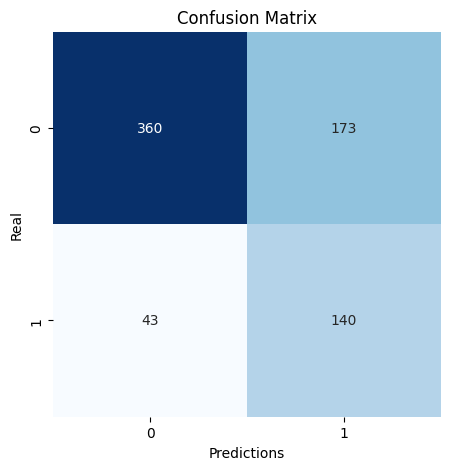

In [ ]:
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(conf_mat_svm,'SVM') #Visualizar la matriz de confusión

## KNN

In [ ]:
#knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn = KNeighborsClassifier(n_neighbors=6, p=1, weights='uniform', n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6, p=1)

In [ ]:
y_pred_knn = knn.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.7863128491620112
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.96      0.87       533
         1.0       0.71      0.27      0.40       183

    accuracy                           0.79       716
   macro avg       0.75      0.62      0.63       716
weighted avg       0.77      0.79      0.75       716



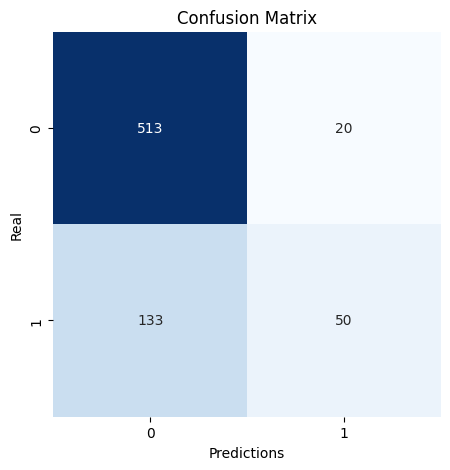

In [ ]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(conf_mat_knn,'KNN') #Visualizar la matriz de confusión

## RFC

In [ ]:
#RFC = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=15, min_samples_split=5, min_samples_leaf=3)
RFC = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=10, min_samples_split=10, min_samples_leaf=3)
RFC.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [ ]:
y_pred_rfc = RFC.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))

Accuracy: 0.8477653631284916
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       533
         1.0       0.92      0.44      0.60       183

    accuracy                           0.85       716
   macro avg       0.88      0.71      0.75       716
weighted avg       0.86      0.85      0.83       716



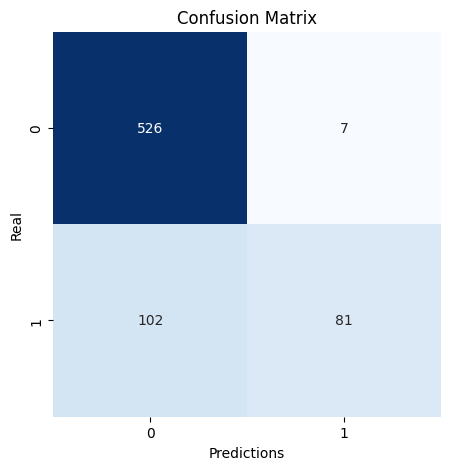

In [ ]:
conf_mat_rfc = confusion_matrix(y_test, y_pred_rfc)
plot_confusion_matrix(conf_mat_rfc,'RFC') #Visualizar la matriz de confusión

## MLP (Perceptrón Multicapa)

In [ ]:
MLP = MLPClassifier(hidden_layer_sizes=(200,100), max_iter=250, random_state=42, alpha=0.5, early_stopping=True)
#MLP = MLPClassifier(hidden_layer_sizes=(200,100), max_iter=250, solver='sgd', random_state=42, learning_rate='adaptive', momentum=0.9)
MLP.fit(X_train, y_train)

MLPClassifier(alpha=0.5, early_stopping=True, hidden_layer_sizes=(200, 100),
              max_iter=250, random_state=42)

In [ ]:
y_pred_mlp = MLP.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Accuracy: 0.7779329608938548
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       533
         1.0       0.56      0.59      0.58       183

    accuracy                           0.78       716
   macro avg       0.71      0.72      0.71       716
weighted avg       0.78      0.78      0.78       716



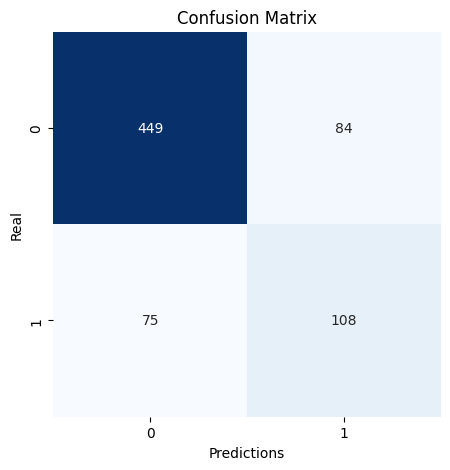

In [ ]:
conf_mat_mlp = confusion_matrix(y_test, y_pred_mlp)
plot_confusion_matrix(conf_mat_mlp,'MLP') #Visualizar la matriz de confusión

## Todos

In [ ]:
def eval_class(classifiers, X,Y, cv, n_jobs):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_score = classifier.predict_proba(X_test)[:,1]

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        scorer = make_scorer(accuracy_score)
        train_sizes = np.linspace(.001, 0.05, 30)

        train_sizes, train_scores, test_scores = learning_curve(classifier, X, Y, cv=cv, n_jobs=n_jobs,
                                                        train_sizes=train_sizes, scoring=scorer)
        classification_rep = classification_report(y_test, y_pred)
        results.append((name, fpr, tpr, roc_auc, confusion_matrix(y_test, y_pred), train_sizes, train_scores, test_scores, classification_rep))
    return results

def plot_eval(results):
    fig, axs = plt.subplots(len(results), 3, figsize=(20, 20))
    axs = axs.flatten()
    j = 0
    for name, fpr, tpr, roc_auc, cm, train_sizes, train_scores, test_scores,classification_rep in results:

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        axs[j].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
        axs[j].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[j].set_xlabel('Tasa Falsos Positivos')
        axs[j].set_ylabel('Tasa Verdaderos Positivos')
        axs[j].set_title(name)
        axs[j].legend(loc='lower right')
        j += 1

        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=.5, square=True, cbar=False, ax=axs[j])
        axs[j].set_xlabel('Predicción')
        axs[j].set_ylabel('Actual')
        axs[j].set_title(name + ' Matriz de Confusion')
        j += 1

        axs[j].set_title(name + " Curva de Aprendizaje")
        axs[j].set_xlabel("Ejemplos de Entrenamiento")
        axs[j].set_ylabel("Puntaje (Accuracy)")
        axs[j].set_ylim(0, 1)
        axs[j].grid(True)
        axs[j].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
        axs[j].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
        axs[j].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntaje de Entrenamiento")
        axs[j].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntaje Cross-validation")
        axs[j].legend(loc="lower left")
        j += 1

    plt.tight_layout()
    plt.show()

def plot_comb_roc(results):
    plt.figure(figsize=(7, 4))
    for name, fpr, tpr, roc_auc, _, _, _, _, _  in results:
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa Falsos Positivos')
    plt.ylabel('Tasa Verdaderos Positivos')
    plt.title('Curvas ROC Combinadas')
    plt.legend(loc='lower right')
    plt.savefig('ROC', dpi=300)
    plt.show()

In [ ]:
classifiers = {
    "SVM": SVC(kernel='linear', random_state=42, C=0.1, class_weight='balanced', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=6, p=1, weights='uniform', n_jobs=-1),
    "RFC": RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=10, min_samples_split=10, min_samples_leaf=3),
    "MLP": MLPClassifier(hidden_layer_sizes=(200,100), max_iter=250, random_state=42, alpha=0.5, early_stopping=True)
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_jobs = -1
results = eval_class(classifiers, X, y, cv, n_jobs)

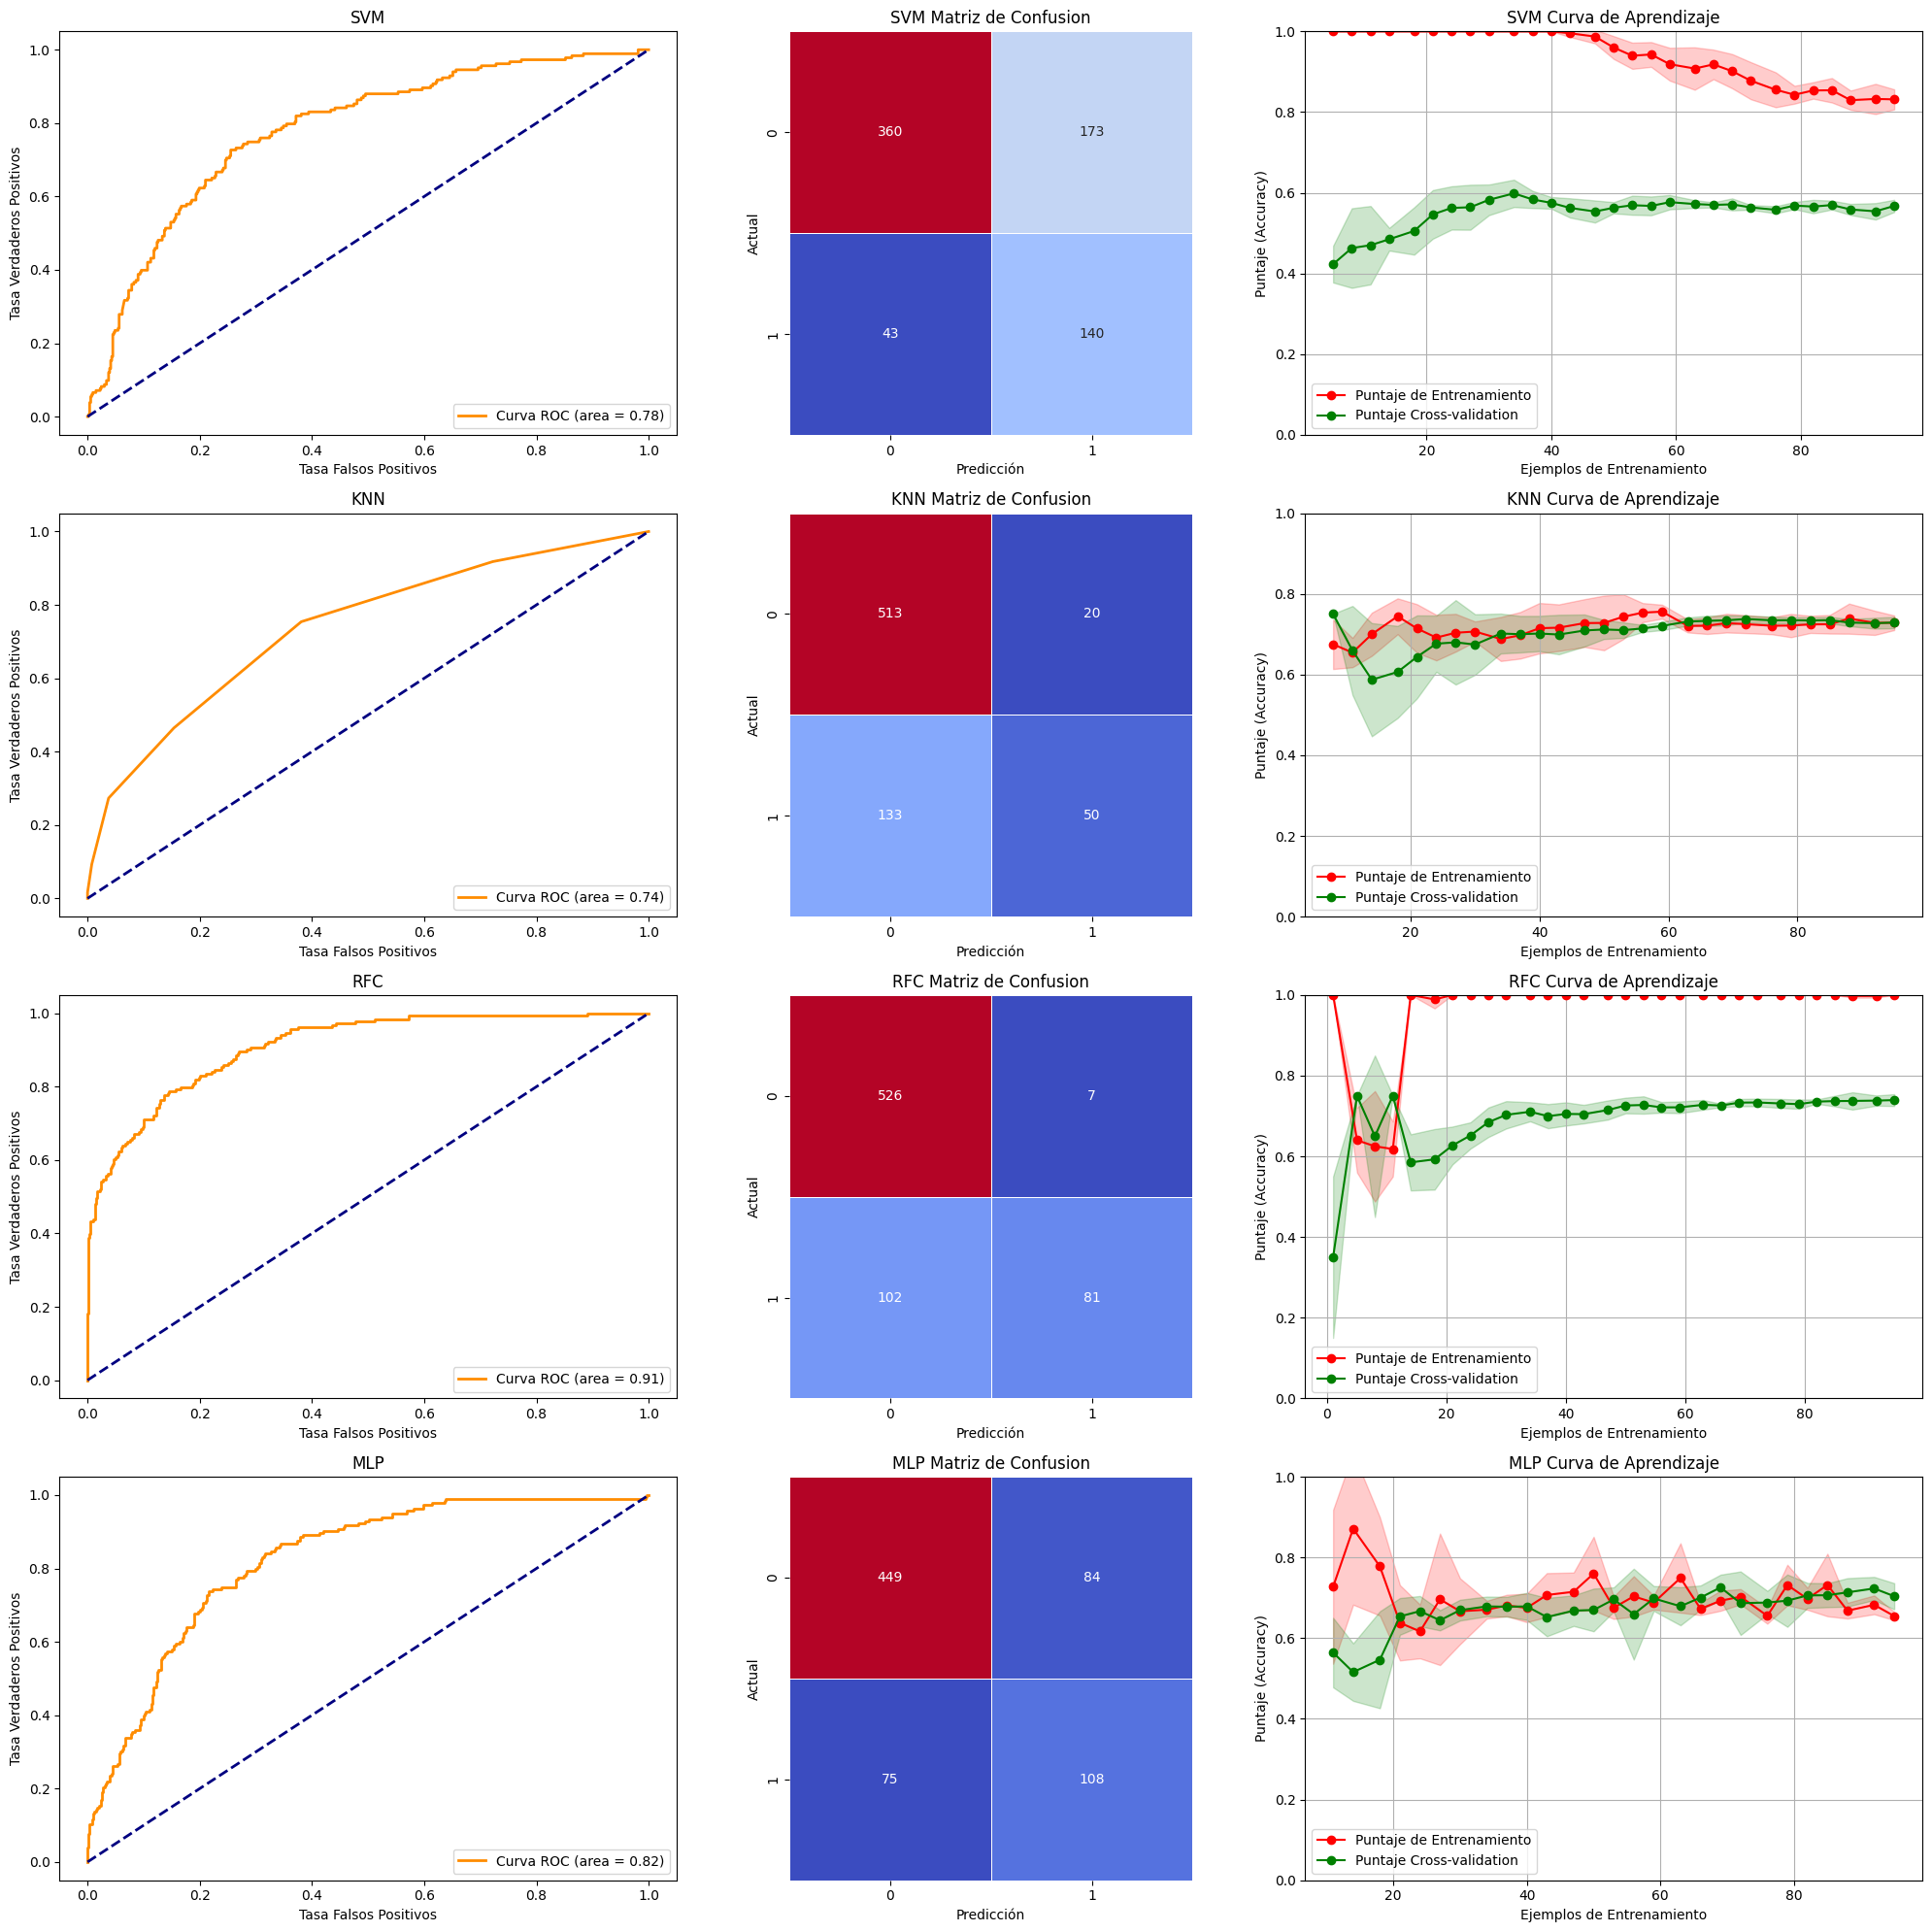

In [ ]:
plot_eval(results)

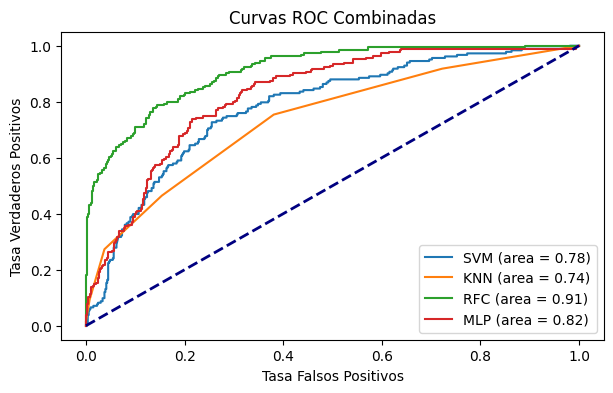

In [ ]:
plot_comb_roc(results)

#Datos Grupales

In [ ]:
N_E = [2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 16, 17, 18, 19, 22, 23, 26, 27, 28] #Conjunto 20 pacientes
N_T = [1, 8, 10, 15, 20, 21, 24, 25] #Conjunto 8 pacientes (pruebas, datos no vistos)

In [ ]:
df_E = []
df_T = []

for i in N_E:
    file_name = f'EEG_Final_S{i:02d}.csv'
    df = pd.read_csv(file_name)
    df_E.append(df)

for i in N_T:
    file_name = f'EEG_Final_S{i:02d}.csv'
    df = pd.read_csv(file_name)
    df_T.append(df)

In [ ]:
SF = pd.concat(df_E, ignore_index=True)
SFM = SF.sample(frac=1, random_state=42).reset_index(drop=True)

SF_T = pd.concat(df_T, ignore_index=True)
SFM_T = SF_T.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
SFM.describe()

AF3_mean    AF3_median       AF3_sum       AF3_max       AF3_min  \
count  47680.000000  47680.000000  47680.000000  47680.000000  47680.000000   
mean      -0.001235      0.000352     -0.158070      0.786789     -0.774325   
std        0.103266      0.103710     13.218008      0.178665      0.185566   
min       -0.561830     -0.650835    -71.914199     -0.078101     -1.000000   
25%       -0.049410     -0.043246     -6.324521      0.672093     -0.934298   
50%       -0.001679      0.001355     -0.214921      0.828928     -0.810308   
75%        0.046101      0.042608      5.900915      0.938524     -0.655778   
max        0.589347      0.645249     75.436403      1.000000      0.020567   

            AF3_std       AF3_var       AF3_per       AF3_iqr       AF3_idr  \
count  47680.000000  47680.000000  47680.000000  47680.000000  47680.000000   
mean       0.327682      0.112090      0.417682      0.437055      0.842398   
std        0.068665      0.044586      0.154481      0.126935      0.204244   
min        0.000000      0.000000     -0.279685      0.000000      0.000000   
25%        0.284023      0.080669      0.323615      0.354102      0.710752   
50%        0.331501      0.109893      0.419674      0.446029      0.848082   
75%        0.374338      0.140129      0.507883      0.518740      0.973929   
max        0.701686      0.492363      0.950007      1.415568      1.785145   

       ...        T8_var        T8_per        T8_iqr        T8_idr  \
count  ...  47680.000000  47680.000000  47680.000000  47680.000000   
mean   ...      0.120536      0.442207      0.456139      0.881668   
std    ...      0.040057      0.132902      0.111797      0.181685   
min    ...      0.000000     -0.438331      0.000000      0.000000   
25%    ...      0.095149      0.364548      0.389908      0.776896   
50%    ...      0.119447      0.443983      0.460318      0.886717   
75%    ...      0.144137      0.518798      0.526874      0.991718   
max    ...      0.350658      0.943491      1.103890      1.674575   

             T8_sos       T8_srsq        T8_rms        T8_avm         T8_ms  \
count  47680.000000  47680.000000  47680.000000  47680.000000  47680.000000   
mean      16.393271      3.984355      0.352171      0.280472      0.352171   
std        5.680314      0.719860      0.063627      0.054402      0.063627   
min        0.000383      0.019562      0.001729      0.001729      0.001729   
25%       12.833799      3.582429      0.316645      0.249604      0.316645   
50%       16.004210      4.000526      0.353600      0.282399      0.353600   
75%       19.492919      4.415079      0.390241      0.313189      0.390241   
max       61.566593      7.846438      0.693534      0.635450      0.693534   

             terror  
count  47680.000000  
mean       0.250000  
std        0.433017  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.250000  
max        1.000000  

[8 rows x 211 columns]

In [ ]:
SFM_T.describe()

AF3_mean    AF3_median       AF3_sum       AF3_max       AF3_min  \
count  19072.000000  19072.000000  19072.000000  19072.000000  19072.000000   
mean      -0.000208     -0.000305     -0.026648      0.790199     -0.776041   
std        0.124502      0.125610     15.936301      0.178168      0.182620   
min       -0.550963     -0.658054    -70.523301     -0.017110     -1.000000   
25%       -0.065289     -0.057274     -8.356979      0.673802     -0.934182   
50%       -0.001580      0.000046     -0.202254      0.832696     -0.808667   
75%        0.060835      0.053143      7.786875      0.942617     -0.658118   
max        0.625483      0.704881     80.061793      1.000000      0.013221   

            AF3_std       AF3_var       AF3_per       AF3_iqr       AF3_idr  \
count  1.907200e+04  1.907200e+04  19072.000000  19072.000000  19072.000000   
mean   3.254041e-01  1.103273e-01      0.417005      0.430343      0.835083   
std    6.663080e-02  4.453767e-02      0.168332      0.121716      0.196793   
min    1.084202e-19  1.175494e-38     -0.190230      0.000000      0.000000   
25%    2.809644e-01  7.894101e-02      0.312713      0.354933      0.704580   
50%    3.241972e-01  1.051038e-01      0.407062      0.424377      0.825042   
75%    3.681238e-01  1.355151e-01      0.512478      0.499152      0.950594   
max    7.117890e-01  5.066436e-01      0.948512      1.362582      1.839625   

       ...        T8_var        T8_per        T8_iqr        T8_idr  \
count  ...  1.907200e+04  19072.000000  19072.000000  19072.000000   
mean   ...  1.140088e-01      0.428309      0.439156      0.851547   
std    ...  4.159563e-02      0.150898      0.116192      0.187472   
min    ...  1.880791e-37     -0.431646      0.000000      0.000000   
25%    ...  8.666402e-02      0.339678      0.366308      0.734958   
50%    ...  1.099839e-01      0.422529      0.438396      0.847036   
75%    ...  1.364109e-01      0.512081      0.507164      0.961242   
max    ...  3.622941e-01      0.959695      1.166203      1.634654   

             T8_sos       T8_srsq        T8_rms        T8_avm         T8_ms  \
count  19072.000000  19072.000000  19072.000000  19072.000000  19072.000000   
mean      16.141792      3.940502      0.348294      0.276912      0.348294   
std        6.470463      0.783751      0.069274      0.059673      0.069274   
min        0.000237      0.015400      0.001361      0.001361      0.001361   
25%       11.845015      3.441659      0.304203      0.239516      0.304203   
50%       15.142708      3.891363      0.343951      0.273125      0.343951   
75%       19.217181      4.383741      0.387472      0.309587      0.387472   
max       58.307204      7.635915      0.674926      0.642748      0.674926   

             terror  
count  19072.000000  
mean       0.250000  
std        0.433024  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.250000  
max        1.000000  

[8 rows x 211 columns]

#Modelos Grupales

In [ ]:
X = SFM.drop(columns=['terror'])
y = SFM['terror']

X_test_S5 = SFM_T.drop(columns=['terror'])
y_test_S5 = SFM_T['terror']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6, p=1, weights='uniform', n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6, p=1)

In [ ]:
joblib.dump(knn,'T_KNN_30_R.joblib') #Decargar modelo
#knn = joblib.load('T_KNN_30_R.joblib') #Cargar modelo

In [ ]:
y_pred_knn = knn.predict(X_test) #Predecir conjunto de prueba

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.8173238255033557
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     10715
         1.0       0.76      0.40      0.52      3589

    accuracy                           0.82     14304
   macro avg       0.79      0.68      0.71     14304
weighted avg       0.81      0.82      0.80     14304



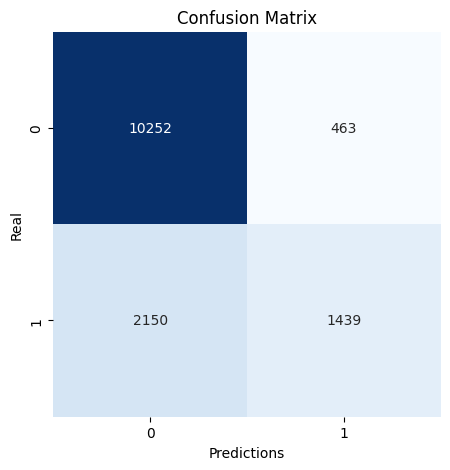

In [ ]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(conf_mat_knn,'KNN') #Visualizar la matriz de confusión

In [ ]:
y_pred_S5_knn = knn.predict(X_test_S5) #Predecir dataset de prueba

print("Accuracy:", accuracy_score(y_test_S5, y_pred_S5_knn))
print("Classification Report:\n", classification_report(y_test_S5, y_pred_S5_knn))

Accuracy: 0.7453334731543624
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     14304
         1.0       0.48      0.19      0.27      4768

    accuracy                           0.75     19072
   macro avg       0.63      0.56      0.56     19072
weighted avg       0.70      0.75      0.70     19072



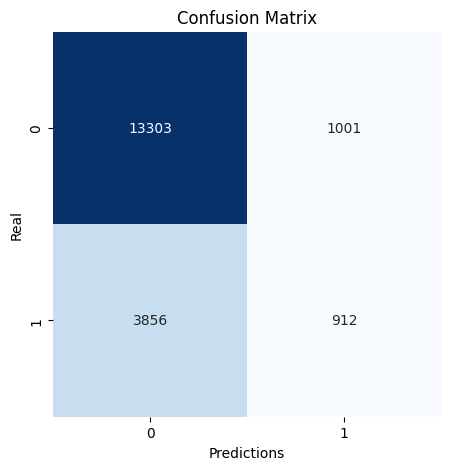

In [ ]:
conf_mat_knn_s5 = confusion_matrix(y_test_S5, y_pred_S5_knn)
plot_confusion_matrix(conf_mat_knn_s5,'KNN') #Visualizar la matriz de confusión

## RFC

In [ ]:
RFC = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=10, min_samples_split=10, min_samples_leaf=3)
RFC.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [ ]:
joblib.dump(RFC,'T_RFC_30_R.joblib') #Descargar modelo
#RFC = joblib.load('T_RFC_30_R.joblib') #Cargar modelo

In [ ]:
y_pred_rfc = RFC.predict(X_test) #Predecir conjunto de prueba

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("Classification Report:\n", classification_report(y_test, y_pred_rfc))

Accuracy: 0.7815296420581656
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.87      0.86     10715
         1.0       0.57      0.50      0.54      3589

    accuracy                           0.78     14304
   macro avg       0.71      0.69      0.70     14304
weighted avg       0.77      0.78      0.78     14304



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

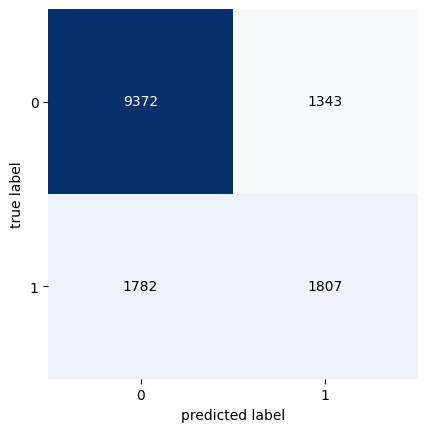

In [ ]:
conf_mat_rfc = confusion_matrix(y_test, y_pred_rfc)
plot_confusion_matrix(conf_mat_rfc,'RFC') #Visualizar la matriz de confusión

In [ ]:
y_pred_S5_rfc = RFC.predict(X_test_S5) #Predecir dataset de prueba

print("Accuracy:", accuracy_score(y_test_S5, y_pred_S5_rfc))
print("Classification Report:\n", classification_report(y_test_S5, y_pred_S5_rfc))

Accuracy: 0.7545616610738255
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.89      0.84     14304
         1.0       0.51      0.35      0.42      4768

    accuracy                           0.75     19072
   macro avg       0.66      0.62      0.63     19072
weighted avg       0.73      0.75      0.74     19072



(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

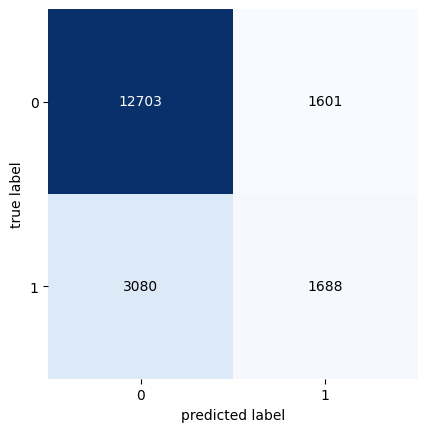

In [ ]:
conf_mat_rfc_s5 = confusion_matrix(y_test_S5, y_pred_S5_rfc)
plot_confusion_matrix(conf_mat_rfc_s5,'RFC') #Visualizar la matriz de confusión

## MLP (Perceptrón Multicapa)

In [ ]:
MLP = MLPClassifier(hidden_layer_sizes=(200,100), max_iter=250, random_state=42, alpha=0.5, early_stopping=True)
MLP.fit(X_train, y_train)

MLPClassifier(alpha=0.5, early_stopping=True, hidden_layer_sizes=(200, 100),
              max_iter=250, random_state=42)

In [ ]:
joblib.dump(MLP,'T_MLP_10_R.joblib') #Descargar modelo
#MLP = joblib.load('T_MLP_30_R.joblib') #Cargar modelo

In [ ]:
y_pred_mlp = MLP.predict(X_test) #Predecir conjunto de prueba

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Accuracy: 0.7789429530201343
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.93      0.86     10715
         1.0       0.61      0.32      0.42      3589

    accuracy                           0.78     14304
   macro avg       0.71      0.63      0.64     14304
weighted avg       0.76      0.78      0.75     14304



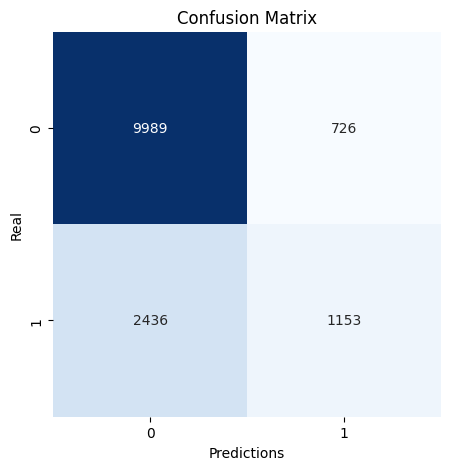

In [ ]:
conf_mat_mlp = confusion_matrix(y_test, y_pred_mlp)
plot_confusion_matrix(conf_mat_mlp,'MLP') #Visualizar la matriz de confusión

In [ ]:
y_pred_S5_mlp = MLP.predict(X_test_S5) #Predecir dataset de prueba

print("Accuracy:", accuracy_score(y_test_S5, y_pred_S5_mlp))
print("Classification Report:\n", classification_report(y_test_S5, y_pred_S5_mlp))

Accuracy: 0.7449664429530202
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84     14304
         1.0       0.48      0.28      0.35      4768

    accuracy                           0.74     19072
   macro avg       0.64      0.59      0.60     19072
weighted avg       0.71      0.74      0.72     19072



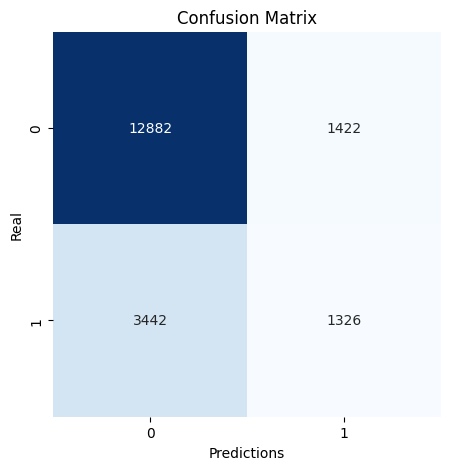

In [ ]:
conf_mat_mlp_s5 = confusion_matrix(y_test_S5, y_pred_S5_mlp)
plot_confusion_matrix(conf_mat_mlp_s5,'MLP') #Visualizar la matriz de confusión

## Todos

In [ ]:
def eval_class(classifiers, X,Y, cv, n_jobs):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_score = classifier.predict_proba(X_test)[:,1]

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        scorer = make_scorer(accuracy_score)
        train_sizes = np.linspace(.001, 0.05, 30)

        train_sizes, train_scores, test_scores = learning_curve(classifier, X, Y, cv=cv, n_jobs=n_jobs,
                                                        train_sizes=train_sizes, scoring=scorer)
        classification_rep = classification_report(y_test, y_pred)
        results.append((name, fpr, tpr, roc_auc, confusion_matrix(y_test, y_pred), train_sizes, train_scores, test_scores, classification_rep))
    return results

def plot_eval(results):
    fig, axs = plt.subplots(len(results), 3, figsize=(20, 20))
    axs = axs.flatten()
    j = 0
    for name, fpr, tpr, roc_auc, cm, train_sizes, train_scores, test_scores,classification_rep in results:

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        axs[j].plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
        axs[j].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[j].set_xlabel('Tasa Falsos Positivos')
        axs[j].set_ylabel('Tasa Verdaderos Positivos')
        axs[j].set_title(name)
        axs[j].legend(loc='lower right')
        j += 1

        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=.5, square=True, cbar=False, ax=axs[j])
        axs[j].set_xlabel('Predicción')
        axs[j].set_ylabel('Actual')
        axs[j].set_title(name + ' Matriz de Confusion')
        j += 1

        axs[j].set_title(name + " Curva de Aprendizaje")
        axs[j].set_xlabel("Ejemplos de Entrenamiento")
        axs[j].set_ylabel("Puntaje (Accuracy)")
        axs[j].set_ylim(0, 1)
        axs[j].grid(True)
        axs[j].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
        axs[j].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
        axs[j].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntaje de Entrenamiento")
        axs[j].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntaje Cross-validation")
        axs[j].legend(loc="lower left")
        j += 1

    plt.tight_layout()
    plt.show()

def plot_comb_roc(results):
    plt.figure(figsize=(7, 4))
    for name, fpr, tpr, roc_auc, _, _, _, _, _  in results:
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa Falsos Positivos')
    plt.ylabel('Tasa Verdaderos Positivos')
    plt.title('Curvas ROC Combinadas')
    plt.legend(loc='lower right')
    plt.savefig('ROC', dpi=300)
    plt.show()

In [ ]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=6, p=1, weights='uniform', n_jobs=-1),
    "RFC": RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced', max_depth=10, min_samples_split=10, min_samples_leaf=3),
    "MLP": MLPClassifier(hidden_layer_sizes=(200,100), max_iter=250, random_state=42, alpha=0.5, early_stopping=True)
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_jobs = -1
results = eval_class(classifiers, X, y, cv, n_jobs)

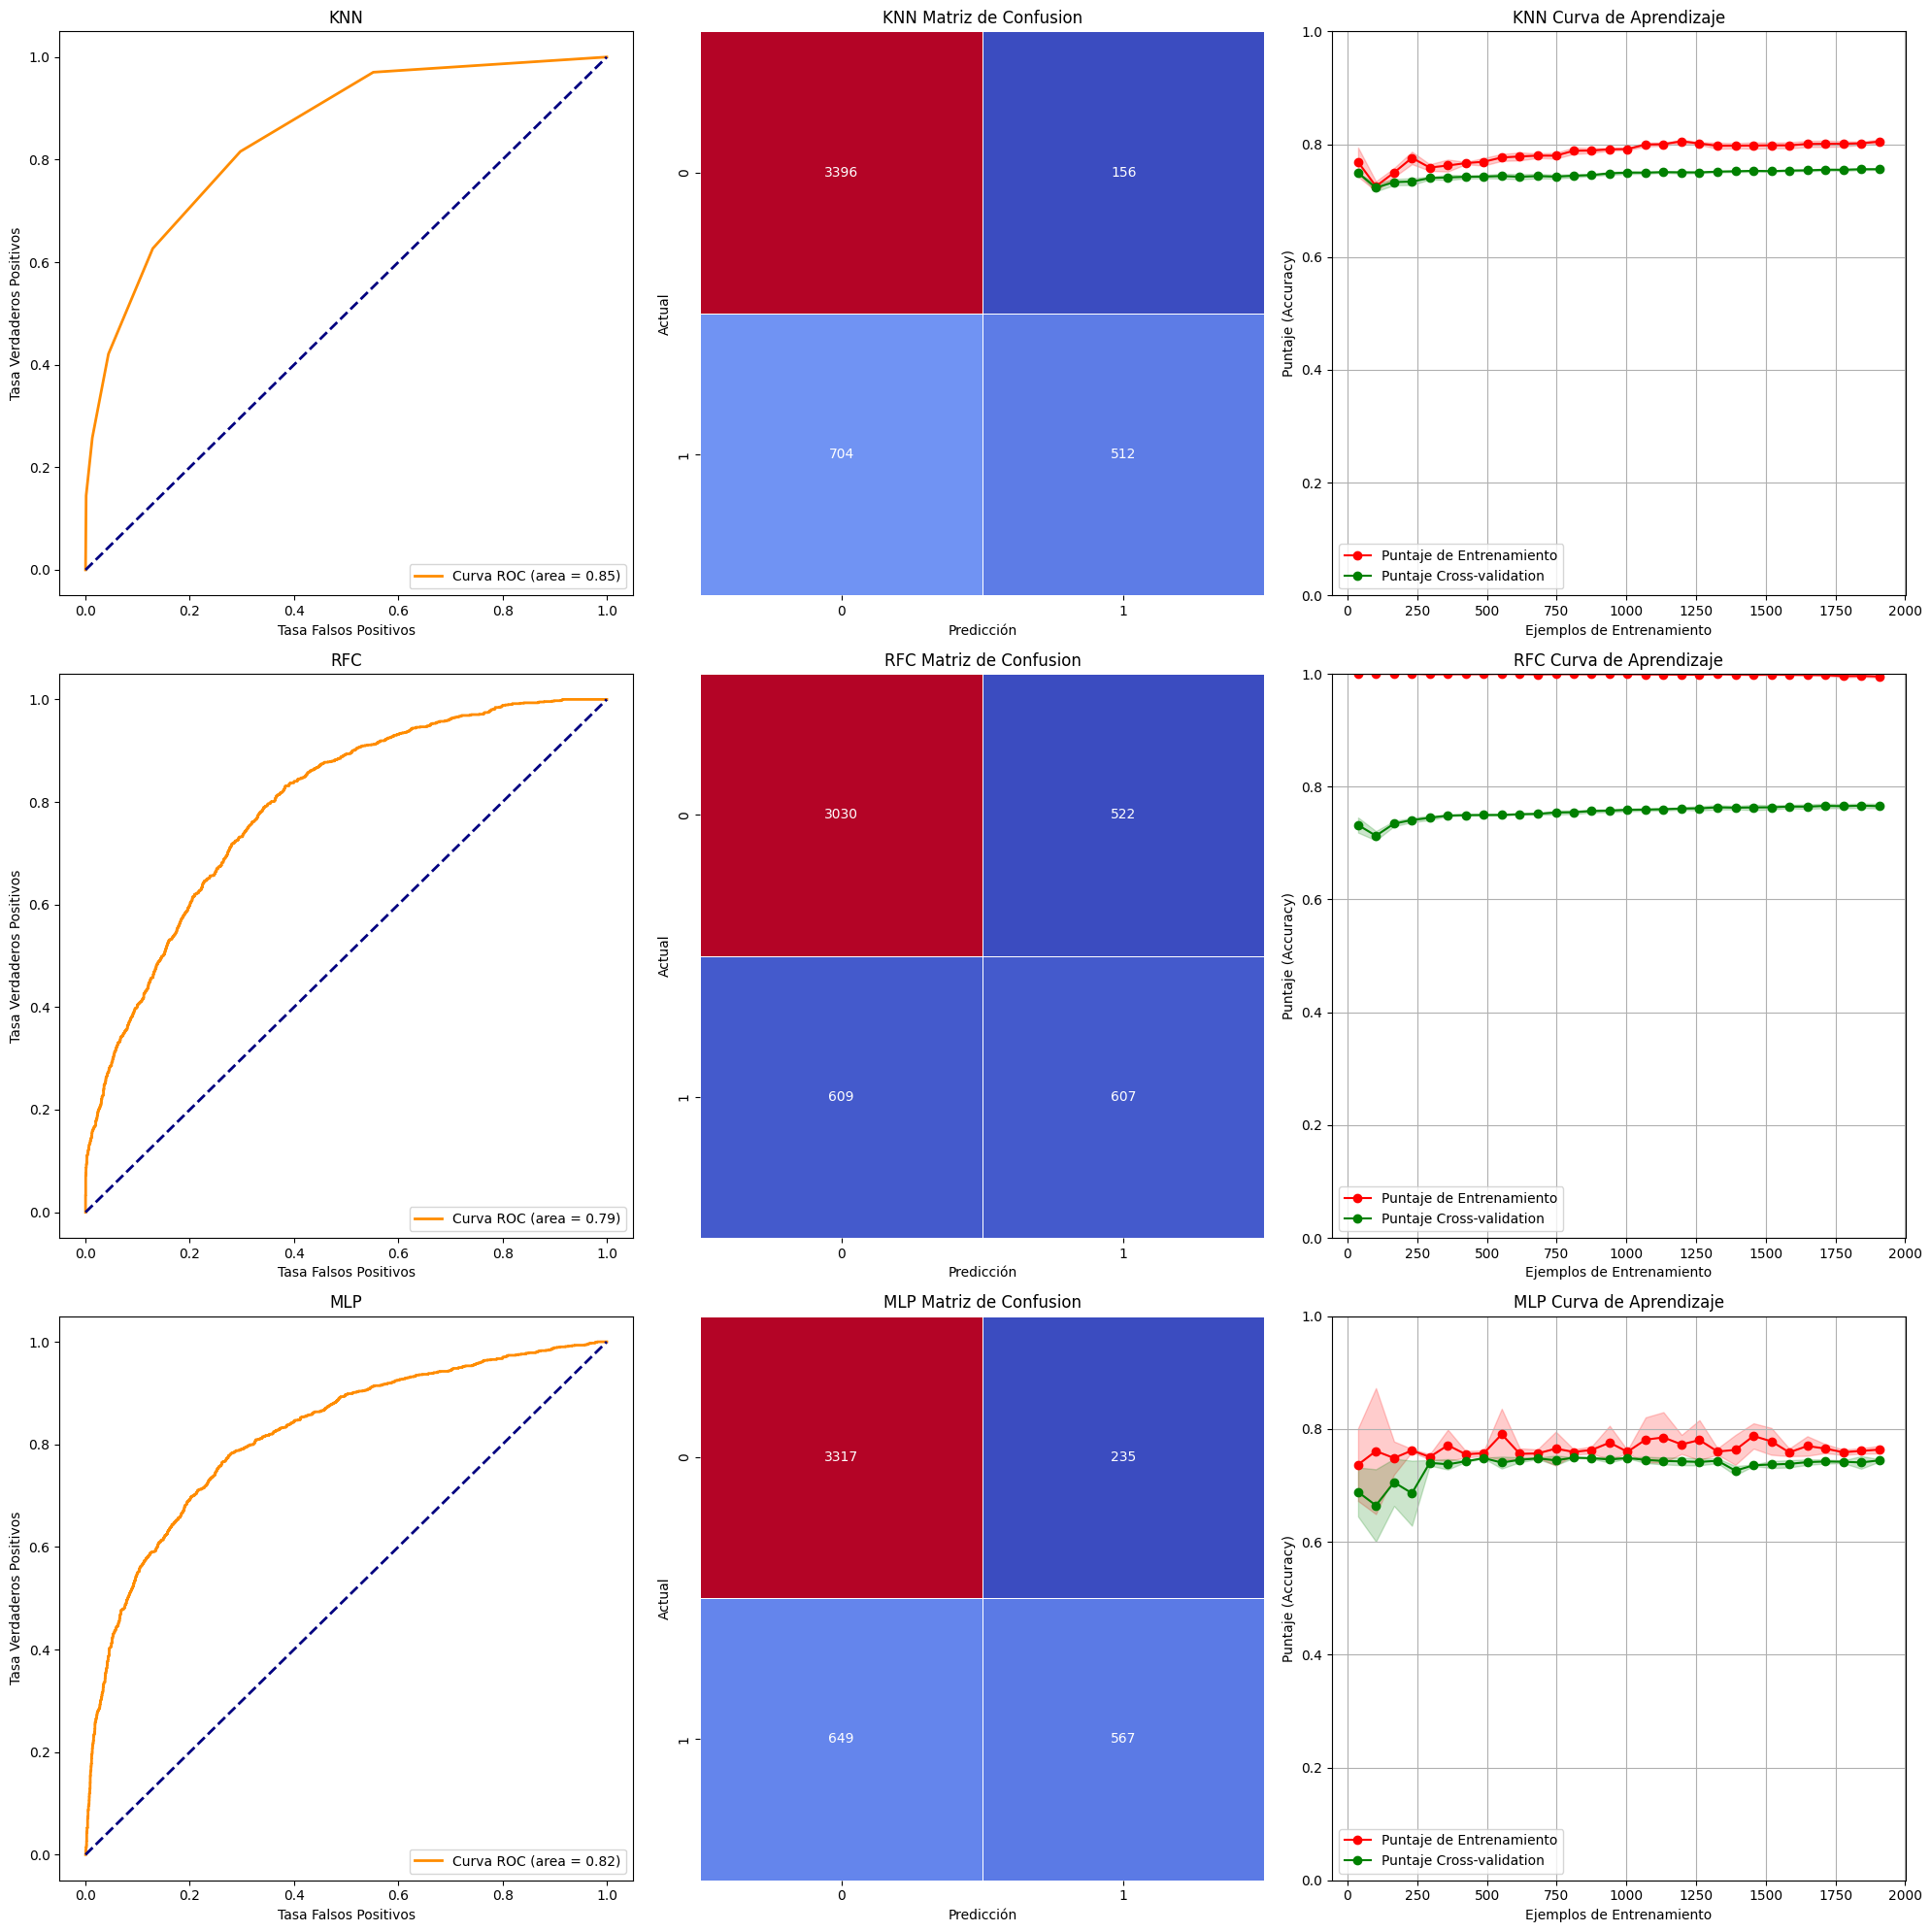

In [ ]:
plot_eval(results)

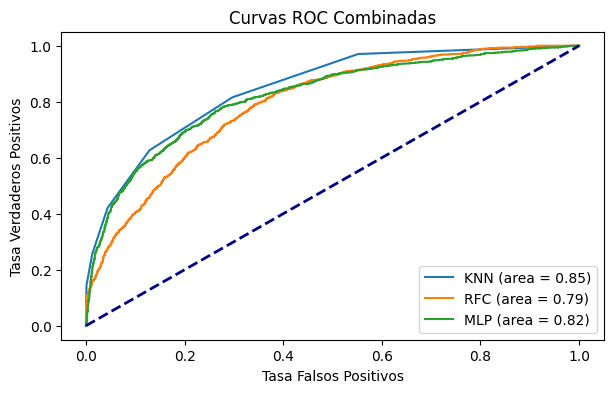

In [ ]:
plot_comb_roc(results)

# Otros Análisis

In [ ]:
SAM_G1 = pd.read_csv('/content/data_TFM_2/SAM_G1.csv')
SAM_G2 = pd.read_csv('/content/data_TFM_2/SAM_G2.csv')
SAM_G3 = pd.read_csv('/content/data_TFM_2/SAM_G3.csv')
SAM_G4 = pd.read_csv('/content/data_TFM_2/SAM_G4.csv')

## Aburrido

In [ ]:
SAM_G1.head()

Subject Gender  Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
0        1      F   24                 2              8                1   
1        2      M   23                 1              8                1   
2        3      M   25                 2              7                2   
3        4      M   20                 4              8                1   
4        5      F   25                 3              7                1   

   Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
0            3             2              2              3  
1            4             2              1              1  
2            6             1              1              2  
3            3             1              2              4  
4            2             1              3              3

In [ ]:
SAM_G1.columns

Index(['Subject', 'Gender', 'Age', 'Satisfied (1-10)', 'Boring (1-10)',
       'Horrible (1-10)', 'Calm (1-10)', 'Funny (1-10)', 'Valence (1-9)',
       'Arousal (1-9)'],
      dtype='object')

In [ ]:
SAM_G1.describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count  28.000000  28.000000         28.000000      28.000000        28.000000   
mean   14.500000  23.107143          3.071429       7.571429         1.035714   
std     8.225975   2.166056          1.741191       1.708987         0.188982   
min     1.000000  20.000000          1.000000       2.000000         1.000000   
25%     7.750000  21.750000          2.000000       7.000000         1.000000   
50%    14.500000  23.000000          3.000000       8.000000         1.000000   
75%    21.250000  25.000000          3.250000       8.250000         1.000000   
max    28.000000  27.000000          8.000000      10.000000         2.000000   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count    28.000000     28.000000      28.000000      28.000000  
mean      6.071429      2.785714       3.357143       2.571429  
std       2.308255      1.728993       1.768328       1.288944  
min       1.000000      1.000000       1.000000       1.000000  
25%       4.000000      1.750000       2.000000       1.000000  
50%       7.000000      2.000000       3.000000       3.000000  
75%       8.000000      4.000000       5.000000       3.250000  
max      10.000000      7.000000       7.000000       5.000000

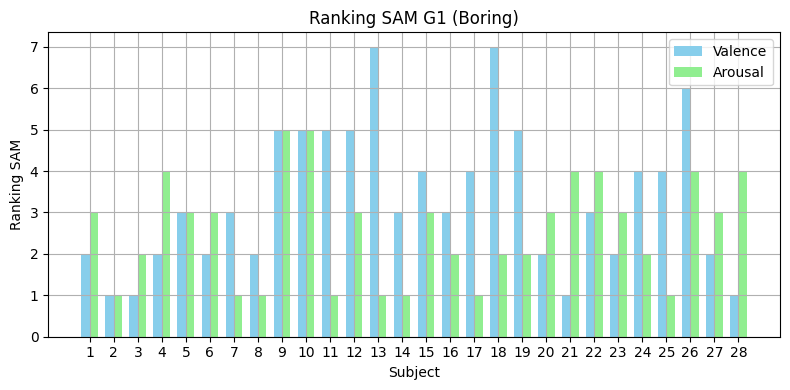

In [ ]:
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = range(len(SAM_G1))
plt.bar(index, SAM_G1['Valence (1-9)'], color='skyblue', width=bar_width, label='Valence')
plt.bar([i + bar_width for i in index], SAM_G1['Arousal (1-9)'], color='lightgreen', width=bar_width, label='Arousal')
plt.xlabel('Subject')
plt.ylabel('Ranking SAM')
plt.title('Ranking SAM G1 (Boring)')
plt.xticks([i + bar_width / 2 for i in index], SAM_G1['Subject'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Tranquilo

In [ ]:
SAM_G2.describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count  28.000000  28.000000         28.000000      28.000000             28.0   
mean   14.500000  23.107143          6.392857       2.428571              1.0   
std     8.225975   2.166056          2.114137       1.501322              0.0   
min     1.000000  20.000000          2.000000       1.000000              1.0   
25%     7.750000  21.750000          5.000000       1.000000              1.0   
50%    14.500000  23.000000          7.000000       2.000000              1.0   
75%    21.250000  25.000000          8.000000       3.000000              1.0   
max    28.000000  27.000000          9.000000       7.000000              1.0   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count    28.000000     28.000000      28.000000      28.000000  
mean      7.357143      6.071429       6.178571       4.357143  
std       1.193013      1.864454       1.846991       2.094336  
min       5.000000      2.000000       3.000000       1.000000  
25%       7.000000      6.000000       5.000000       3.000000  
50%       7.000000      6.000000       7.000000       4.000000  
75%       8.000000      7.250000       7.000000       5.250000  
max      10.000000      8.000000       9.000000       9.000000

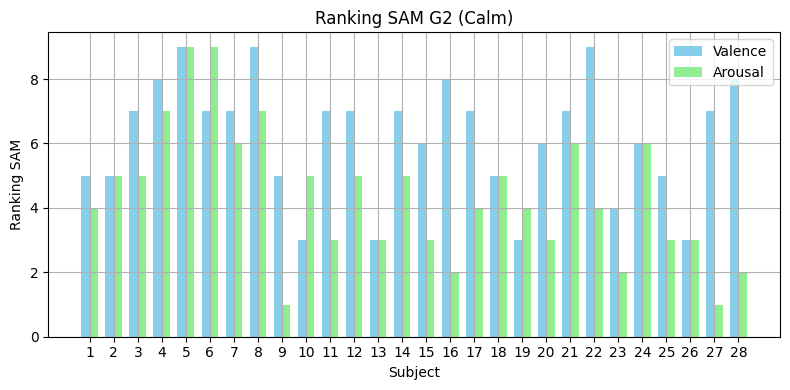

In [ ]:
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = range(len(SAM_G2))
plt.bar(index, SAM_G2['Valence (1-9)'], color='skyblue', width=bar_width, label='Valence')
plt.bar([i + bar_width for i in index], SAM_G2['Arousal (1-9)'], color='lightgreen', width=bar_width, label='Arousal')
plt.xlabel('Subject')
plt.ylabel('Ranking SAM')
plt.title('Ranking SAM G2 (Calm)')
plt.xticks([i + bar_width / 2 for i in index], SAM_G2['Subject'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Terror

In [ ]:
SAM_G3

Subject Gender  Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
0         1      F   24                 2              2                8   
1         2      M   23                 2              2                8   
2         3      M   25                 9              1               10   
3         4      M   20                 7              1                9   
4         5      F   25                 4              1                8   
5         6      F   21                 1              1                8   
6         7      M   22                 6              1               10   
7         8      M   26                10              1                5   
8         9      M   23                 6              1                9   
9        10      M   20                 5              1                8   
10       11      M   26                 3              7                8   
11       12      F   25                 4              1                6   
12       13      M   20                 4              1                8   
13       14      M   25                 4              1                8   
14       15      M   22                 5              1                8   
15       16      M   20                 8              1                9   
16       17      F   26                 4              1                7   
17       18      F   26                 7              2                6   
18       19      F   23                 6              3                6   
19       20      F   22                 1              1               10   
20       21      F   20                 1              2               10   
21       22      M   23                 7              1                8   
22       23      M   21                 2              1                6   
23       24      M   23                 8              3                7   
24       25      M   27                 9              1                6   
25       26      M   23                 1              1               10   
26       27      M   22                 1              1               10   
27       28      M   24                 3              1                7   

    Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
0             1             1              2              9  
1             3             2              1              9  
2             1             1              2              9  
3             2             1              3              9  
4             1             2              1              9  
5             1             1              4              5  
6             1             1              5              7  
7             7             1              1              1  
8             2             3              3              7  
9             2             1              3              7  
10            2             3              3              4  
11            2             3              5              5  
12            4             2              3              4  
13            2             4              4              7  
14            2             2              2              7  
15            4             1              1              6  
16            4             3              3              6  
17            3             3              4              6  
18            3             4              4              5  
19            2             1              2              8  
20            1             1              1              9  
21            3             3              3              6  
22            5             3              2              4  
23            5             5              4              5  
24            3             4              4              6  
25            1             1              2              7  
26            1             1              1              7  
27            6             1     

In [ ]:
SAM_G3.describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count  28.000000  28.000000         28.000000      28.000000        28.000000   
mean   14.500000  23.107143          4.642857       1.500000         7.964286   
std     8.225975   2.166056          2.765050       1.232282         1.477790   
min     1.000000  20.000000          1.000000       1.000000         5.000000   
25%     7.750000  21.750000          2.000000       1.000000         7.000000   
50%    14.500000  23.000000          4.000000       1.000000         8.000000   
75%    21.250000  25.000000          7.000000       1.250000         9.000000   
max    28.000000  27.000000         10.000000       7.000000        10.000000   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count    28.000000     28.000000      28.000000      28.000000  
mean      2.642857      2.107143       2.642857       6.357143  
std       1.637846      1.227442       1.282771       1.985396  
min       1.000000      1.000000       1.000000       1.000000  
25%       1.000000      1.000000       1.750000       5.000000  
50%       2.000000      2.000000       3.000000       6.500000  
75%       3.250000      3.000000       4.000000       7.250000  
max       7.000000      5.000000       5.000000       9.000000

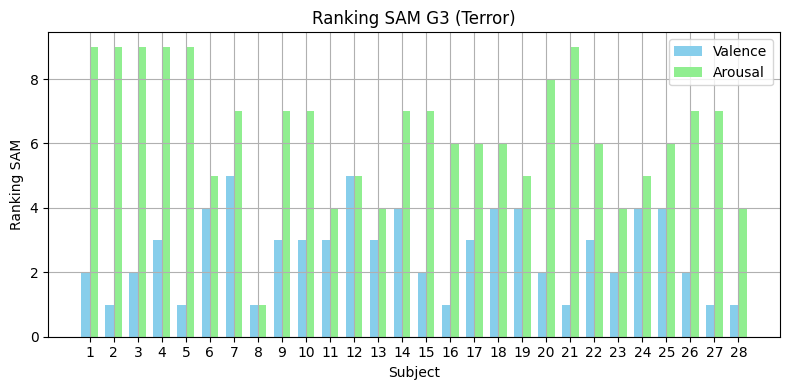

In [ ]:
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = range(len(SAM_G3))
plt.bar(index, SAM_G3['Valence (1-9)'], color='skyblue', width=bar_width, label='Valence')
plt.bar([i + bar_width for i in index], SAM_G3['Arousal (1-9)'], color='lightgreen', width=bar_width, label='Arousal')
plt.xlabel('Subject')
plt.ylabel('Ranking SAM')
plt.title('Ranking SAM G3 (Terror)')
plt.xticks([i + bar_width / 2 for i in index], SAM_G3['Subject'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

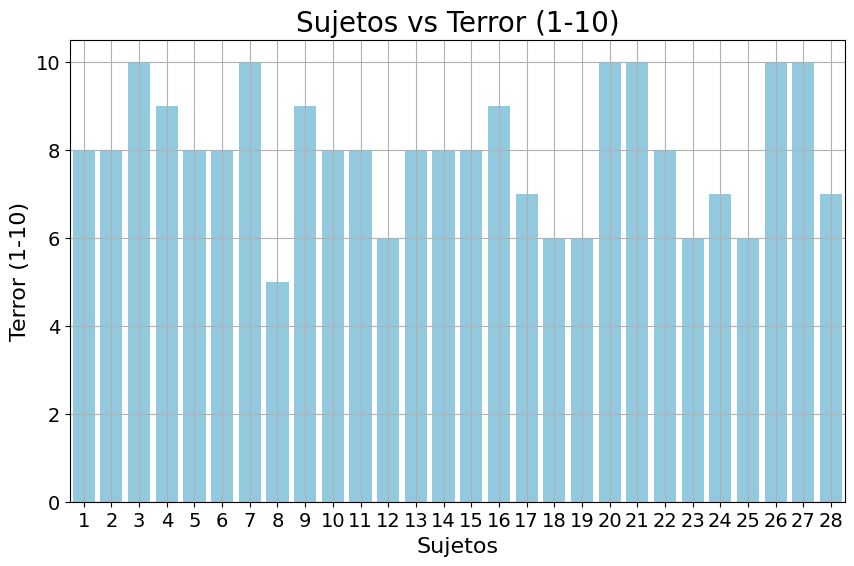

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Subject', y='Horrible (1-10)', data=SAM_G3, color='skyblue')
plt.title('Sujetos vs Terror (1-10)', fontsize=20)
plt.xlabel('Sujetos', fontsize=16)
plt.ylabel('Terror (1-10)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig('Terror_Histo', dpi=300)
plt.show()

In [ ]:
SAM_G3[SAM_G3['Gender'] == 'M'].describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count  19.000000  19.000000         19.000000      19.000000        19.000000   
mean   15.105263  22.894737          5.263158       1.473684         8.105263   
std     8.685203   2.183136          2.825324       1.428613         1.448936   
min     2.000000  20.000000          1.000000       1.000000         5.000000   
25%     8.500000  21.500000          3.000000       1.000000         7.500000   
50%    14.000000  23.000000          5.000000       1.000000         8.000000   
75%    23.500000  24.500000          7.500000       1.000000         9.000000   
max    28.000000  27.000000         10.000000       7.000000        10.000000   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count    19.000000     19.000000      19.000000      19.000000  
mean      2.947368      2.105263       2.526316       6.105263  
std       1.778691      1.286457       1.218762       2.051957  
min       1.000000      1.000000       1.000000       1.000000  
25%       2.000000      1.000000       1.500000       4.500000  
50%       2.000000      2.000000       3.000000       7.000000  
75%       4.000000      3.000000       3.000000       7.000000  
max       7.000000      5.000000       5.000000       9.000000

In [ ]:
SAM_G3[SAM_G3['Gender'] == 'F'].describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count   9.000000   9.000000          9.000000       9.000000         9.000000   
mean   13.222222  23.555556          3.333333       1.555556         7.666667   
std     7.479602   2.185813          2.236068       0.726483         1.581139   
min     1.000000  20.000000          1.000000       1.000000         6.000000   
25%     6.000000  22.000000          1.000000       1.000000         6.000000   
50%    17.000000  24.000000          4.000000       1.000000         8.000000   
75%    19.000000  25.000000          4.000000       2.000000         8.000000   
max    21.000000  26.000000          7.000000       3.000000        10.000000   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count     9.000000      9.000000       9.000000       9.000000  
mean      2.000000      2.111111       2.888889       6.888889  
std       1.118034      1.166667       1.452966       1.833333  
min       1.000000      1.000000       1.000000       5.000000  
25%       1.000000      1.000000       2.000000       5.000000  
50%       2.000000      2.000000       3.000000       6.000000  
75%       3.000000      3.000000       4.000000       9.000000  
max       4.000000      4.000000       5.000000       9.000000

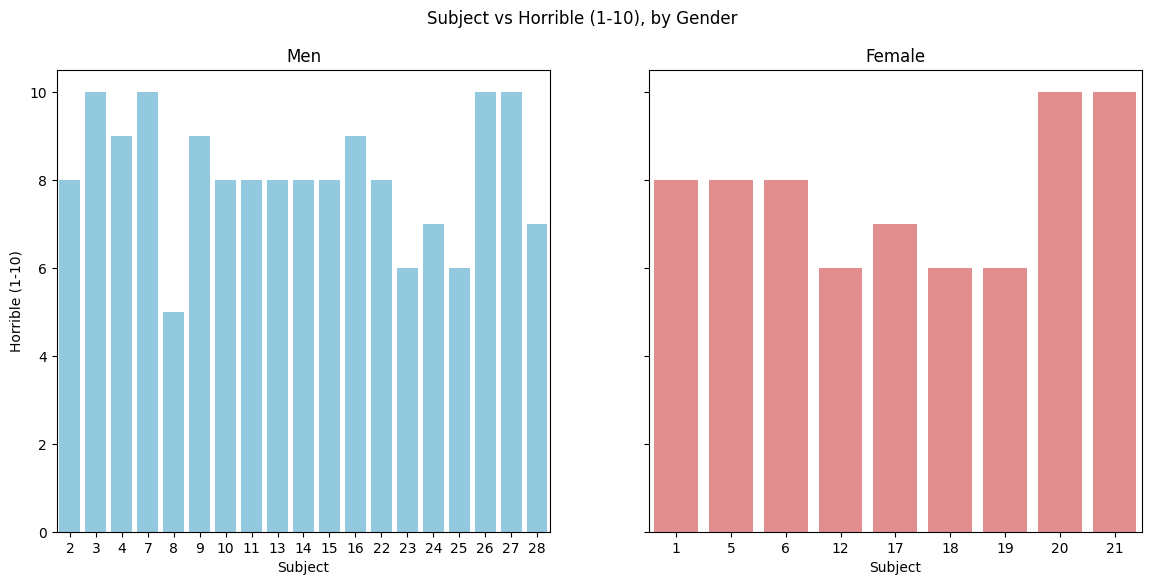

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.barplot(ax=axes[0], x='Subject', y='Horrible (1-10)', data=SAM_G3[SAM_G3['Gender'] == 'M'], color='skyblue')
axes[0].set_title('Men')
axes[0].set_xlabel('Subject')
axes[0].set_ylabel('Horrible (1-10)')
sns.barplot(ax=axes[1], x='Subject', y='Horrible (1-10)', data=SAM_G3[SAM_G3['Gender'] == 'F'], color='lightcoral')
axes[1].set_title('Female')
axes[1].set_xlabel('Subject')
axes[1].set_ylabel('Horrible (1-10)')
fig.suptitle('Subject vs Horrible (1-10), by Gender')
plt.savefig('Histo_G.png', dpi=300)
plt.show()

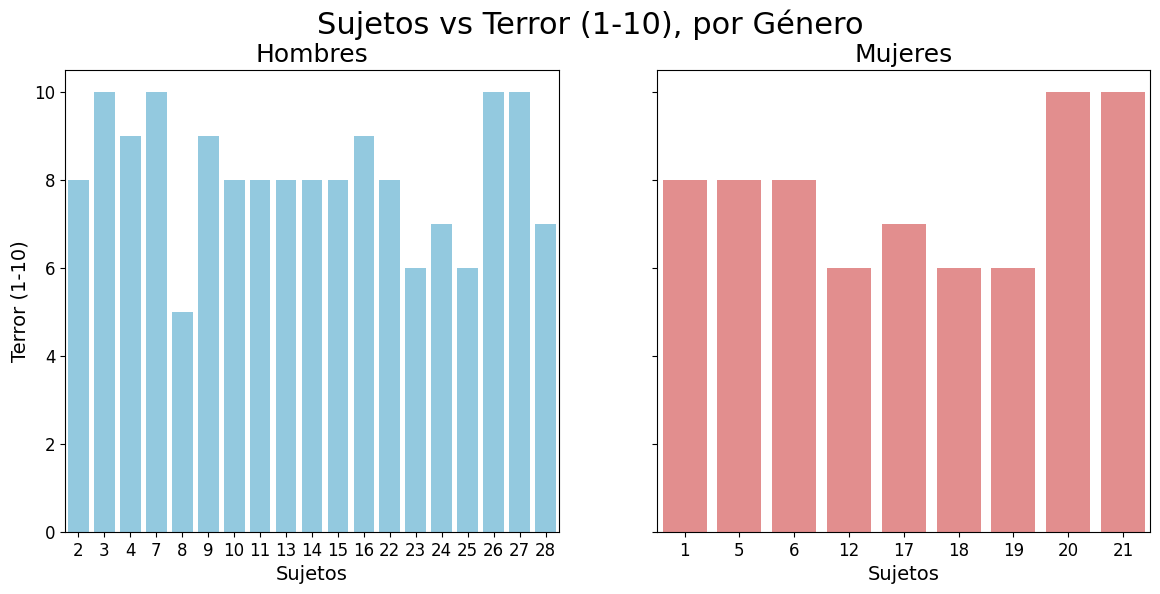

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.barplot(ax=axes[0], x='Subject', y='Horrible (1-10)', data=SAM_G3[SAM_G3['Gender'] == 'M'], color='skyblue')

axes[0].set_title('Hombres', fontsize=18)
axes[0].set_xlabel('Sujetos', fontsize=14)
axes[0].set_ylabel('Terror (1-10)', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

sns.barplot(ax=axes[1], x='Subject', y='Horrible (1-10)', data=SAM_G3[SAM_G3['Gender'] == 'F'], color='lightcoral')
axes[1].set_title('Mujeres', fontsize=18)
axes[1].set_xlabel('Sujetos', fontsize=14)
axes[1].set_ylabel('Terror (1-10)', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)


fig.suptitle('Sujetos vs Terror (1-10), por Género', fontsize=22)
plt.savefig('Histo_G.png', dpi=300)
plt.show()

## Divertido

In [ ]:
SAM_G4.describe()

Subject        Age  Satisfied (1-10)  Boring (1-10)  Horrible (1-10)  \
count  28.000000  28.000000         28.000000      28.000000        28.000000   
mean   14.500000  23.107143          7.892857       1.142857         1.178571   
std     8.225975   2.166056          0.916486       0.448395         0.390021   
min     1.000000  20.000000          5.000000       1.000000         1.000000   
25%     7.750000  21.750000          7.000000       1.000000         1.000000   
50%    14.500000  23.000000          8.000000       1.000000         1.000000   
75%    21.250000  25.000000          8.250000       1.000000         1.000000   
max    28.000000  27.000000          9.000000       3.000000         2.000000   

       Calm (1-10)  Funny (1-10)  Valence (1-9)  Arousal (1-9)  
count    28.000000     28.000000      28.000000      28.000000  
mean      4.107143      7.964286       6.892857       5.892857  
std       2.216759      1.346660       1.617938       1.931019  
min       1.000000      5.000000       4.000000       1.000000  
25%       2.000000      7.000000       5.000000       5.000000  
50%       3.500000      8.000000       7.000000       6.000000  
75%       6.000000      9.000000       8.250000       7.000000  
max       8.000000     10.000000       9.000000       9.000000

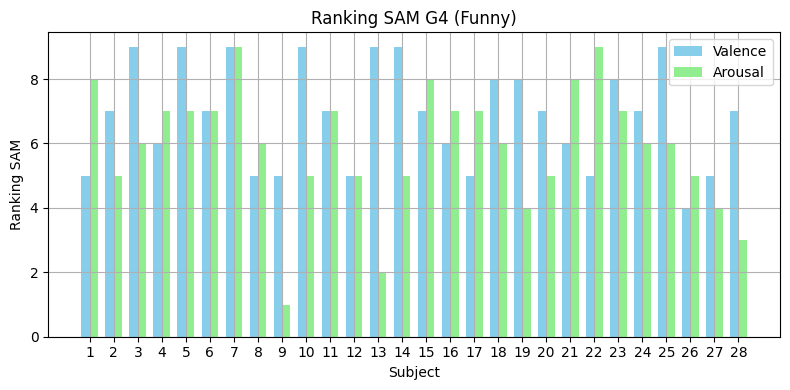

In [ ]:
plt.figure(figsize=(8, 4))
bar_width = 0.35
index = range(len(SAM_G4))
plt.bar(index, SAM_G4['Valence (1-9)'], color='skyblue', width=bar_width, label='Valence')
plt.bar([i + bar_width for i in index], SAM_G4['Arousal (1-9)'], color='lightgreen', width=bar_width, label='Arousal')
plt.xlabel('Subject')
plt.ylabel('Ranking SAM')
plt.title('Ranking SAM G4 (Funny)')
plt.xticks([i + bar_width / 2 for i in index], SAM_G4['Subject'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()